In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : features,
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLeng

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 975)
(3944610, 8)
validation
(464344, 975)
(464344, 8)
test
(574820, 975)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 975)]             0         


 dense (Dense)               (None, 1024)              999424    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1689480 (6.44 MB)


Trainable params: 1689480 (6.44 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 10:49 - loss: 2.1952 - STD: 0.0665 - MAE: 0.2171

  3/395 [..............................] - ETA: 10s - loss: 2.1046 - STD: 0.0447 - MAE: 0.2169  

  5/395 [..............................] - ETA: 10s - loss: 2.0941 - STD: 0.0444 - MAE: 0.2167

  7/395 [..............................] - ETA: 10s - loss: 2.0886 - STD: 0.0450 - MAE: 0.2166

  9/395 [..............................] - ETA: 9s - loss: 2.0806 - STD: 0.0426 - MAE: 0.2166 

 11/395 [..............................] - ETA: 9s - loss: 2.0742 - STD: 0.0402 - MAE: 0.2166

 13/395 [..............................] - ETA: 9s - loss: 2.0715 - STD: 0.0398 - MAE: 0.2166

 15/395 [>.............................] - ETA: 9s - loss: 2.0685 - STD: 0.0394 - MAE: 0.2165

 17/395 [>.............................] - ETA: 9s - loss: 2.0654 - STD: 0.0385 - MAE: 0.2165

 19/395 [>.............................] - ETA: 9s - loss: 2.0612 - STD: 0.0375 - MAE: 0.2164

 21/395 [>.............................] - ETA: 9s - loss: 2.0570 - STD: 0.0373 - MAE: 0.2163

 23/395 [>.............................] - ETA: 9s - loss: 2.0522 - STD: 0.0375 - MAE: 0.2161

 25/395 [>.............................] - ETA: 9s - loss: 2.0469 - STD: 0.0380 - MAE: 0.2159

 27/395 [=>............................] - ETA: 9s - loss: 2.0407 - STD: 0.0388 - MAE: 0.2156

 29/395 [=>............................] - ETA: 9s - loss: 2.0336 - STD: 0.0398 - MAE: 0.2153

 31/395 [=>............................] - ETA: 9s - loss: 2.0267 - STD: 0.0413 - MAE: 0.2149

 33/395 [=>............................] - ETA: 9s - loss: 2.0196 - STD: 0.0428 - MAE: 0.2145

 35/395 [=>............................] - ETA: 9s - loss: 2.0120 - STD: 0.0444 - MAE: 0.2141

 37/395 [=>............................] - ETA: 9s - loss: 2.0046 - STD: 0.0457 - MAE: 0.2137

 39/395 [=>............................] - ETA: 9s - loss: 1.9965 - STD: 0.0471 - MAE: 0.2133

 41/395 [==>...........................] - ETA: 9s - loss: 1.9882 - STD: 0.0485 - MAE: 0.2128

 43/395 [==>...........................] - ETA: 9s - loss: 1.9796 - STD: 0.0499 - MAE: 0.2124

 45/395 [==>...........................] - ETA: 8s - loss: 1.9708 - STD: 0.0513 - MAE: 0.2119

 47/395 [==>...........................] - ETA: 8s - loss: 1.9617 - STD: 0.0528 - MAE: 0.2114

 49/395 [==>...........................] - ETA: 8s - loss: 1.9519 - STD: 0.0542 - MAE: 0.2109

 51/395 [==>...........................] - ETA: 8s - loss: 1.9414 - STD: 0.0557 - MAE: 0.2104

 53/395 [===>..........................] - ETA: 8s - loss: 1.9303 - STD: 0.0573 - MAE: 0.2098

 55/395 [===>..........................] - ETA: 8s - loss: 1.9192 - STD: 0.0589 - MAE: 0.2092

 57/395 [===>..........................] - ETA: 8s - loss: 1.9076 - STD: 0.0605 - MAE: 0.2086

 59/395 [===>..........................] - ETA: 8s - loss: 1.8961 - STD: 0.0622 - MAE: 0.2079

 61/395 [===>..........................] - ETA: 8s - loss: 1.8845 - STD: 0.0639 - MAE: 0.2072

 63/395 [===>..........................] - ETA: 8s - loss: 1.8733 - STD: 0.0657 - MAE: 0.2065

 65/395 [===>..........................] - ETA: 8s - loss: 1.8619 - STD: 0.0675 - MAE: 0.2058

 67/395 [====>.........................] - ETA: 8s - loss: 1.8510 - STD: 0.0693 - MAE: 0.2051

 69/395 [====>.........................] - ETA: 8s - loss: 1.8405 - STD: 0.0710 - MAE: 0.2045

 72/395 [====>.........................] - ETA: 8s - loss: 1.8250 - STD: 0.0735 - MAE: 0.2035

 74/395 [====>.........................] - ETA: 8s - loss: 1.8150 - STD: 0.0752 - MAE: 0.2028

 76/395 [====>.........................] - ETA: 8s - loss: 1.8051 - STD: 0.0768 - MAE: 0.2021

 78/395 [====>.........................] - ETA: 8s - loss: 1.7957 - STD: 0.0783 - MAE: 0.2015

 80/395 [=====>........................] - ETA: 8s - loss: 1.7866 - STD: 0.0798 - MAE: 0.2009

 82/395 [=====>........................] - ETA: 7s - loss: 1.7779 - STD: 0.0813 - MAE: 0.2003

 84/395 [=====>........................] - ETA: 7s - loss: 1.7692 - STD: 0.0828 - MAE: 0.1997

 86/395 [=====>........................] - ETA: 7s - loss: 1.7610 - STD: 0.0841 - MAE: 0.1991

 88/395 [=====>........................] - ETA: 7s - loss: 1.7528 - STD: 0.0855 - MAE: 0.1986

 90/395 [=====>........................] - ETA: 7s - loss: 1.7449 - STD: 0.0868 - MAE: 0.1980

 92/395 [=====>........................] - ETA: 7s - loss: 1.7371 - STD: 0.0881 - MAE: 0.1975

 94/395 [======>.......................] - ETA: 7s - loss: 1.7298 - STD: 0.0893 - MAE: 0.1969

 96/395 [======>.......................] - ETA: 7s - loss: 1.7224 - STD: 0.0905 - MAE: 0.1964

 98/395 [======>.......................] - ETA: 7s - loss: 1.7156 - STD: 0.0917 - MAE: 0.1959

100/395 [======>.......................] - ETA: 7s - loss: 1.7089 - STD: 0.0928 - MAE: 0.1955

102/395 [======>.......................] - ETA: 7s - loss: 1.7025 - STD: 0.0939 - MAE: 0.1950

104/395 [======>.......................] - ETA: 7s - loss: 1.6958 - STD: 0.0950 - MAE: 0.1945

106/395 [=======>......................] - ETA: 7s - loss: 1.6895 - STD: 0.0960 - MAE: 0.1941

108/395 [=======>......................] - ETA: 7s - loss: 1.6834 - STD: 0.0970 - MAE: 0.1936

110/395 [=======>......................] - ETA: 7s - loss: 1.6774 - STD: 0.0980 - MAE: 0.1932

112/395 [=======>......................] - ETA: 7s - loss: 1.6716 - STD: 0.0989 - MAE: 0.1928

114/395 [=======>......................] - ETA: 7s - loss: 1.6658 - STD: 0.0999 - MAE: 0.1923

116/395 [=======>......................] - ETA: 7s - loss: 1.6602 - STD: 0.1008 - MAE: 0.1919

118/395 [=======>......................] - ETA: 7s - loss: 1.6546 - STD: 0.1017 - MAE: 0.1915

120/395 [========>.....................] - ETA: 6s - loss: 1.6492 - STD: 0.1026 - MAE: 0.1911

122/395 [========>.....................] - ETA: 6s - loss: 1.6439 - STD: 0.1035 - MAE: 0.1907

124/395 [========>.....................] - ETA: 6s - loss: 1.6388 - STD: 0.1043 - MAE: 0.1903

126/395 [========>.....................] - ETA: 6s - loss: 1.6337 - STD: 0.1052 - MAE: 0.1899

128/395 [========>.....................] - ETA: 6s - loss: 1.6287 - STD: 0.1060 - MAE: 0.1896

130/395 [========>.....................] - ETA: 6s - loss: 1.6239 - STD: 0.1068 - MAE: 0.1892

132/395 [=========>....................] - ETA: 6s - loss: 1.6192 - STD: 0.1076 - MAE: 0.1888

134/395 [=========>....................] - ETA: 6s - loss: 1.6144 - STD: 0.1083 - MAE: 0.1885

136/395 [=========>....................] - ETA: 6s - loss: 1.6099 - STD: 0.1091 - MAE: 0.1881

138/395 [=========>....................] - ETA: 6s - loss: 1.6054 - STD: 0.1099 - MAE: 0.1877

140/395 [=========>....................] - ETA: 6s - loss: 1.6011 - STD: 0.1106 - MAE: 0.1874

142/395 [=========>....................] - ETA: 6s - loss: 1.5968 - STD: 0.1113 - MAE: 0.1871

144/395 [=========>....................] - ETA: 6s - loss: 1.5925 - STD: 0.1120 - MAE: 0.1867

146/395 [==========>...................] - ETA: 6s - loss: 1.5882 - STD: 0.1127 - MAE: 0.1864

148/395 [==========>...................] - ETA: 6s - loss: 1.5841 - STD: 0.1134 - MAE: 0.1861

150/395 [==========>...................] - ETA: 6s - loss: 1.5799 - STD: 0.1140 - MAE: 0.1857

152/395 [==========>...................] - ETA: 6s - loss: 1.5758 - STD: 0.1147 - MAE: 0.1854

154/395 [==========>...................] - ETA: 6s - loss: 1.5720 - STD: 0.1154 - MAE: 0.1851

156/395 [==========>...................] - ETA: 6s - loss: 1.5681 - STD: 0.1160 - MAE: 0.1848

158/395 [===========>..................] - ETA: 6s - loss: 1.5643 - STD: 0.1166 - MAE: 0.1845

160/395 [===========>..................] - ETA: 5s - loss: 1.5605 - STD: 0.1173 - MAE: 0.1842

162/395 [===========>..................] - ETA: 5s - loss: 1.5568 - STD: 0.1179 - MAE: 0.1839

163/395 [===========>..................] - ETA: 7s - loss: 1.5561 - STD: 0.1182 - MAE: 0.1837

165/395 [===========>..................] - ETA: 7s - loss: 1.5526 - STD: 0.1188 - MAE: 0.1834

167/395 [===========>..................] - ETA: 6s - loss: 1.5488 - STD: 0.1194 - MAE: 0.1831

169/395 [===========>..................] - ETA: 6s - loss: 1.5454 - STD: 0.1200 - MAE: 0.1829

171/395 [===========>..................] - ETA: 6s - loss: 1.5418 - STD: 0.1206 - MAE: 0.1826

173/395 [============>.................] - ETA: 6s - loss: 1.5385 - STD: 0.1212 - MAE: 0.1823

175/395 [============>.................] - ETA: 6s - loss: 1.5350 - STD: 0.1217 - MAE: 0.1820

177/395 [============>.................] - ETA: 6s - loss: 1.5315 - STD: 0.1223 - MAE: 0.1817

179/395 [============>.................] - ETA: 6s - loss: 1.5283 - STD: 0.1229 - MAE: 0.1814

181/395 [============>.................] - ETA: 6s - loss: 1.5249 - STD: 0.1234 - MAE: 0.1811

183/395 [============>.................] - ETA: 6s - loss: 1.5217 - STD: 0.1239 - MAE: 0.1809

185/395 [=============>................] - ETA: 6s - loss: 1.5184 - STD: 0.1245 - MAE: 0.1806

187/395 [=============>................] - ETA: 6s - loss: 1.5153 - STD: 0.1250 - MAE: 0.1803

189/395 [=============>................] - ETA: 6s - loss: 1.5122 - STD: 0.1255 - MAE: 0.1801

191/395 [=============>................] - ETA: 6s - loss: 1.5092 - STD: 0.1261 - MAE: 0.1798

193/395 [=============>................] - ETA: 6s - loss: 1.5061 - STD: 0.1266 - MAE: 0.1795

195/395 [=============>................] - ETA: 5s - loss: 1.5030 - STD: 0.1271 - MAE: 0.1793

197/395 [=============>................] - ETA: 5s - loss: 1.5000 - STD: 0.1276 - MAE: 0.1790

199/395 [==============>...............] - ETA: 5s - loss: 1.4969 - STD: 0.1281 - MAE: 0.1787

201/395 [==============>...............] - ETA: 5s - loss: 1.4941 - STD: 0.1286 - MAE: 0.1785

203/395 [==============>...............] - ETA: 5s - loss: 1.4912 - STD: 0.1291 - MAE: 0.1782

205/395 [==============>...............] - ETA: 5s - loss: 1.4885 - STD: 0.1296 - MAE: 0.1780

207/395 [==============>...............] - ETA: 5s - loss: 1.4857 - STD: 0.1300 - MAE: 0.1778

209/395 [==============>...............] - ETA: 5s - loss: 1.4830 - STD: 0.1305 - MAE: 0.1775

211/395 [===============>..............] - ETA: 5s - loss: 1.4803 - STD: 0.1310 - MAE: 0.1773

213/395 [===============>..............] - ETA: 5s - loss: 1.4777 - STD: 0.1315 - MAE: 0.1770

215/395 [===============>..............] - ETA: 5s - loss: 1.4752 - STD: 0.1319 - MAE: 0.1768

217/395 [===============>..............] - ETA: 5s - loss: 1.4726 - STD: 0.1324 - MAE: 0.1766

219/395 [===============>..............] - ETA: 5s - loss: 1.4703 - STD: 0.1328 - MAE: 0.1764

221/395 [===============>..............] - ETA: 5s - loss: 1.4679 - STD: 0.1332 - MAE: 0.1762

223/395 [===============>..............] - ETA: 5s - loss: 1.4654 - STD: 0.1336 - MAE: 0.1759

225/395 [================>.............] - ETA: 4s - loss: 1.4630 - STD: 0.1341 - MAE: 0.1757

227/395 [================>.............] - ETA: 4s - loss: 1.4606 - STD: 0.1345 - MAE: 0.1755

229/395 [================>.............] - ETA: 4s - loss: 1.4582 - STD: 0.1349 - MAE: 0.1753

231/395 [================>.............] - ETA: 4s - loss: 1.4558 - STD: 0.1353 - MAE: 0.1751

233/395 [================>.............] - ETA: 4s - loss: 1.4535 - STD: 0.1357 - MAE: 0.1749

235/395 [================>.............] - ETA: 4s - loss: 1.4511 - STD: 0.1361 - MAE: 0.1747

237/395 [=================>............] - ETA: 4s - loss: 1.4486 - STD: 0.1365 - MAE: 0.1744

239/395 [=================>............] - ETA: 4s - loss: 1.4463 - STD: 0.1369 - MAE: 0.1742

241/395 [=================>............] - ETA: 4s - loss: 1.4441 - STD: 0.1372 - MAE: 0.1740

243/395 [=================>............] - ETA: 4s - loss: 1.4418 - STD: 0.1376 - MAE: 0.1738

245/395 [=================>............] - ETA: 4s - loss: 1.4396 - STD: 0.1380 - MAE: 0.1736

247/395 [=================>............] - ETA: 4s - loss: 1.4375 - STD: 0.1384 - MAE: 0.1734

249/395 [=================>............] - ETA: 4s - loss: 1.4353 - STD: 0.1387 - MAE: 0.1732

251/395 [==================>...........] - ETA: 4s - loss: 1.4332 - STD: 0.1391 - MAE: 0.1731

253/395 [==================>...........] - ETA: 4s - loss: 1.4312 - STD: 0.1394 - MAE: 0.1729

255/395 [==================>...........] - ETA: 4s - loss: 1.4290 - STD: 0.1398 - MAE: 0.1727

257/395 [==================>...........] - ETA: 3s - loss: 1.4270 - STD: 0.1401 - MAE: 0.1725

259/395 [==================>...........] - ETA: 3s - loss: 1.4249 - STD: 0.1405 - MAE: 0.1723

261/395 [==================>...........] - ETA: 3s - loss: 1.4229 - STD: 0.1408 - MAE: 0.1721

263/395 [==================>...........] - ETA: 3s - loss: 1.4209 - STD: 0.1412 - MAE: 0.1719

265/395 [===================>..........] - ETA: 3s - loss: 1.4189 - STD: 0.1415 - MAE: 0.1717

267/395 [===================>..........] - ETA: 3s - loss: 1.4169 - STD: 0.1419 - MAE: 0.1716

269/395 [===================>..........] - ETA: 3s - loss: 1.4149 - STD: 0.1422 - MAE: 0.1714

271/395 [===================>..........] - ETA: 3s - loss: 1.4130 - STD: 0.1425 - MAE: 0.1712

273/395 [===================>..........] - ETA: 3s - loss: 1.4110 - STD: 0.1428 - MAE: 0.1710

275/395 [===================>..........] - ETA: 3s - loss: 1.4092 - STD: 0.1431 - MAE: 0.1709

277/395 [====================>.........] - ETA: 3s - loss: 1.4073 - STD: 0.1435 - MAE: 0.1707

279/395 [====================>.........] - ETA: 3s - loss: 1.4054 - STD: 0.1438 - MAE: 0.1705

281/395 [====================>.........] - ETA: 3s - loss: 1.4035 - STD: 0.1441 - MAE: 0.1704

283/395 [====================>.........] - ETA: 3s - loss: 1.4016 - STD: 0.1444 - MAE: 0.1702

285/395 [====================>.........] - ETA: 3s - loss: 1.3998 - STD: 0.1447 - MAE: 0.1700

287/395 [====================>.........] - ETA: 3s - loss: 1.3980 - STD: 0.1450 - MAE: 0.1699

289/395 [====================>.........] - ETA: 3s - loss: 1.3964 - STD: 0.1453 - MAE: 0.1697

291/395 [=====================>........] - ETA: 2s - loss: 1.3947 - STD: 0.1456 - MAE: 0.1695

293/395 [=====================>........] - ETA: 2s - loss: 1.3929 - STD: 0.1459 - MAE: 0.1694

295/395 [=====================>........] - ETA: 2s - loss: 1.3915 - STD: 0.1462 - MAE: 0.1692

297/395 [=====================>........] - ETA: 2s - loss: 1.3899 - STD: 0.1464 - MAE: 0.1691

299/395 [=====================>........] - ETA: 2s - loss: 1.3883 - STD: 0.1467 - MAE: 0.1689

301/395 [=====================>........] - ETA: 2s - loss: 1.3869 - STD: 0.1470 - MAE: 0.1688

303/395 [======================>.......] - ETA: 2s - loss: 1.3853 - STD: 0.1473 - MAE: 0.1687

305/395 [======================>.......] - ETA: 2s - loss: 1.3839 - STD: 0.1476 - MAE: 0.1685

307/395 [======================>.......] - ETA: 2s - loss: 1.3824 - STD: 0.1478 - MAE: 0.1684

309/395 [======================>.......] - ETA: 2s - loss: 1.3809 - STD: 0.1481 - MAE: 0.1682

311/395 [======================>.......] - ETA: 2s - loss: 1.3793 - STD: 0.1484 - MAE: 0.1681

313/395 [======================>.......] - ETA: 2s - loss: 1.3778 - STD: 0.1486 - MAE: 0.1679

315/395 [======================>.......] - ETA: 2s - loss: 1.3763 - STD: 0.1489 - MAE: 0.1678

317/395 [=======================>......] - ETA: 2s - loss: 1.3749 - STD: 0.1491 - MAE: 0.1677

319/395 [=======================>......] - ETA: 2s - loss: 1.3734 - STD: 0.1494 - MAE: 0.1675

321/395 [=======================>......] - ETA: 2s - loss: 1.3719 - STD: 0.1496 - MAE: 0.1674

323/395 [=======================>......] - ETA: 2s - loss: 1.3705 - STD: 0.1499 - MAE: 0.1673

325/395 [=======================>......] - ETA: 1s - loss: 1.3690 - STD: 0.1501 - MAE: 0.1671

327/395 [=======================>......] - ETA: 1s - loss: 1.3675 - STD: 0.1503 - MAE: 0.1670

329/395 [=======================>......] - ETA: 1s - loss: 1.3661 - STD: 0.1506 - MAE: 0.1669

331/395 [========================>.....] - ETA: 1s - loss: 1.3647 - STD: 0.1508 - MAE: 0.1667

333/395 [========================>.....] - ETA: 1s - loss: 1.3633 - STD: 0.1510 - MAE: 0.1666

335/395 [========================>.....] - ETA: 1s - loss: 1.3618 - STD: 0.1513 - MAE: 0.1665

337/395 [========================>.....] - ETA: 1s - loss: 1.3603 - STD: 0.1515 - MAE: 0.1663

339/395 [========================>.....] - ETA: 1s - loss: 1.3589 - STD: 0.1517 - MAE: 0.1662

341/395 [========================>.....] - ETA: 1s - loss: 1.3575 - STD: 0.1520 - MAE: 0.1661

343/395 [=========================>....] - ETA: 1s - loss: 1.3561 - STD: 0.1522 - MAE: 0.1660

345/395 [=========================>....] - ETA: 1s - loss: 1.3547 - STD: 0.1524 - MAE: 0.1658

347/395 [=========================>....] - ETA: 1s - loss: 1.3533 - STD: 0.1526 - MAE: 0.1657

349/395 [=========================>....] - ETA: 1s - loss: 1.3519 - STD: 0.1528 - MAE: 0.1656

351/395 [=========================>....] - ETA: 1s - loss: 1.3505 - STD: 0.1531 - MAE: 0.1655

353/395 [=========================>....] - ETA: 1s - loss: 1.3492 - STD: 0.1533 - MAE: 0.1653

355/395 [=========================>....] - ETA: 1s - loss: 1.3478 - STD: 0.1535 - MAE: 0.1652

357/395 [==========================>...] - ETA: 1s - loss: 1.3465 - STD: 0.1537 - MAE: 0.1651

359/395 [==========================>...] - ETA: 1s - loss: 1.3451 - STD: 0.1539 - MAE: 0.1650

361/395 [==========================>...] - ETA: 0s - loss: 1.3438 - STD: 0.1542 - MAE: 0.1648

363/395 [==========================>...] - ETA: 0s - loss: 1.3427 - STD: 0.1544 - MAE: 0.1647

365/395 [==========================>...] - ETA: 0s - loss: 1.3414 - STD: 0.1546 - MAE: 0.1646

367/395 [==========================>...] - ETA: 0s - loss: 1.3402 - STD: 0.1548 - MAE: 0.1645

369/395 [===========================>..] - ETA: 0s - loss: 1.3390 - STD: 0.1550 - MAE: 0.1644

371/395 [===========================>..] - ETA: 0s - loss: 1.3378 - STD: 0.1552 - MAE: 0.1643

373/395 [===========================>..] - ETA: 0s - loss: 1.3366 - STD: 0.1554 - MAE: 0.1641

375/395 [===========================>..] - ETA: 0s - loss: 1.3354 - STD: 0.1556 - MAE: 0.1640

377/395 [===========================>..] - ETA: 0s - loss: 1.3341 - STD: 0.1558 - MAE: 0.1639

379/395 [===========================>..] - ETA: 0s - loss: 1.3330 - STD: 0.1560 - MAE: 0.1638

381/395 [===========================>..] - ETA: 0s - loss: 1.3318 - STD: 0.1562 - MAE: 0.1637

383/395 [============================>.] - ETA: 0s - loss: 1.3306 - STD: 0.1564 - MAE: 0.1636

385/395 [============================>.] - ETA: 0s - loss: 1.3293 - STD: 0.1566 - MAE: 0.1635

387/395 [============================>.] - ETA: 0s - loss: 1.3281 - STD: 0.1568 - MAE: 0.1634

389/395 [============================>.] - ETA: 0s - loss: 1.3269 - STD: 0.1570 - MAE: 0.1632

391/395 [============================>.] - ETA: 0s - loss: 1.3257 - STD: 0.1571 - MAE: 0.1631

393/395 [============================>.] - ETA: 0s - loss: 1.3245 - STD: 0.1573 - MAE: 0.1630

395/395 [==============================] - ETA: 0s - loss: 1.3233 - STD: 0.1575 - MAE: 0.1629

395/395 [==============================] - 14s 31ms/step - loss: 1.3233 - STD: 0.1575 - MAE: 0.1629 - val_loss: 1.1750 - val_STD: 0.1959 - val_MAE: 0.1449


Epoch 2/10000


  1/395 [..............................] - ETA: 23s - loss: 1.1020 - STD: 0.1935 - MAE: 0.1424

  3/395 [..............................] - ETA: 10s - loss: 1.1020 - STD: 0.1934 - MAE: 0.1424

  5/395 [..............................] - ETA: 10s - loss: 1.0985 - STD: 0.1941 - MAE: 0.1418

  7/395 [..............................] - ETA: 9s - loss: 1.0999 - STD: 0.1943 - MAE: 0.1419 

  9/395 [..............................] - ETA: 9s - loss: 1.1065 - STD: 0.1943 - MAE: 0.1423

 11/395 [..............................] - ETA: 9s - loss: 1.1120 - STD: 0.1942 - MAE: 0.1426

 13/395 [..............................] - ETA: 9s - loss: 1.1079 - STD: 0.1942 - MAE: 0.1424

 15/395 [>.............................] - ETA: 9s - loss: 1.1121 - STD: 0.1943 - MAE: 0.1426

 17/395 [>.............................] - ETA: 9s - loss: 1.1117 - STD: 0.1944 - MAE: 0.1426

 19/395 [>.............................] - ETA: 9s - loss: 1.1113 - STD: 0.1945 - MAE: 0.1425

 21/395 [>.............................] - ETA: 9s - loss: 1.1098 - STD: 0.1946 - MAE: 0.1424

 23/395 [>.............................] - ETA: 9s - loss: 1.1092 - STD: 0.1946 - MAE: 0.1423

 25/395 [>.............................] - ETA: 9s - loss: 1.1077 - STD: 0.1945 - MAE: 0.1423

 27/395 [=>............................] - ETA: 9s - loss: 1.1064 - STD: 0.1946 - MAE: 0.1422

 29/395 [=>............................] - ETA: 9s - loss: 1.1047 - STD: 0.1946 - MAE: 0.1421

 31/395 [=>............................] - ETA: 9s - loss: 1.1042 - STD: 0.1947 - MAE: 0.1420

 33/395 [=>............................] - ETA: 9s - loss: 1.1031 - STD: 0.1948 - MAE: 0.1419

 35/395 [=>............................] - ETA: 9s - loss: 1.1036 - STD: 0.1949 - MAE: 0.1419

 37/395 [=>............................] - ETA: 9s - loss: 1.1021 - STD: 0.1950 - MAE: 0.1418

 39/395 [=>............................] - ETA: 9s - loss: 1.1020 - STD: 0.1950 - MAE: 0.1418

 41/395 [==>...........................] - ETA: 9s - loss: 1.1005 - STD: 0.1950 - MAE: 0.1417

 43/395 [==>...........................] - ETA: 9s - loss: 1.1000 - STD: 0.1951 - MAE: 0.1416

 45/395 [==>...........................] - ETA: 8s - loss: 1.0992 - STD: 0.1951 - MAE: 0.1415

 47/395 [==>...........................] - ETA: 8s - loss: 1.0987 - STD: 0.1952 - MAE: 0.1415

 49/395 [==>...........................] - ETA: 8s - loss: 1.0978 - STD: 0.1952 - MAE: 0.1414

 51/395 [==>...........................] - ETA: 8s - loss: 1.0973 - STD: 0.1953 - MAE: 0.1414

 53/395 [===>..........................] - ETA: 8s - loss: 1.0964 - STD: 0.1953 - MAE: 0.1413

 55/395 [===>..........................] - ETA: 8s - loss: 1.0955 - STD: 0.1954 - MAE: 0.1412

 57/395 [===>..........................] - ETA: 8s - loss: 1.0948 - STD: 0.1954 - MAE: 0.1412

 59/395 [===>..........................] - ETA: 8s - loss: 1.0946 - STD: 0.1955 - MAE: 0.1411

 61/395 [===>..........................] - ETA: 8s - loss: 1.0936 - STD: 0.1956 - MAE: 0.1411

 63/395 [===>..........................] - ETA: 8s - loss: 1.0931 - STD: 0.1956 - MAE: 0.1410

 65/395 [===>..........................] - ETA: 8s - loss: 1.0923 - STD: 0.1957 - MAE: 0.1410

 67/395 [====>.........................] - ETA: 8s - loss: 1.0915 - STD: 0.1957 - MAE: 0.1409

 69/395 [====>.........................] - ETA: 8s - loss: 1.0909 - STD: 0.1958 - MAE: 0.1408

 71/395 [====>.........................] - ETA: 8s - loss: 1.0902 - STD: 0.1958 - MAE: 0.1408

 73/395 [====>.........................] - ETA: 8s - loss: 1.0899 - STD: 0.1959 - MAE: 0.1407

 75/395 [====>.........................] - ETA: 8s - loss: 1.0894 - STD: 0.1959 - MAE: 0.1407

 77/395 [====>.........................] - ETA: 8s - loss: 1.0887 - STD: 0.1960 - MAE: 0.1406

 79/395 [=====>........................] - ETA: 8s - loss: 1.0880 - STD: 0.1960 - MAE: 0.1406

 81/395 [=====>........................] - ETA: 8s - loss: 1.0874 - STD: 0.1961 - MAE: 0.1405

 83/395 [=====>........................] - ETA: 8s - loss: 1.0865 - STD: 0.1961 - MAE: 0.1405

 85/395 [=====>........................] - ETA: 7s - loss: 1.0859 - STD: 0.1962 - MAE: 0.1404

 87/395 [=====>........................] - ETA: 7s - loss: 1.0853 - STD: 0.1962 - MAE: 0.1404

 89/395 [=====>........................] - ETA: 7s - loss: 1.0850 - STD: 0.1963 - MAE: 0.1403

 91/395 [=====>........................] - ETA: 7s - loss: 1.0847 - STD: 0.1963 - MAE: 0.1403

 93/395 [======>.......................] - ETA: 7s - loss: 1.0844 - STD: 0.1964 - MAE: 0.1403

 95/395 [======>.......................] - ETA: 7s - loss: 1.0841 - STD: 0.1964 - MAE: 0.1402

 97/395 [======>.......................] - ETA: 7s - loss: 1.0840 - STD: 0.1965 - MAE: 0.1402

 99/395 [======>.......................] - ETA: 7s - loss: 1.0835 - STD: 0.1965 - MAE: 0.1402

101/395 [======>.......................] - ETA: 7s - loss: 1.0829 - STD: 0.1966 - MAE: 0.1401

103/395 [======>.......................] - ETA: 7s - loss: 1.0823 - STD: 0.1966 - MAE: 0.1401

105/395 [======>.......................] - ETA: 7s - loss: 1.0820 - STD: 0.1966 - MAE: 0.1400

107/395 [=======>......................] - ETA: 7s - loss: 1.0819 - STD: 0.1966 - MAE: 0.1400

109/395 [=======>......................] - ETA: 7s - loss: 1.0820 - STD: 0.1967 - MAE: 0.1400

111/395 [=======>......................] - ETA: 7s - loss: 1.0823 - STD: 0.1968 - MAE: 0.1400

113/395 [=======>......................] - ETA: 7s - loss: 1.0821 - STD: 0.1968 - MAE: 0.1400

115/395 [=======>......................] - ETA: 7s - loss: 1.0816 - STD: 0.1969 - MAE: 0.1399

117/395 [=======>......................] - ETA: 7s - loss: 1.0812 - STD: 0.1969 - MAE: 0.1399

119/395 [========>.....................] - ETA: 7s - loss: 1.0807 - STD: 0.1970 - MAE: 0.1398

121/395 [========>.....................] - ETA: 7s - loss: 1.0801 - STD: 0.1970 - MAE: 0.1398

123/395 [========>.....................] - ETA: 6s - loss: 1.0799 - STD: 0.1971 - MAE: 0.1398

125/395 [========>.....................] - ETA: 6s - loss: 1.0795 - STD: 0.1971 - MAE: 0.1397

127/395 [========>.....................] - ETA: 6s - loss: 1.0791 - STD: 0.1971 - MAE: 0.1397

129/395 [========>.....................] - ETA: 6s - loss: 1.0789 - STD: 0.1972 - MAE: 0.1397

131/395 [========>.....................] - ETA: 6s - loss: 1.0784 - STD: 0.1972 - MAE: 0.1396

133/395 [=========>....................] - ETA: 6s - loss: 1.0779 - STD: 0.1972 - MAE: 0.1396

135/395 [=========>....................] - ETA: 6s - loss: 1.0775 - STD: 0.1973 - MAE: 0.1395

137/395 [=========>....................] - ETA: 6s - loss: 1.0771 - STD: 0.1973 - MAE: 0.1395

139/395 [=========>....................] - ETA: 6s - loss: 1.0766 - STD: 0.1973 - MAE: 0.1395

141/395 [=========>....................] - ETA: 6s - loss: 1.0761 - STD: 0.1974 - MAE: 0.1394

143/395 [=========>....................] - ETA: 6s - loss: 1.0758 - STD: 0.1975 - MAE: 0.1394

145/395 [==========>...................] - ETA: 6s - loss: 1.0753 - STD: 0.1975 - MAE: 0.1393

147/395 [==========>...................] - ETA: 6s - loss: 1.0752 - STD: 0.1976 - MAE: 0.1393

149/395 [==========>...................] - ETA: 6s - loss: 1.0746 - STD: 0.1976 - MAE: 0.1393

151/395 [==========>...................] - ETA: 6s - loss: 1.0741 - STD: 0.1976 - MAE: 0.1392

153/395 [==========>...................] - ETA: 6s - loss: 1.0735 - STD: 0.1977 - MAE: 0.1392

155/395 [==========>...................] - ETA: 6s - loss: 1.0732 - STD: 0.1977 - MAE: 0.1391

157/395 [==========>...................] - ETA: 6s - loss: 1.0731 - STD: 0.1978 - MAE: 0.1391

159/395 [===========>..................] - ETA: 6s - loss: 1.0735 - STD: 0.1978 - MAE: 0.1391

161/395 [===========>..................] - ETA: 5s - loss: 1.0740 - STD: 0.1979 - MAE: 0.1391

163/395 [===========>..................] - ETA: 5s - loss: 1.0739 - STD: 0.1979 - MAE: 0.1391

165/395 [===========>..................] - ETA: 5s - loss: 1.0746 - STD: 0.1980 - MAE: 0.1391

167/395 [===========>..................] - ETA: 5s - loss: 1.0747 - STD: 0.1980 - MAE: 0.1391

169/395 [===========>..................] - ETA: 5s - loss: 1.0747 - STD: 0.1980 - MAE: 0.1391

171/395 [===========>..................] - ETA: 5s - loss: 1.0749 - STD: 0.1980 - MAE: 0.1391

173/395 [============>.................] - ETA: 5s - loss: 1.0746 - STD: 0.1981 - MAE: 0.1391

175/395 [============>.................] - ETA: 5s - loss: 1.0744 - STD: 0.1981 - MAE: 0.1391

177/395 [============>.................] - ETA: 5s - loss: 1.0740 - STD: 0.1981 - MAE: 0.1390

179/395 [============>.................] - ETA: 5s - loss: 1.0738 - STD: 0.1981 - MAE: 0.1390

182/395 [============>.................] - ETA: 5s - loss: 1.0733 - STD: 0.1981 - MAE: 0.1390

184/395 [============>.................] - ETA: 5s - loss: 1.0728 - STD: 0.1982 - MAE: 0.1390

186/395 [=============>................] - ETA: 5s - loss: 1.0724 - STD: 0.1982 - MAE: 0.1389

188/395 [=============>................] - ETA: 5s - loss: 1.0720 - STD: 0.1982 - MAE: 0.1389

190/395 [=============>................] - ETA: 5s - loss: 1.0716 - STD: 0.1982 - MAE: 0.1389

192/395 [=============>................] - ETA: 5s - loss: 1.0711 - STD: 0.1982 - MAE: 0.1388

194/395 [=============>................] - ETA: 5s - loss: 1.0708 - STD: 0.1983 - MAE: 0.1388

196/395 [=============>................] - ETA: 5s - loss: 1.0704 - STD: 0.1983 - MAE: 0.1388

198/395 [==============>...............] - ETA: 5s - loss: 1.0700 - STD: 0.1984 - MAE: 0.1387

200/395 [==============>...............] - ETA: 4s - loss: 1.0696 - STD: 0.1984 - MAE: 0.1387

202/395 [==============>...............] - ETA: 4s - loss: 1.0692 - STD: 0.1984 - MAE: 0.1386

205/395 [==============>...............] - ETA: 4s - loss: 1.0687 - STD: 0.1985 - MAE: 0.1386

207/395 [==============>...............] - ETA: 4s - loss: 1.0683 - STD: 0.1986 - MAE: 0.1385

209/395 [==============>...............] - ETA: 4s - loss: 1.0679 - STD: 0.1986 - MAE: 0.1385

211/395 [===============>..............] - ETA: 4s - loss: 1.0676 - STD: 0.1986 - MAE: 0.1385

213/395 [===============>..............] - ETA: 4s - loss: 1.0671 - STD: 0.1987 - MAE: 0.1384

215/395 [===============>..............] - ETA: 4s - loss: 1.0667 - STD: 0.1987 - MAE: 0.1384

217/395 [===============>..............] - ETA: 4s - loss: 1.0664 - STD: 0.1988 - MAE: 0.1384

219/395 [===============>..............] - ETA: 4s - loss: 1.0665 - STD: 0.1988 - MAE: 0.1383

221/395 [===============>..............] - ETA: 4s - loss: 1.0660 - STD: 0.1989 - MAE: 0.1383

223/395 [===============>..............] - ETA: 4s - loss: 1.0659 - STD: 0.1989 - MAE: 0.1383

225/395 [================>.............] - ETA: 4s - loss: 1.0656 - STD: 0.1989 - MAE: 0.1382

227/395 [================>.............] - ETA: 4s - loss: 1.0654 - STD: 0.1990 - MAE: 0.1382

229/395 [================>.............] - ETA: 4s - loss: 1.0651 - STD: 0.1990 - MAE: 0.1382

231/395 [================>.............] - ETA: 4s - loss: 1.0647 - STD: 0.1991 - MAE: 0.1382

233/395 [================>.............] - ETA: 4s - loss: 1.0643 - STD: 0.1991 - MAE: 0.1381

235/395 [================>.............] - ETA: 4s - loss: 1.0642 - STD: 0.1991 - MAE: 0.1381

237/395 [=================>............] - ETA: 4s - loss: 1.0639 - STD: 0.1992 - MAE: 0.1381

239/395 [=================>............] - ETA: 3s - loss: 1.0636 - STD: 0.1992 - MAE: 0.1380

241/395 [=================>............] - ETA: 3s - loss: 1.0632 - STD: 0.1992 - MAE: 0.1380

243/395 [=================>............] - ETA: 3s - loss: 1.0630 - STD: 0.1993 - MAE: 0.1380

245/395 [=================>............] - ETA: 3s - loss: 1.0626 - STD: 0.1993 - MAE: 0.1379

247/395 [=================>............] - ETA: 3s - loss: 1.0626 - STD: 0.1993 - MAE: 0.1379

249/395 [=================>............] - ETA: 3s - loss: 1.0623 - STD: 0.1994 - MAE: 0.1379

251/395 [==================>...........] - ETA: 3s - loss: 1.0620 - STD: 0.1994 - MAE: 0.1379

253/395 [==================>...........] - ETA: 3s - loss: 1.0617 - STD: 0.1994 - MAE: 0.1378

255/395 [==================>...........] - ETA: 3s - loss: 1.0614 - STD: 0.1995 - MAE: 0.1378

257/395 [==================>...........] - ETA: 3s - loss: 1.0609 - STD: 0.1995 - MAE: 0.1378

259/395 [==================>...........] - ETA: 3s - loss: 1.0605 - STD: 0.1995 - MAE: 0.1377

261/395 [==================>...........] - ETA: 3s - loss: 1.0601 - STD: 0.1996 - MAE: 0.1377

263/395 [==================>...........] - ETA: 3s - loss: 1.0598 - STD: 0.1996 - MAE: 0.1377

265/395 [===================>..........] - ETA: 3s - loss: 1.0594 - STD: 0.1997 - MAE: 0.1376

267/395 [===================>..........] - ETA: 3s - loss: 1.0590 - STD: 0.1997 - MAE: 0.1376

269/395 [===================>..........] - ETA: 3s - loss: 1.0586 - STD: 0.1997 - MAE: 0.1376

271/395 [===================>..........] - ETA: 3s - loss: 1.0582 - STD: 0.1998 - MAE: 0.1375

273/395 [===================>..........] - ETA: 3s - loss: 1.0580 - STD: 0.1998 - MAE: 0.1375

275/395 [===================>..........] - ETA: 3s - loss: 1.0576 - STD: 0.1999 - MAE: 0.1375

277/395 [====================>.........] - ETA: 2s - loss: 1.0573 - STD: 0.1999 - MAE: 0.1374

279/395 [====================>.........] - ETA: 2s - loss: 1.0569 - STD: 0.1999 - MAE: 0.1374

281/395 [====================>.........] - ETA: 2s - loss: 1.0566 - STD: 0.2000 - MAE: 0.1373

283/395 [====================>.........] - ETA: 2s - loss: 1.0562 - STD: 0.2000 - MAE: 0.1373

285/395 [====================>.........] - ETA: 2s - loss: 1.0560 - STD: 0.2000 - MAE: 0.1373

287/395 [====================>.........] - ETA: 2s - loss: 1.0556 - STD: 0.2001 - MAE: 0.1373

289/395 [====================>.........] - ETA: 2s - loss: 1.0552 - STD: 0.2001 - MAE: 0.1372

291/395 [=====================>........] - ETA: 2s - loss: 1.0548 - STD: 0.2001 - MAE: 0.1372

293/395 [=====================>........] - ETA: 2s - loss: 1.0543 - STD: 0.2002 - MAE: 0.1371

295/395 [=====================>........] - ETA: 2s - loss: 1.0540 - STD: 0.2002 - MAE: 0.1371

297/395 [=====================>........] - ETA: 2s - loss: 1.0537 - STD: 0.2003 - MAE: 0.1371

299/395 [=====================>........] - ETA: 2s - loss: 1.0534 - STD: 0.2003 - MAE: 0.1370

301/395 [=====================>........] - ETA: 2s - loss: 1.0535 - STD: 0.2004 - MAE: 0.1370

303/395 [======================>.......] - ETA: 2s - loss: 1.0533 - STD: 0.2004 - MAE: 0.1370

305/395 [======================>.......] - ETA: 2s - loss: 1.0533 - STD: 0.2004 - MAE: 0.1370

307/395 [======================>.......] - ETA: 2s - loss: 1.0530 - STD: 0.2005 - MAE: 0.1370

309/395 [======================>.......] - ETA: 2s - loss: 1.0528 - STD: 0.2005 - MAE: 0.1369

311/395 [======================>.......] - ETA: 2s - loss: 1.0524 - STD: 0.2006 - MAE: 0.1369

313/395 [======================>.......] - ETA: 2s - loss: 1.0521 - STD: 0.2006 - MAE: 0.1369

315/395 [======================>.......] - ETA: 2s - loss: 1.0517 - STD: 0.2006 - MAE: 0.1368

317/395 [=======================>......] - ETA: 1s - loss: 1.0514 - STD: 0.2007 - MAE: 0.1368

319/395 [=======================>......] - ETA: 1s - loss: 1.0510 - STD: 0.2007 - MAE: 0.1368

321/395 [=======================>......] - ETA: 1s - loss: 1.0507 - STD: 0.2007 - MAE: 0.1367

323/395 [=======================>......] - ETA: 1s - loss: 1.0502 - STD: 0.2008 - MAE: 0.1367

325/395 [=======================>......] - ETA: 1s - loss: 1.0500 - STD: 0.2008 - MAE: 0.1367

327/395 [=======================>......] - ETA: 1s - loss: 1.0496 - STD: 0.2008 - MAE: 0.1366

329/395 [=======================>......] - ETA: 1s - loss: 1.0492 - STD: 0.2009 - MAE: 0.1366

331/395 [========================>.....] - ETA: 1s - loss: 1.0488 - STD: 0.2009 - MAE: 0.1365

333/395 [========================>.....] - ETA: 1s - loss: 1.0485 - STD: 0.2009 - MAE: 0.1365

335/395 [========================>.....] - ETA: 1s - loss: 1.0481 - STD: 0.2010 - MAE: 0.1365

337/395 [========================>.....] - ETA: 1s - loss: 1.0478 - STD: 0.2010 - MAE: 0.1364

339/395 [========================>.....] - ETA: 1s - loss: 1.0475 - STD: 0.2010 - MAE: 0.1364

341/395 [========================>.....] - ETA: 1s - loss: 1.0472 - STD: 0.2011 - MAE: 0.1364

343/395 [=========================>....] - ETA: 1s - loss: 1.0468 - STD: 0.2011 - MAE: 0.1363

345/395 [=========================>....] - ETA: 1s - loss: 1.0465 - STD: 0.2012 - MAE: 0.1363

347/395 [=========================>....] - ETA: 1s - loss: 1.0463 - STD: 0.2012 - MAE: 0.1363

349/395 [=========================>....] - ETA: 1s - loss: 1.0460 - STD: 0.2012 - MAE: 0.1363

352/395 [=========================>....] - ETA: 1s - loss: 1.0455 - STD: 0.2013 - MAE: 0.1362

354/395 [=========================>....] - ETA: 1s - loss: 1.0452 - STD: 0.2013 - MAE: 0.1362

356/395 [==========================>...] - ETA: 0s - loss: 1.0448 - STD: 0.2014 - MAE: 0.1361

358/395 [==========================>...] - ETA: 0s - loss: 1.0444 - STD: 0.2014 - MAE: 0.1361

360/395 [==========================>...] - ETA: 0s - loss: 1.0441 - STD: 0.2015 - MAE: 0.1361

362/395 [==========================>...] - ETA: 0s - loss: 1.0437 - STD: 0.2015 - MAE: 0.1360

364/395 [==========================>...] - ETA: 0s - loss: 1.0435 - STD: 0.2015 - MAE: 0.1360

366/395 [==========================>...] - ETA: 0s - loss: 1.0433 - STD: 0.2016 - MAE: 0.1360

368/395 [==========================>...] - ETA: 0s - loss: 1.0429 - STD: 0.2016 - MAE: 0.1359

370/395 [===========================>..] - ETA: 0s - loss: 1.0427 - STD: 0.2017 - MAE: 0.1359

372/395 [===========================>..] - ETA: 0s - loss: 1.0424 - STD: 0.2017 - MAE: 0.1359

374/395 [===========================>..] - ETA: 0s - loss: 1.0421 - STD: 0.2017 - MAE: 0.1358

376/395 [===========================>..] - ETA: 0s - loss: 1.0418 - STD: 0.2018 - MAE: 0.1358

378/395 [===========================>..] - ETA: 0s - loss: 1.0415 - STD: 0.2018 - MAE: 0.1358

380/395 [===========================>..] - ETA: 0s - loss: 1.0412 - STD: 0.2019 - MAE: 0.1357

382/395 [============================>.] - ETA: 0s - loss: 1.0408 - STD: 0.2019 - MAE: 0.1357

384/395 [============================>.] - ETA: 0s - loss: 1.0406 - STD: 0.2019 - MAE: 0.1357

386/395 [============================>.] - ETA: 0s - loss: 1.0404 - STD: 0.2020 - MAE: 0.1357

388/395 [============================>.] - ETA: 0s - loss: 1.0400 - STD: 0.2020 - MAE: 0.1356

390/395 [============================>.] - ETA: 0s - loss: 1.0398 - STD: 0.2020 - MAE: 0.1356

392/395 [============================>.] - ETA: 0s - loss: 1.0394 - STD: 0.2021 - MAE: 0.1356

394/395 [============================>.] - ETA: 0s - loss: 1.0391 - STD: 0.2021 - MAE: 0.1355

395/395 [==============================] - 11s 28ms/step - loss: 1.0390 - STD: 0.2021 - MAE: 0.1355 - val_loss: 1.0884 - val_STD: 0.2103 - val_MAE: 0.1347


Epoch 3/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9664 - STD: 0.2082 - MAE: 0.1289

  3/395 [..............................] - ETA: 10s - loss: 0.9779 - STD: 0.2090 - MAE: 0.1291

  5/395 [..............................] - ETA: 9s - loss: 0.9851 - STD: 0.2097 - MAE: 0.1294 

  8/395 [..............................] - ETA: 9s - loss: 0.9827 - STD: 0.2095 - MAE: 0.1293

 10/395 [..............................] - ETA: 9s - loss: 0.9841 - STD: 0.2093 - MAE: 0.1295

 12/395 [..............................] - ETA: 9s - loss: 0.9806 - STD: 0.2095 - MAE: 0.1292

 14/395 [>.............................] - ETA: 9s - loss: 0.9804 - STD: 0.2096 - MAE: 0.1292

 16/395 [>.............................] - ETA: 9s - loss: 0.9795 - STD: 0.2095 - MAE: 0.1291

 18/395 [>.............................] - ETA: 9s - loss: 0.9797 - STD: 0.2096 - MAE: 0.1292

 20/395 [>.............................] - ETA: 9s - loss: 0.9799 - STD: 0.2096 - MAE: 0.1292

 22/395 [>.............................] - ETA: 9s - loss: 0.9780 - STD: 0.2096 - MAE: 0.1291

 24/395 [>.............................] - ETA: 9s - loss: 0.9798 - STD: 0.2096 - MAE: 0.1292

 26/395 [>.............................] - ETA: 9s - loss: 0.9789 - STD: 0.2097 - MAE: 0.1291

 28/395 [=>............................] - ETA: 9s - loss: 0.9826 - STD: 0.2098 - MAE: 0.1293

 30/395 [=>............................] - ETA: 9s - loss: 0.9843 - STD: 0.2099 - MAE: 0.1293

 32/395 [=>............................] - ETA: 9s - loss: 0.9853 - STD: 0.2100 - MAE: 0.1293

 34/395 [=>............................] - ETA: 9s - loss: 0.9873 - STD: 0.2100 - MAE: 0.1295

 36/395 [=>............................] - ETA: 9s - loss: 0.9869 - STD: 0.2100 - MAE: 0.1295

 38/395 [=>............................] - ETA: 9s - loss: 0.9862 - STD: 0.2100 - MAE: 0.1294

 40/395 [==>...........................] - ETA: 8s - loss: 0.9866 - STD: 0.2100 - MAE: 0.1295

 42/395 [==>...........................] - ETA: 8s - loss: 0.9858 - STD: 0.2100 - MAE: 0.1294

 44/395 [==>...........................] - ETA: 8s - loss: 0.9864 - STD: 0.2100 - MAE: 0.1294

 46/395 [==>...........................] - ETA: 8s - loss: 0.9862 - STD: 0.2101 - MAE: 0.1294

 48/395 [==>...........................] - ETA: 8s - loss: 0.9856 - STD: 0.2101 - MAE: 0.1294

 50/395 [==>...........................] - ETA: 8s - loss: 0.9857 - STD: 0.2101 - MAE: 0.1294

 52/395 [==>...........................] - ETA: 8s - loss: 0.9853 - STD: 0.2101 - MAE: 0.1294

 54/395 [===>..........................] - ETA: 8s - loss: 0.9848 - STD: 0.2100 - MAE: 0.1294

 56/395 [===>..........................] - ETA: 8s - loss: 0.9843 - STD: 0.2100 - MAE: 0.1293

 58/395 [===>..........................] - ETA: 8s - loss: 0.9836 - STD: 0.2100 - MAE: 0.1293

 60/395 [===>..........................] - ETA: 8s - loss: 0.9829 - STD: 0.2100 - MAE: 0.1292

 62/395 [===>..........................] - ETA: 8s - loss: 0.9829 - STD: 0.2101 - MAE: 0.1292

 64/395 [===>..........................] - ETA: 8s - loss: 0.9821 - STD: 0.2101 - MAE: 0.1292

 66/395 [====>.........................] - ETA: 8s - loss: 0.9814 - STD: 0.2101 - MAE: 0.1291

 68/395 [====>.........................] - ETA: 8s - loss: 0.9810 - STD: 0.2101 - MAE: 0.1291

 70/395 [====>.........................] - ETA: 8s - loss: 0.9805 - STD: 0.2102 - MAE: 0.1290

 72/395 [====>.........................] - ETA: 8s - loss: 0.9798 - STD: 0.2102 - MAE: 0.1290

 74/395 [====>.........................] - ETA: 8s - loss: 0.9794 - STD: 0.2103 - MAE: 0.1289

 76/395 [====>.........................] - ETA: 8s - loss: 0.9788 - STD: 0.2103 - MAE: 0.1289

 78/395 [====>.........................] - ETA: 8s - loss: 0.9782 - STD: 0.2103 - MAE: 0.1288

 80/395 [=====>........................] - ETA: 7s - loss: 0.9777 - STD: 0.2104 - MAE: 0.1288

 82/395 [=====>........................] - ETA: 7s - loss: 0.9773 - STD: 0.2104 - MAE: 0.1287

 84/395 [=====>........................] - ETA: 7s - loss: 0.9769 - STD: 0.2105 - MAE: 0.1287

 86/395 [=====>........................] - ETA: 7s - loss: 0.9767 - STD: 0.2105 - MAE: 0.1287

 88/395 [=====>........................] - ETA: 7s - loss: 0.9761 - STD: 0.2105 - MAE: 0.1286

 90/395 [=====>........................] - ETA: 7s - loss: 0.9758 - STD: 0.2106 - MAE: 0.1286

 92/395 [=====>........................] - ETA: 7s - loss: 0.9755 - STD: 0.2106 - MAE: 0.1285

 94/395 [======>.......................] - ETA: 7s - loss: 0.9752 - STD: 0.2107 - MAE: 0.1285

 96/395 [======>.......................] - ETA: 7s - loss: 0.9753 - STD: 0.2107 - MAE: 0.1285

 99/395 [======>.......................] - ETA: 7s - loss: 0.9757 - STD: 0.2108 - MAE: 0.1285

102/395 [======>.......................] - ETA: 7s - loss: 0.9754 - STD: 0.2108 - MAE: 0.1284

104/395 [======>.......................] - ETA: 7s - loss: 0.9751 - STD: 0.2108 - MAE: 0.1284

106/395 [=======>......................] - ETA: 7s - loss: 0.9750 - STD: 0.2109 - MAE: 0.1284

108/395 [=======>......................] - ETA: 7s - loss: 0.9748 - STD: 0.2109 - MAE: 0.1284

110/395 [=======>......................] - ETA: 7s - loss: 0.9748 - STD: 0.2109 - MAE: 0.1284

112/395 [=======>......................] - ETA: 7s - loss: 0.9748 - STD: 0.2109 - MAE: 0.1284

114/395 [=======>......................] - ETA: 7s - loss: 0.9745 - STD: 0.2110 - MAE: 0.1283

116/395 [=======>......................] - ETA: 7s - loss: 0.9747 - STD: 0.2110 - MAE: 0.1283

118/395 [=======>......................] - ETA: 6s - loss: 0.9747 - STD: 0.2110 - MAE: 0.1283

120/395 [========>.....................] - ETA: 6s - loss: 0.9744 - STD: 0.2111 - MAE: 0.1283

122/395 [========>.....................] - ETA: 6s - loss: 0.9745 - STD: 0.2111 - MAE: 0.1283

124/395 [========>.....................] - ETA: 6s - loss: 0.9742 - STD: 0.2111 - MAE: 0.1282

126/395 [========>.....................] - ETA: 6s - loss: 0.9739 - STD: 0.2111 - MAE: 0.1282

128/395 [========>.....................] - ETA: 6s - loss: 0.9734 - STD: 0.2112 - MAE: 0.1282

130/395 [========>.....................] - ETA: 6s - loss: 0.9731 - STD: 0.2112 - MAE: 0.1281

132/395 [=========>....................] - ETA: 6s - loss: 0.9727 - STD: 0.2112 - MAE: 0.1281

134/395 [=========>....................] - ETA: 6s - loss: 0.9724 - STD: 0.2113 - MAE: 0.1281

136/395 [=========>....................] - ETA: 6s - loss: 0.9721 - STD: 0.2113 - MAE: 0.1281

138/395 [=========>....................] - ETA: 6s - loss: 0.9717 - STD: 0.2113 - MAE: 0.1280

140/395 [=========>....................] - ETA: 6s - loss: 0.9719 - STD: 0.2113 - MAE: 0.1280

142/395 [=========>....................] - ETA: 6s - loss: 0.9719 - STD: 0.2113 - MAE: 0.1280

144/395 [=========>....................] - ETA: 6s - loss: 0.9714 - STD: 0.2114 - MAE: 0.1280

146/395 [==========>...................] - ETA: 6s - loss: 0.9714 - STD: 0.2114 - MAE: 0.1280

148/395 [==========>...................] - ETA: 6s - loss: 0.9710 - STD: 0.2114 - MAE: 0.1279

150/395 [==========>...................] - ETA: 6s - loss: 0.9708 - STD: 0.2114 - MAE: 0.1279

152/395 [==========>...................] - ETA: 6s - loss: 0.9704 - STD: 0.2115 - MAE: 0.1279

154/395 [==========>...................] - ETA: 6s - loss: 0.9700 - STD: 0.2115 - MAE: 0.1279

157/395 [==========>...................] - ETA: 5s - loss: 0.9697 - STD: 0.2115 - MAE: 0.1278

159/395 [===========>..................] - ETA: 5s - loss: 0.9693 - STD: 0.2116 - MAE: 0.1278

161/395 [===========>..................] - ETA: 5s - loss: 0.9693 - STD: 0.2116 - MAE: 0.1277

163/395 [===========>..................] - ETA: 5s - loss: 0.9691 - STD: 0.2117 - MAE: 0.1277

165/395 [===========>..................] - ETA: 5s - loss: 0.9689 - STD: 0.2117 - MAE: 0.1277

167/395 [===========>..................] - ETA: 5s - loss: 0.9690 - STD: 0.2117 - MAE: 0.1277

169/395 [===========>..................] - ETA: 5s - loss: 0.9689 - STD: 0.2117 - MAE: 0.1277

171/395 [===========>..................] - ETA: 5s - loss: 0.9691 - STD: 0.2118 - MAE: 0.1277

173/395 [============>.................] - ETA: 5s - loss: 0.9695 - STD: 0.2118 - MAE: 0.1277

175/395 [============>.................] - ETA: 5s - loss: 0.9695 - STD: 0.2118 - MAE: 0.1277

177/395 [============>.................] - ETA: 5s - loss: 0.9697 - STD: 0.2118 - MAE: 0.1277

179/395 [============>.................] - ETA: 5s - loss: 0.9695 - STD: 0.2118 - MAE: 0.1277

181/395 [============>.................] - ETA: 5s - loss: 0.9694 - STD: 0.2118 - MAE: 0.1277

183/395 [============>.................] - ETA: 5s - loss: 0.9690 - STD: 0.2119 - MAE: 0.1276

185/395 [=============>................] - ETA: 5s - loss: 0.9689 - STD: 0.2119 - MAE: 0.1276

187/395 [=============>................] - ETA: 5s - loss: 0.9684 - STD: 0.2119 - MAE: 0.1276

189/395 [=============>................] - ETA: 5s - loss: 0.9681 - STD: 0.2119 - MAE: 0.1276

191/395 [=============>................] - ETA: 5s - loss: 0.9677 - STD: 0.2119 - MAE: 0.1275

193/395 [=============>................] - ETA: 5s - loss: 0.9674 - STD: 0.2120 - MAE: 0.1275

195/395 [=============>................] - ETA: 5s - loss: 0.9672 - STD: 0.2120 - MAE: 0.1275

197/395 [=============>................] - ETA: 4s - loss: 0.9670 - STD: 0.2120 - MAE: 0.1275

199/395 [==============>...............] - ETA: 4s - loss: 0.9666 - STD: 0.2120 - MAE: 0.1274

201/395 [==============>...............] - ETA: 4s - loss: 0.9663 - STD: 0.2120 - MAE: 0.1274

203/395 [==============>...............] - ETA: 4s - loss: 0.9661 - STD: 0.2121 - MAE: 0.1274

205/395 [==============>...............] - ETA: 4s - loss: 0.9657 - STD: 0.2121 - MAE: 0.1273

207/395 [==============>...............] - ETA: 4s - loss: 0.9654 - STD: 0.2121 - MAE: 0.1273

209/395 [==============>...............] - ETA: 4s - loss: 0.9652 - STD: 0.2122 - MAE: 0.1273

211/395 [===============>..............] - ETA: 4s - loss: 0.9651 - STD: 0.2122 - MAE: 0.1273

213/395 [===============>..............] - ETA: 4s - loss: 0.9648 - STD: 0.2122 - MAE: 0.1272

215/395 [===============>..............] - ETA: 4s - loss: 0.9644 - STD: 0.2123 - MAE: 0.1272

217/395 [===============>..............] - ETA: 4s - loss: 0.9641 - STD: 0.2123 - MAE: 0.1272

219/395 [===============>..............] - ETA: 4s - loss: 0.9638 - STD: 0.2123 - MAE: 0.1271

221/395 [===============>..............] - ETA: 4s - loss: 0.9637 - STD: 0.2123 - MAE: 0.1271

223/395 [===============>..............] - ETA: 4s - loss: 0.9637 - STD: 0.2124 - MAE: 0.1271

225/395 [================>.............] - ETA: 4s - loss: 0.9640 - STD: 0.2124 - MAE: 0.1271

227/395 [================>.............] - ETA: 4s - loss: 0.9639 - STD: 0.2125 - MAE: 0.1271

229/395 [================>.............] - ETA: 4s - loss: 0.9637 - STD: 0.2125 - MAE: 0.1271

231/395 [================>.............] - ETA: 4s - loss: 0.9637 - STD: 0.2125 - MAE: 0.1271

233/395 [================>.............] - ETA: 4s - loss: 0.9636 - STD: 0.2125 - MAE: 0.1270

235/395 [================>.............] - ETA: 4s - loss: 0.9636 - STD: 0.2125 - MAE: 0.1270

237/395 [=================>............] - ETA: 3s - loss: 0.9635 - STD: 0.2126 - MAE: 0.1270

239/395 [=================>............] - ETA: 3s - loss: 0.9634 - STD: 0.2126 - MAE: 0.1270

241/395 [=================>............] - ETA: 3s - loss: 0.9633 - STD: 0.2126 - MAE: 0.1270

243/395 [=================>............] - ETA: 3s - loss: 0.9635 - STD: 0.2126 - MAE: 0.1270

245/395 [=================>............] - ETA: 3s - loss: 0.9634 - STD: 0.2126 - MAE: 0.1270

247/395 [=================>............] - ETA: 3s - loss: 0.9634 - STD: 0.2127 - MAE: 0.1270

249/395 [=================>............] - ETA: 3s - loss: 0.9633 - STD: 0.2127 - MAE: 0.1270

251/395 [==================>...........] - ETA: 3s - loss: 0.9631 - STD: 0.2127 - MAE: 0.1270

253/395 [==================>...........] - ETA: 3s - loss: 0.9631 - STD: 0.2127 - MAE: 0.1269

255/395 [==================>...........] - ETA: 3s - loss: 0.9630 - STD: 0.2127 - MAE: 0.1269

257/395 [==================>...........] - ETA: 3s - loss: 0.9628 - STD: 0.2127 - MAE: 0.1269

259/395 [==================>...........] - ETA: 3s - loss: 0.9626 - STD: 0.2127 - MAE: 0.1269

261/395 [==================>...........] - ETA: 3s - loss: 0.9625 - STD: 0.2128 - MAE: 0.1269

263/395 [==================>...........] - ETA: 3s - loss: 0.9623 - STD: 0.2128 - MAE: 0.1269

265/395 [===================>..........] - ETA: 3s - loss: 0.9622 - STD: 0.2128 - MAE: 0.1269

267/395 [===================>..........] - ETA: 3s - loss: 0.9620 - STD: 0.2128 - MAE: 0.1268

269/395 [===================>..........] - ETA: 3s - loss: 0.9620 - STD: 0.2128 - MAE: 0.1268

271/395 [===================>..........] - ETA: 3s - loss: 0.9618 - STD: 0.2129 - MAE: 0.1268

273/395 [===================>..........] - ETA: 3s - loss: 0.9617 - STD: 0.2129 - MAE: 0.1268

275/395 [===================>..........] - ETA: 3s - loss: 0.9615 - STD: 0.2129 - MAE: 0.1268

277/395 [====================>.........] - ETA: 2s - loss: 0.9613 - STD: 0.2129 - MAE: 0.1268

279/395 [====================>.........] - ETA: 2s - loss: 0.9611 - STD: 0.2129 - MAE: 0.1267

281/395 [====================>.........] - ETA: 2s - loss: 0.9609 - STD: 0.2130 - MAE: 0.1267

283/395 [====================>.........] - ETA: 2s - loss: 0.9608 - STD: 0.2130 - MAE: 0.1267

285/395 [====================>.........] - ETA: 2s - loss: 0.9608 - STD: 0.2130 - MAE: 0.1267

287/395 [====================>.........] - ETA: 2s - loss: 0.9606 - STD: 0.2130 - MAE: 0.1267

289/395 [====================>.........] - ETA: 2s - loss: 0.9605 - STD: 0.2130 - MAE: 0.1267

291/395 [=====================>........] - ETA: 2s - loss: 0.9602 - STD: 0.2131 - MAE: 0.1266

293/395 [=====================>........] - ETA: 2s - loss: 0.9600 - STD: 0.2131 - MAE: 0.1266

295/395 [=====================>........] - ETA: 2s - loss: 0.9598 - STD: 0.2131 - MAE: 0.1266

297/395 [=====================>........] - ETA: 2s - loss: 0.9595 - STD: 0.2131 - MAE: 0.1266

299/395 [=====================>........] - ETA: 2s - loss: 0.9593 - STD: 0.2131 - MAE: 0.1266

301/395 [=====================>........] - ETA: 2s - loss: 0.9592 - STD: 0.2131 - MAE: 0.1265

303/395 [======================>.......] - ETA: 2s - loss: 0.9589 - STD: 0.2132 - MAE: 0.1265

305/395 [======================>.......] - ETA: 2s - loss: 0.9587 - STD: 0.2132 - MAE: 0.1265

307/395 [======================>.......] - ETA: 2s - loss: 0.9586 - STD: 0.2132 - MAE: 0.1265

309/395 [======================>.......] - ETA: 2s - loss: 0.9586 - STD: 0.2132 - MAE: 0.1265

311/395 [======================>.......] - ETA: 2s - loss: 0.9585 - STD: 0.2133 - MAE: 0.1265

313/395 [======================>.......] - ETA: 2s - loss: 0.9582 - STD: 0.2133 - MAE: 0.1264

315/395 [======================>.......] - ETA: 2s - loss: 0.9582 - STD: 0.2133 - MAE: 0.1264

317/395 [=======================>......] - ETA: 1s - loss: 0.9581 - STD: 0.2133 - MAE: 0.1264

319/395 [=======================>......] - ETA: 1s - loss: 0.9579 - STD: 0.2134 - MAE: 0.1264

321/395 [=======================>......] - ETA: 1s - loss: 0.9577 - STD: 0.2134 - MAE: 0.1264

323/395 [=======================>......] - ETA: 1s - loss: 0.9575 - STD: 0.2134 - MAE: 0.1263

325/395 [=======================>......] - ETA: 1s - loss: 0.9573 - STD: 0.2134 - MAE: 0.1263

327/395 [=======================>......] - ETA: 1s - loss: 0.9571 - STD: 0.2134 - MAE: 0.1263

329/395 [=======================>......] - ETA: 1s - loss: 0.9568 - STD: 0.2135 - MAE: 0.1263

331/395 [========================>.....] - ETA: 1s - loss: 0.9566 - STD: 0.2135 - MAE: 0.1263

333/395 [========================>.....] - ETA: 1s - loss: 0.9564 - STD: 0.2135 - MAE: 0.1262

335/395 [========================>.....] - ETA: 1s - loss: 0.9561 - STD: 0.2135 - MAE: 0.1262

337/395 [========================>.....] - ETA: 1s - loss: 0.9559 - STD: 0.2135 - MAE: 0.1262

339/395 [========================>.....] - ETA: 1s - loss: 0.9557 - STD: 0.2136 - MAE: 0.1262

341/395 [========================>.....] - ETA: 1s - loss: 0.9554 - STD: 0.2136 - MAE: 0.1261

343/395 [=========================>....] - ETA: 1s - loss: 0.9552 - STD: 0.2136 - MAE: 0.1261

345/395 [=========================>....] - ETA: 1s - loss: 0.9552 - STD: 0.2136 - MAE: 0.1261

347/395 [=========================>....] - ETA: 1s - loss: 0.9551 - STD: 0.2137 - MAE: 0.1261

349/395 [=========================>....] - ETA: 1s - loss: 0.9549 - STD: 0.2137 - MAE: 0.1261

351/395 [=========================>....] - ETA: 1s - loss: 0.9547 - STD: 0.2137 - MAE: 0.1260

353/395 [=========================>....] - ETA: 1s - loss: 0.9546 - STD: 0.2137 - MAE: 0.1260

355/395 [=========================>....] - ETA: 1s - loss: 0.9545 - STD: 0.2137 - MAE: 0.1260

357/395 [==========================>...] - ETA: 0s - loss: 0.9547 - STD: 0.2138 - MAE: 0.1260

359/395 [==========================>...] - ETA: 0s - loss: 0.9548 - STD: 0.2138 - MAE: 0.1260

361/395 [==========================>...] - ETA: 0s - loss: 0.9547 - STD: 0.2138 - MAE: 0.1260

363/395 [==========================>...] - ETA: 0s - loss: 0.9549 - STD: 0.2138 - MAE: 0.1260

365/395 [==========================>...] - ETA: 0s - loss: 0.9547 - STD: 0.2138 - MAE: 0.1260

367/395 [==========================>...] - ETA: 0s - loss: 0.9548 - STD: 0.2139 - MAE: 0.1260

369/395 [===========================>..] - ETA: 0s - loss: 0.9546 - STD: 0.2139 - MAE: 0.1260

371/395 [===========================>..] - ETA: 0s - loss: 0.9546 - STD: 0.2139 - MAE: 0.1260

373/395 [===========================>..] - ETA: 0s - loss: 0.9544 - STD: 0.2139 - MAE: 0.1259

375/395 [===========================>..] - ETA: 0s - loss: 0.9542 - STD: 0.2139 - MAE: 0.1259

377/395 [===========================>..] - ETA: 0s - loss: 0.9541 - STD: 0.2140 - MAE: 0.1259

379/395 [===========================>..] - ETA: 0s - loss: 0.9539 - STD: 0.2140 - MAE: 0.1259

381/395 [===========================>..] - ETA: 0s - loss: 0.9538 - STD: 0.2140 - MAE: 0.1259

383/395 [============================>.] - ETA: 0s - loss: 0.9535 - STD: 0.2140 - MAE: 0.1259

385/395 [============================>.] - ETA: 0s - loss: 0.9533 - STD: 0.2140 - MAE: 0.1258

387/395 [============================>.] - ETA: 0s - loss: 0.9531 - STD: 0.2140 - MAE: 0.1258

389/395 [============================>.] - ETA: 0s - loss: 0.9528 - STD: 0.2141 - MAE: 0.1258

391/395 [============================>.] - ETA: 0s - loss: 0.9526 - STD: 0.2141 - MAE: 0.1258

393/395 [============================>.] - ETA: 0s - loss: 0.9523 - STD: 0.2141 - MAE: 0.1257

395/395 [==============================] - ETA: 0s - loss: 0.9521 - STD: 0.2141 - MAE: 0.1257

395/395 [==============================] - 11s 28ms/step - loss: 0.9521 - STD: 0.2141 - MAE: 0.1257 - val_loss: 1.1124 - val_STD: 0.2179 - val_MAE: 0.1334


Epoch 4/10000


  1/395 [..............................] - ETA: 23s - loss: 0.8930 - STD: 0.2175 - MAE: 0.1208

  3/395 [..............................] - ETA: 10s - loss: 0.8921 - STD: 0.2186 - MAE: 0.1203

  5/395 [..............................] - ETA: 10s - loss: 0.8977 - STD: 0.2185 - MAE: 0.1206

  7/395 [..............................] - ETA: 10s - loss: 0.8997 - STD: 0.2186 - MAE: 0.1207

  9/395 [..............................] - ETA: 10s - loss: 0.9038 - STD: 0.2185 - MAE: 0.1210

 11/395 [..............................] - ETA: 9s - loss: 0.9039 - STD: 0.2187 - MAE: 0.1210 

 13/395 [..............................] - ETA: 9s - loss: 0.9066 - STD: 0.2189 - MAE: 0.1210

 15/395 [>.............................] - ETA: 9s - loss: 0.9065 - STD: 0.2188 - MAE: 0.1210

 17/395 [>.............................] - ETA: 9s - loss: 0.9078 - STD: 0.2187 - MAE: 0.1211

 19/395 [>.............................] - ETA: 9s - loss: 0.9077 - STD: 0.2187 - MAE: 0.1211

 21/395 [>.............................] - ETA: 9s - loss: 0.9067 - STD: 0.2187 - MAE: 0.1210

 23/395 [>.............................] - ETA: 9s - loss: 0.9057 - STD: 0.2187 - MAE: 0.1210

 25/395 [>.............................] - ETA: 9s - loss: 0.9069 - STD: 0.2187 - MAE: 0.1211

 27/395 [=>............................] - ETA: 9s - loss: 0.9079 - STD: 0.2189 - MAE: 0.1210

 29/395 [=>............................] - ETA: 9s - loss: 0.9103 - STD: 0.2191 - MAE: 0.1211

 31/395 [=>............................] - ETA: 9s - loss: 0.9155 - STD: 0.2191 - MAE: 0.1214

 33/395 [=>............................] - ETA: 9s - loss: 0.9172 - STD: 0.2191 - MAE: 0.1215

 35/395 [=>............................] - ETA: 9s - loss: 0.9170 - STD: 0.2191 - MAE: 0.1215

 37/395 [=>............................] - ETA: 9s - loss: 0.9176 - STD: 0.2191 - MAE: 0.1216

 39/395 [=>............................] - ETA: 9s - loss: 0.9191 - STD: 0.2191 - MAE: 0.1216

 41/395 [==>...........................] - ETA: 9s - loss: 0.9211 - STD: 0.2190 - MAE: 0.1218

 43/395 [==>...........................] - ETA: 9s - loss: 0.9222 - STD: 0.2190 - MAE: 0.1219

 45/395 [==>...........................] - ETA: 8s - loss: 0.9229 - STD: 0.2191 - MAE: 0.1219

 47/395 [==>...........................] - ETA: 8s - loss: 0.9236 - STD: 0.2191 - MAE: 0.1219

 49/395 [==>...........................] - ETA: 8s - loss: 0.9226 - STD: 0.2190 - MAE: 0.1219

 51/395 [==>...........................] - ETA: 8s - loss: 0.9227 - STD: 0.2190 - MAE: 0.1219

 53/395 [===>..........................] - ETA: 8s - loss: 0.9219 - STD: 0.2190 - MAE: 0.1219

 55/395 [===>..........................] - ETA: 8s - loss: 0.9220 - STD: 0.2189 - MAE: 0.1219

 57/395 [===>..........................] - ETA: 8s - loss: 0.9221 - STD: 0.2189 - MAE: 0.1219

 59/395 [===>..........................] - ETA: 8s - loss: 0.9211 - STD: 0.2190 - MAE: 0.1218

 61/395 [===>..........................] - ETA: 8s - loss: 0.9203 - STD: 0.2189 - MAE: 0.1218

 63/395 [===>..........................] - ETA: 8s - loss: 0.9198 - STD: 0.2189 - MAE: 0.1218

 65/395 [===>..........................] - ETA: 8s - loss: 0.9194 - STD: 0.2189 - MAE: 0.1217

 67/395 [====>.........................] - ETA: 8s - loss: 0.9193 - STD: 0.2189 - MAE: 0.1217

 69/395 [====>.........................] - ETA: 8s - loss: 0.9197 - STD: 0.2189 - MAE: 0.1218

 71/395 [====>.........................] - ETA: 8s - loss: 0.9196 - STD: 0.2189 - MAE: 0.1217

 73/395 [====>.........................] - ETA: 8s - loss: 0.9207 - STD: 0.2189 - MAE: 0.1218

 75/395 [====>.........................] - ETA: 8s - loss: 0.9214 - STD: 0.2188 - MAE: 0.1219

 77/395 [====>.........................] - ETA: 8s - loss: 0.9216 - STD: 0.2189 - MAE: 0.1219

 79/395 [=====>........................] - ETA: 8s - loss: 0.9215 - STD: 0.2189 - MAE: 0.1219

 82/395 [=====>........................] - ETA: 8s - loss: 0.9213 - STD: 0.2189 - MAE: 0.1219

 84/395 [=====>........................] - ETA: 7s - loss: 0.9209 - STD: 0.2189 - MAE: 0.1218

 86/395 [=====>........................] - ETA: 7s - loss: 0.9207 - STD: 0.2190 - MAE: 0.1218

 88/395 [=====>........................] - ETA: 7s - loss: 0.9202 - STD: 0.2190 - MAE: 0.1218

 90/395 [=====>........................] - ETA: 7s - loss: 0.9202 - STD: 0.2190 - MAE: 0.1217

 92/395 [=====>........................] - ETA: 7s - loss: 0.9200 - STD: 0.2190 - MAE: 0.1217

 94/395 [======>.......................] - ETA: 7s - loss: 0.9195 - STD: 0.2190 - MAE: 0.1217

 96/395 [======>.......................] - ETA: 7s - loss: 0.9190 - STD: 0.2190 - MAE: 0.1217

 98/395 [======>.......................] - ETA: 7s - loss: 0.9189 - STD: 0.2190 - MAE: 0.1217

100/395 [======>.......................] - ETA: 7s - loss: 0.9189 - STD: 0.2190 - MAE: 0.1217

102/395 [======>.......................] - ETA: 7s - loss: 0.9187 - STD: 0.2190 - MAE: 0.1217

104/395 [======>.......................] - ETA: 7s - loss: 0.9192 - STD: 0.2190 - MAE: 0.1217

106/395 [=======>......................] - ETA: 7s - loss: 0.9195 - STD: 0.2190 - MAE: 0.1217

108/395 [=======>......................] - ETA: 7s - loss: 0.9193 - STD: 0.2190 - MAE: 0.1217

110/395 [=======>......................] - ETA: 7s - loss: 0.9195 - STD: 0.2190 - MAE: 0.1217

112/395 [=======>......................] - ETA: 7s - loss: 0.9196 - STD: 0.2190 - MAE: 0.1217

114/395 [=======>......................] - ETA: 7s - loss: 0.9196 - STD: 0.2190 - MAE: 0.1217

116/395 [=======>......................] - ETA: 7s - loss: 0.9194 - STD: 0.2190 - MAE: 0.1217

118/395 [=======>......................] - ETA: 7s - loss: 0.9191 - STD: 0.2191 - MAE: 0.1217

120/395 [========>.....................] - ETA: 7s - loss: 0.9186 - STD: 0.2191 - MAE: 0.1216

122/395 [========>.....................] - ETA: 6s - loss: 0.9183 - STD: 0.2191 - MAE: 0.1216

124/395 [========>.....................] - ETA: 6s - loss: 0.9180 - STD: 0.2191 - MAE: 0.1216

126/395 [========>.....................] - ETA: 6s - loss: 0.9178 - STD: 0.2191 - MAE: 0.1216

128/395 [========>.....................] - ETA: 6s - loss: 0.9176 - STD: 0.2191 - MAE: 0.1216

130/395 [========>.....................] - ETA: 6s - loss: 0.9173 - STD: 0.2191 - MAE: 0.1215

132/395 [=========>....................] - ETA: 6s - loss: 0.9171 - STD: 0.2192 - MAE: 0.1215

134/395 [=========>....................] - ETA: 6s - loss: 0.9168 - STD: 0.2192 - MAE: 0.1215

136/395 [=========>....................] - ETA: 6s - loss: 0.9166 - STD: 0.2192 - MAE: 0.1215

138/395 [=========>....................] - ETA: 6s - loss: 0.9166 - STD: 0.2192 - MAE: 0.1215

140/395 [=========>....................] - ETA: 6s - loss: 0.9165 - STD: 0.2192 - MAE: 0.1215

142/395 [=========>....................] - ETA: 6s - loss: 0.9166 - STD: 0.2192 - MAE: 0.1215

144/395 [=========>....................] - ETA: 6s - loss: 0.9161 - STD: 0.2192 - MAE: 0.1214

146/395 [==========>...................] - ETA: 6s - loss: 0.9158 - STD: 0.2192 - MAE: 0.1214

148/395 [==========>...................] - ETA: 6s - loss: 0.9157 - STD: 0.2192 - MAE: 0.1214

150/395 [==========>...................] - ETA: 6s - loss: 0.9153 - STD: 0.2193 - MAE: 0.1214

152/395 [==========>...................] - ETA: 6s - loss: 0.9151 - STD: 0.2193 - MAE: 0.1213

154/395 [==========>...................] - ETA: 6s - loss: 0.9149 - STD: 0.2193 - MAE: 0.1213

156/395 [==========>...................] - ETA: 6s - loss: 0.9146 - STD: 0.2193 - MAE: 0.1213

158/395 [===========>..................] - ETA: 6s - loss: 0.9142 - STD: 0.2193 - MAE: 0.1213

160/395 [===========>..................] - ETA: 6s - loss: 0.9140 - STD: 0.2193 - MAE: 0.1212

162/395 [===========>..................] - ETA: 5s - loss: 0.9141 - STD: 0.2194 - MAE: 0.1212

164/395 [===========>..................] - ETA: 5s - loss: 0.9143 - STD: 0.2194 - MAE: 0.1212

166/395 [===========>..................] - ETA: 5s - loss: 0.9146 - STD: 0.2194 - MAE: 0.1212

168/395 [===========>..................] - ETA: 5s - loss: 0.9144 - STD: 0.2194 - MAE: 0.1212

170/395 [===========>..................] - ETA: 5s - loss: 0.9142 - STD: 0.2194 - MAE: 0.1212

172/395 [============>.................] - ETA: 5s - loss: 0.9140 - STD: 0.2195 - MAE: 0.1212

174/395 [============>.................] - ETA: 5s - loss: 0.9140 - STD: 0.2195 - MAE: 0.1212

176/395 [============>.................] - ETA: 5s - loss: 0.9139 - STD: 0.2195 - MAE: 0.1212

178/395 [============>.................] - ETA: 5s - loss: 0.9139 - STD: 0.2195 - MAE: 0.1212

180/395 [============>.................] - ETA: 5s - loss: 0.9140 - STD: 0.2195 - MAE: 0.1212

182/395 [============>.................] - ETA: 5s - loss: 0.9138 - STD: 0.2195 - MAE: 0.1212

184/395 [============>.................] - ETA: 5s - loss: 0.9137 - STD: 0.2196 - MAE: 0.1211

186/395 [=============>................] - ETA: 5s - loss: 0.9138 - STD: 0.2196 - MAE: 0.1211

188/395 [=============>................] - ETA: 5s - loss: 0.9136 - STD: 0.2196 - MAE: 0.1211

190/395 [=============>................] - ETA: 5s - loss: 0.9133 - STD: 0.2196 - MAE: 0.1211

192/395 [=============>................] - ETA: 5s - loss: 0.9131 - STD: 0.2196 - MAE: 0.1211

194/395 [=============>................] - ETA: 5s - loss: 0.9132 - STD: 0.2196 - MAE: 0.1211

196/395 [=============>................] - ETA: 5s - loss: 0.9130 - STD: 0.2197 - MAE: 0.1211

198/395 [==============>...............] - ETA: 5s - loss: 0.9128 - STD: 0.2197 - MAE: 0.1211

200/395 [==============>...............] - ETA: 4s - loss: 0.9130 - STD: 0.2197 - MAE: 0.1211

202/395 [==============>...............] - ETA: 4s - loss: 0.9131 - STD: 0.2197 - MAE: 0.1211

204/395 [==============>...............] - ETA: 4s - loss: 0.9129 - STD: 0.2197 - MAE: 0.1210

206/395 [==============>...............] - ETA: 4s - loss: 0.9132 - STD: 0.2197 - MAE: 0.1211

208/395 [==============>...............] - ETA: 4s - loss: 0.9131 - STD: 0.2197 - MAE: 0.1211

210/395 [==============>...............] - ETA: 4s - loss: 0.9129 - STD: 0.2197 - MAE: 0.1210

212/395 [===============>..............] - ETA: 4s - loss: 0.9131 - STD: 0.2197 - MAE: 0.1210

214/395 [===============>..............] - ETA: 4s - loss: 0.9128 - STD: 0.2198 - MAE: 0.1210

216/395 [===============>..............] - ETA: 4s - loss: 0.9128 - STD: 0.2198 - MAE: 0.1210

218/395 [===============>..............] - ETA: 4s - loss: 0.9131 - STD: 0.2198 - MAE: 0.1210

220/395 [===============>..............] - ETA: 4s - loss: 0.9131 - STD: 0.2198 - MAE: 0.1210

222/395 [===============>..............] - ETA: 4s - loss: 0.9130 - STD: 0.2198 - MAE: 0.1210

224/395 [================>.............] - ETA: 4s - loss: 0.9129 - STD: 0.2198 - MAE: 0.1210

226/395 [================>.............] - ETA: 4s - loss: 0.9128 - STD: 0.2198 - MAE: 0.1210

228/395 [================>.............] - ETA: 4s - loss: 0.9127 - STD: 0.2198 - MAE: 0.1210

230/395 [================>.............] - ETA: 4s - loss: 0.9125 - STD: 0.2198 - MAE: 0.1210

232/395 [================>.............] - ETA: 4s - loss: 0.9123 - STD: 0.2198 - MAE: 0.1210

234/395 [================>.............] - ETA: 4s - loss: 0.9121 - STD: 0.2199 - MAE: 0.1209

236/395 [================>.............] - ETA: 4s - loss: 0.9118 - STD: 0.2199 - MAE: 0.1209

238/395 [=================>............] - ETA: 4s - loss: 0.9115 - STD: 0.2199 - MAE: 0.1209

240/395 [=================>............] - ETA: 3s - loss: 0.9113 - STD: 0.2199 - MAE: 0.1209

242/395 [=================>............] - ETA: 3s - loss: 0.9110 - STD: 0.2199 - MAE: 0.1208

244/395 [=================>............] - ETA: 3s - loss: 0.9107 - STD: 0.2199 - MAE: 0.1208

246/395 [=================>............] - ETA: 3s - loss: 0.9105 - STD: 0.2200 - MAE: 0.1208

248/395 [=================>............] - ETA: 3s - loss: 0.9104 - STD: 0.2200 - MAE: 0.1208

250/395 [=================>............] - ETA: 3s - loss: 0.9104 - STD: 0.2200 - MAE: 0.1208

252/395 [==================>...........] - ETA: 3s - loss: 0.9101 - STD: 0.2200 - MAE: 0.1208

254/395 [==================>...........] - ETA: 3s - loss: 0.9100 - STD: 0.2200 - MAE: 0.1207

256/395 [==================>...........] - ETA: 3s - loss: 0.9102 - STD: 0.2200 - MAE: 0.1207

258/395 [==================>...........] - ETA: 3s - loss: 0.9100 - STD: 0.2201 - MAE: 0.1207

260/395 [==================>...........] - ETA: 3s - loss: 0.9099 - STD: 0.2201 - MAE: 0.1207

262/395 [==================>...........] - ETA: 3s - loss: 0.9099 - STD: 0.2201 - MAE: 0.1207

264/395 [===================>..........] - ETA: 3s - loss: 0.9098 - STD: 0.2201 - MAE: 0.1207

266/395 [===================>..........] - ETA: 3s - loss: 0.9096 - STD: 0.2201 - MAE: 0.1207

268/395 [===================>..........] - ETA: 3s - loss: 0.9094 - STD: 0.2201 - MAE: 0.1207

270/395 [===================>..........] - ETA: 3s - loss: 0.9092 - STD: 0.2201 - MAE: 0.1206

272/395 [===================>..........] - ETA: 3s - loss: 0.9090 - STD: 0.2201 - MAE: 0.1206

274/395 [===================>..........] - ETA: 3s - loss: 0.9089 - STD: 0.2201 - MAE: 0.1206

276/395 [===================>..........] - ETA: 3s - loss: 0.9088 - STD: 0.2202 - MAE: 0.1206

278/395 [====================>.........] - ETA: 2s - loss: 0.9085 - STD: 0.2202 - MAE: 0.1206

280/395 [====================>.........] - ETA: 2s - loss: 0.9083 - STD: 0.2202 - MAE: 0.1205

282/395 [====================>.........] - ETA: 2s - loss: 0.9081 - STD: 0.2202 - MAE: 0.1205

284/395 [====================>.........] - ETA: 2s - loss: 0.9079 - STD: 0.2202 - MAE: 0.1205

286/395 [====================>.........] - ETA: 2s - loss: 0.9077 - STD: 0.2202 - MAE: 0.1205

288/395 [====================>.........] - ETA: 2s - loss: 0.9076 - STD: 0.2203 - MAE: 0.1205

290/395 [=====================>........] - ETA: 2s - loss: 0.9074 - STD: 0.2203 - MAE: 0.1205

292/395 [=====================>........] - ETA: 2s - loss: 0.9073 - STD: 0.2203 - MAE: 0.1204

294/395 [=====================>........] - ETA: 2s - loss: 0.9071 - STD: 0.2203 - MAE: 0.1204

296/395 [=====================>........] - ETA: 2s - loss: 0.9070 - STD: 0.2203 - MAE: 0.1204

298/395 [=====================>........] - ETA: 2s - loss: 0.9071 - STD: 0.2204 - MAE: 0.1204

300/395 [=====================>........] - ETA: 2s - loss: 0.9070 - STD: 0.2204 - MAE: 0.1204

302/395 [=====================>........] - ETA: 2s - loss: 0.9071 - STD: 0.2204 - MAE: 0.1204

304/395 [======================>.......] - ETA: 2s - loss: 0.9072 - STD: 0.2204 - MAE: 0.1204

306/395 [======================>.......] - ETA: 2s - loss: 0.9072 - STD: 0.2204 - MAE: 0.1204

309/395 [======================>.......] - ETA: 2s - loss: 0.9071 - STD: 0.2204 - MAE: 0.1204

311/395 [======================>.......] - ETA: 2s - loss: 0.9071 - STD: 0.2204 - MAE: 0.1204

313/395 [======================>.......] - ETA: 2s - loss: 0.9071 - STD: 0.2204 - MAE: 0.1204

315/395 [======================>.......] - ETA: 2s - loss: 0.9072 - STD: 0.2205 - MAE: 0.1204

317/395 [=======================>......] - ETA: 1s - loss: 0.9072 - STD: 0.2205 - MAE: 0.1204

319/395 [=======================>......] - ETA: 1s - loss: 0.9071 - STD: 0.2205 - MAE: 0.1204

321/395 [=======================>......] - ETA: 1s - loss: 0.9072 - STD: 0.2205 - MAE: 0.1204

323/395 [=======================>......] - ETA: 1s - loss: 0.9070 - STD: 0.2205 - MAE: 0.1203

325/395 [=======================>......] - ETA: 1s - loss: 0.9069 - STD: 0.2205 - MAE: 0.1203

327/395 [=======================>......] - ETA: 1s - loss: 0.9068 - STD: 0.2205 - MAE: 0.1203

329/395 [=======================>......] - ETA: 1s - loss: 0.9066 - STD: 0.2206 - MAE: 0.1203

331/395 [========================>.....] - ETA: 1s - loss: 0.9064 - STD: 0.2206 - MAE: 0.1203

333/395 [========================>.....] - ETA: 1s - loss: 0.9063 - STD: 0.2206 - MAE: 0.1203

335/395 [========================>.....] - ETA: 1s - loss: 0.9061 - STD: 0.2206 - MAE: 0.1203

337/395 [========================>.....] - ETA: 1s - loss: 0.9059 - STD: 0.2206 - MAE: 0.1202

339/395 [========================>.....] - ETA: 1s - loss: 0.9057 - STD: 0.2206 - MAE: 0.1202

341/395 [========================>.....] - ETA: 1s - loss: 0.9054 - STD: 0.2206 - MAE: 0.1202

343/395 [=========================>....] - ETA: 1s - loss: 0.9053 - STD: 0.2206 - MAE: 0.1202

345/395 [=========================>....] - ETA: 1s - loss: 0.9052 - STD: 0.2206 - MAE: 0.1202

347/395 [=========================>....] - ETA: 1s - loss: 0.9051 - STD: 0.2206 - MAE: 0.1202

349/395 [=========================>....] - ETA: 1s - loss: 0.9049 - STD: 0.2207 - MAE: 0.1202

351/395 [=========================>....] - ETA: 1s - loss: 0.9048 - STD: 0.2207 - MAE: 0.1201

353/395 [=========================>....] - ETA: 1s - loss: 0.9045 - STD: 0.2207 - MAE: 0.1201

355/395 [=========================>....] - ETA: 1s - loss: 0.9044 - STD: 0.2207 - MAE: 0.1201

357/395 [==========================>...] - ETA: 0s - loss: 0.9045 - STD: 0.2207 - MAE: 0.1201

359/395 [==========================>...] - ETA: 0s - loss: 0.9045 - STD: 0.2207 - MAE: 0.1201

361/395 [==========================>...] - ETA: 0s - loss: 0.9043 - STD: 0.2207 - MAE: 0.1201

363/395 [==========================>...] - ETA: 0s - loss: 0.9042 - STD: 0.2207 - MAE: 0.1201

365/395 [==========================>...] - ETA: 0s - loss: 0.9041 - STD: 0.2208 - MAE: 0.1201

367/395 [==========================>...] - ETA: 0s - loss: 0.9040 - STD: 0.2208 - MAE: 0.1200

369/395 [===========================>..] - ETA: 0s - loss: 0.9040 - STD: 0.2208 - MAE: 0.1200

371/395 [===========================>..] - ETA: 0s - loss: 0.9040 - STD: 0.2208 - MAE: 0.1200

373/395 [===========================>..] - ETA: 0s - loss: 0.9039 - STD: 0.2208 - MAE: 0.1200

375/395 [===========================>..] - ETA: 0s - loss: 0.9040 - STD: 0.2208 - MAE: 0.1200

377/395 [===========================>..] - ETA: 0s - loss: 0.9039 - STD: 0.2209 - MAE: 0.1200

379/395 [===========================>..] - ETA: 0s - loss: 0.9039 - STD: 0.2209 - MAE: 0.1200

381/395 [===========================>..] - ETA: 0s - loss: 0.9038 - STD: 0.2209 - MAE: 0.1200

383/395 [============================>.] - ETA: 0s - loss: 0.9037 - STD: 0.2209 - MAE: 0.1200

385/395 [============================>.] - ETA: 0s - loss: 0.9036 - STD: 0.2209 - MAE: 0.1200

387/395 [============================>.] - ETA: 0s - loss: 0.9034 - STD: 0.2209 - MAE: 0.1199

389/395 [============================>.] - ETA: 0s - loss: 0.9032 - STD: 0.2209 - MAE: 0.1199

391/395 [============================>.] - ETA: 0s - loss: 0.9031 - STD: 0.2209 - MAE: 0.1199

393/395 [============================>.] - ETA: 0s - loss: 0.9028 - STD: 0.2210 - MAE: 0.1199

395/395 [==============================] - ETA: 0s - loss: 0.9027 - STD: 0.2210 - MAE: 0.1199

395/395 [==============================] - 11s 28ms/step - loss: 0.9027 - STD: 0.2210 - MAE: 0.1199 - val_loss: 1.0604 - val_STD: 0.2250 - val_MAE: 0.1278


Epoch 5/10000


  1/395 [..............................] - ETA: 26s - loss: 0.8770 - STD: 0.2252 - MAE: 0.1162

  3/395 [..............................] - ETA: 10s - loss: 0.8731 - STD: 0.2239 - MAE: 0.1167

  5/395 [..............................] - ETA: 10s - loss: 0.8693 - STD: 0.2236 - MAE: 0.1166

  7/395 [..............................] - ETA: 10s - loss: 0.8655 - STD: 0.2237 - MAE: 0.1163

  9/395 [..............................] - ETA: 9s - loss: 0.8696 - STD: 0.2239 - MAE: 0.1166 

 11/395 [..............................] - ETA: 9s - loss: 0.8732 - STD: 0.2238 - MAE: 0.1168

 13/395 [..............................] - ETA: 9s - loss: 0.8712 - STD: 0.2238 - MAE: 0.1167

 15/395 [>.............................] - ETA: 9s - loss: 0.8711 - STD: 0.2238 - MAE: 0.1167

 17/395 [>.............................] - ETA: 9s - loss: 0.8694 - STD: 0.2238 - MAE: 0.1165

 19/395 [>.............................] - ETA: 9s - loss: 0.8708 - STD: 0.2238 - MAE: 0.1166

 21/395 [>.............................] - ETA: 9s - loss: 0.8771 - STD: 0.2239 - MAE: 0.1170

 23/395 [>.............................] - ETA: 9s - loss: 0.8779 - STD: 0.2242 - MAE: 0.1169

 25/395 [>.............................] - ETA: 9s - loss: 0.8789 - STD: 0.2241 - MAE: 0.1170

 27/395 [=>............................] - ETA: 9s - loss: 0.8817 - STD: 0.2240 - MAE: 0.1172

 29/395 [=>............................] - ETA: 9s - loss: 0.8808 - STD: 0.2241 - MAE: 0.1172

 31/395 [=>............................] - ETA: 9s - loss: 0.8820 - STD: 0.2240 - MAE: 0.1173

 33/395 [=>............................] - ETA: 9s - loss: 0.8817 - STD: 0.2239 - MAE: 0.1173

 35/395 [=>............................] - ETA: 9s - loss: 0.8817 - STD: 0.2238 - MAE: 0.1173

 37/395 [=>............................] - ETA: 9s - loss: 0.8803 - STD: 0.2239 - MAE: 0.1172

 39/395 [=>............................] - ETA: 9s - loss: 0.8795 - STD: 0.2239 - MAE: 0.1171

 41/395 [==>...........................] - ETA: 9s - loss: 0.8788 - STD: 0.2239 - MAE: 0.1171

 43/395 [==>...........................] - ETA: 9s - loss: 0.8799 - STD: 0.2240 - MAE: 0.1172

 45/395 [==>...........................] - ETA: 8s - loss: 0.8787 - STD: 0.2241 - MAE: 0.1171

 47/395 [==>...........................] - ETA: 8s - loss: 0.8782 - STD: 0.2241 - MAE: 0.1170

 49/395 [==>...........................] - ETA: 8s - loss: 0.8785 - STD: 0.2240 - MAE: 0.1171

 51/395 [==>...........................] - ETA: 8s - loss: 0.8778 - STD: 0.2240 - MAE: 0.1170

 53/395 [===>..........................] - ETA: 8s - loss: 0.8778 - STD: 0.2240 - MAE: 0.1170

 55/395 [===>..........................] - ETA: 8s - loss: 0.8784 - STD: 0.2240 - MAE: 0.1171

 57/395 [===>..........................] - ETA: 8s - loss: 0.8776 - STD: 0.2241 - MAE: 0.1170

 59/395 [===>..........................] - ETA: 8s - loss: 0.8782 - STD: 0.2241 - MAE: 0.1170

 61/395 [===>..........................] - ETA: 8s - loss: 0.8777 - STD: 0.2241 - MAE: 0.1170

 63/395 [===>..........................] - ETA: 8s - loss: 0.8771 - STD: 0.2241 - MAE: 0.1170

 65/395 [===>..........................] - ETA: 8s - loss: 0.8770 - STD: 0.2241 - MAE: 0.1169

 67/395 [====>.........................] - ETA: 8s - loss: 0.8770 - STD: 0.2241 - MAE: 0.1170

 69/395 [====>.........................] - ETA: 8s - loss: 0.8765 - STD: 0.2241 - MAE: 0.1169

 71/395 [====>.........................] - ETA: 8s - loss: 0.8759 - STD: 0.2242 - MAE: 0.1169

 73/395 [====>.........................] - ETA: 8s - loss: 0.8756 - STD: 0.2242 - MAE: 0.1168

 75/395 [====>.........................] - ETA: 8s - loss: 0.8753 - STD: 0.2242 - MAE: 0.1168

 77/395 [====>.........................] - ETA: 8s - loss: 0.8749 - STD: 0.2242 - MAE: 0.1168

 79/395 [=====>........................] - ETA: 8s - loss: 0.8747 - STD: 0.2242 - MAE: 0.1167

 81/395 [=====>........................] - ETA: 8s - loss: 0.8747 - STD: 0.2242 - MAE: 0.1167

 83/395 [=====>........................] - ETA: 7s - loss: 0.8748 - STD: 0.2243 - MAE: 0.1167

 85/395 [=====>........................] - ETA: 7s - loss: 0.8746 - STD: 0.2243 - MAE: 0.1167

 87/395 [=====>........................] - ETA: 7s - loss: 0.8742 - STD: 0.2243 - MAE: 0.1167

 89/395 [=====>........................] - ETA: 7s - loss: 0.8743 - STD: 0.2243 - MAE: 0.1167

 91/395 [=====>........................] - ETA: 7s - loss: 0.8743 - STD: 0.2243 - MAE: 0.1167

 93/395 [======>.......................] - ETA: 7s - loss: 0.8742 - STD: 0.2243 - MAE: 0.1167

 95/395 [======>.......................] - ETA: 7s - loss: 0.8741 - STD: 0.2243 - MAE: 0.1167

 97/395 [======>.......................] - ETA: 7s - loss: 0.8744 - STD: 0.2243 - MAE: 0.1167

 99/395 [======>.......................] - ETA: 7s - loss: 0.8742 - STD: 0.2243 - MAE: 0.1167

101/395 [======>.......................] - ETA: 7s - loss: 0.8745 - STD: 0.2244 - MAE: 0.1167

103/395 [======>.......................] - ETA: 7s - loss: 0.8741 - STD: 0.2244 - MAE: 0.1167

105/395 [======>.......................] - ETA: 7s - loss: 0.8745 - STD: 0.2244 - MAE: 0.1167

107/395 [=======>......................] - ETA: 7s - loss: 0.8761 - STD: 0.2244 - MAE: 0.1168

109/395 [=======>......................] - ETA: 7s - loss: 0.8767 - STD: 0.2245 - MAE: 0.1168

111/395 [=======>......................] - ETA: 7s - loss: 0.8770 - STD: 0.2245 - MAE: 0.1168

113/395 [=======>......................] - ETA: 7s - loss: 0.8769 - STD: 0.2244 - MAE: 0.1168

115/395 [=======>......................] - ETA: 7s - loss: 0.8769 - STD: 0.2244 - MAE: 0.1168

117/395 [=======>......................] - ETA: 7s - loss: 0.8769 - STD: 0.2244 - MAE: 0.1168

119/395 [========>.....................] - ETA: 7s - loss: 0.8765 - STD: 0.2244 - MAE: 0.1168

121/395 [========>.....................] - ETA: 6s - loss: 0.8763 - STD: 0.2244 - MAE: 0.1168

123/395 [========>.....................] - ETA: 6s - loss: 0.8763 - STD: 0.2244 - MAE: 0.1168

125/395 [========>.....................] - ETA: 6s - loss: 0.8761 - STD: 0.2244 - MAE: 0.1168

127/395 [========>.....................] - ETA: 6s - loss: 0.8759 - STD: 0.2244 - MAE: 0.1168

129/395 [========>.....................] - ETA: 6s - loss: 0.8758 - STD: 0.2244 - MAE: 0.1168

131/395 [========>.....................] - ETA: 6s - loss: 0.8755 - STD: 0.2244 - MAE: 0.1167

133/395 [=========>....................] - ETA: 6s - loss: 0.8755 - STD: 0.2244 - MAE: 0.1167

135/395 [=========>....................] - ETA: 6s - loss: 0.8756 - STD: 0.2244 - MAE: 0.1168

137/395 [=========>....................] - ETA: 6s - loss: 0.8753 - STD: 0.2244 - MAE: 0.1167

139/395 [=========>....................] - ETA: 6s - loss: 0.8757 - STD: 0.2245 - MAE: 0.1167

141/395 [=========>....................] - ETA: 6s - loss: 0.8761 - STD: 0.2245 - MAE: 0.1168

143/395 [=========>....................] - ETA: 6s - loss: 0.8763 - STD: 0.2245 - MAE: 0.1168

145/395 [==========>...................] - ETA: 6s - loss: 0.8762 - STD: 0.2245 - MAE: 0.1168

147/395 [==========>...................] - ETA: 6s - loss: 0.8760 - STD: 0.2245 - MAE: 0.1168

149/395 [==========>...................] - ETA: 6s - loss: 0.8759 - STD: 0.2245 - MAE: 0.1168

151/395 [==========>...................] - ETA: 6s - loss: 0.8767 - STD: 0.2245 - MAE: 0.1168

154/395 [==========>...................] - ETA: 6s - loss: 0.8771 - STD: 0.2245 - MAE: 0.1168

157/395 [==========>...................] - ETA: 6s - loss: 0.8776 - STD: 0.2245 - MAE: 0.1168

160/395 [===========>..................] - ETA: 5s - loss: 0.8776 - STD: 0.2245 - MAE: 0.1168

162/395 [===========>..................] - ETA: 5s - loss: 0.8783 - STD: 0.2246 - MAE: 0.1169

164/395 [===========>..................] - ETA: 5s - loss: 0.8782 - STD: 0.2246 - MAE: 0.1169

166/395 [===========>..................] - ETA: 5s - loss: 0.8788 - STD: 0.2246 - MAE: 0.1169

168/395 [===========>..................] - ETA: 5s - loss: 0.8787 - STD: 0.2246 - MAE: 0.1169

170/395 [===========>..................] - ETA: 5s - loss: 0.8793 - STD: 0.2246 - MAE: 0.1169

172/395 [============>.................] - ETA: 5s - loss: 0.8793 - STD: 0.2246 - MAE: 0.1169

174/395 [============>.................] - ETA: 5s - loss: 0.8794 - STD: 0.2246 - MAE: 0.1169

176/395 [============>.................] - ETA: 5s - loss: 0.8791 - STD: 0.2246 - MAE: 0.1169

178/395 [============>.................] - ETA: 5s - loss: 0.8789 - STD: 0.2246 - MAE: 0.1169

180/395 [============>.................] - ETA: 5s - loss: 0.8787 - STD: 0.2246 - MAE: 0.1169

182/395 [============>.................] - ETA: 5s - loss: 0.8785 - STD: 0.2246 - MAE: 0.1169

184/395 [============>.................] - ETA: 5s - loss: 0.8783 - STD: 0.2246 - MAE: 0.1169

186/395 [=============>................] - ETA: 5s - loss: 0.8780 - STD: 0.2246 - MAE: 0.1168

188/395 [=============>................] - ETA: 5s - loss: 0.8777 - STD: 0.2246 - MAE: 0.1168

190/395 [=============>................] - ETA: 5s - loss: 0.8775 - STD: 0.2246 - MAE: 0.1168

192/395 [=============>................] - ETA: 5s - loss: 0.8773 - STD: 0.2246 - MAE: 0.1168

194/395 [=============>................] - ETA: 5s - loss: 0.8772 - STD: 0.2246 - MAE: 0.1168

196/395 [=============>................] - ETA: 5s - loss: 0.8770 - STD: 0.2246 - MAE: 0.1168

198/395 [==============>...............] - ETA: 5s - loss: 0.8770 - STD: 0.2246 - MAE: 0.1168

200/395 [==============>...............] - ETA: 4s - loss: 0.8768 - STD: 0.2246 - MAE: 0.1168

202/395 [==============>...............] - ETA: 4s - loss: 0.8768 - STD: 0.2246 - MAE: 0.1167

204/395 [==============>...............] - ETA: 4s - loss: 0.8764 - STD: 0.2246 - MAE: 0.1167

206/395 [==============>...............] - ETA: 4s - loss: 0.8762 - STD: 0.2246 - MAE: 0.1167

208/395 [==============>...............] - ETA: 4s - loss: 0.8759 - STD: 0.2246 - MAE: 0.1167

210/395 [==============>...............] - ETA: 4s - loss: 0.8758 - STD: 0.2246 - MAE: 0.1167

212/395 [===============>..............] - ETA: 4s - loss: 0.8756 - STD: 0.2246 - MAE: 0.1167

214/395 [===============>..............] - ETA: 4s - loss: 0.8755 - STD: 0.2246 - MAE: 0.1167

216/395 [===============>..............] - ETA: 4s - loss: 0.8757 - STD: 0.2246 - MAE: 0.1167

218/395 [===============>..............] - ETA: 4s - loss: 0.8755 - STD: 0.2247 - MAE: 0.1166

220/395 [===============>..............] - ETA: 4s - loss: 0.8756 - STD: 0.2247 - MAE: 0.1166

222/395 [===============>..............] - ETA: 4s - loss: 0.8754 - STD: 0.2247 - MAE: 0.1166

224/395 [================>.............] - ETA: 4s - loss: 0.8756 - STD: 0.2247 - MAE: 0.1166

226/395 [================>.............] - ETA: 4s - loss: 0.8756 - STD: 0.2247 - MAE: 0.1166

228/395 [================>.............] - ETA: 4s - loss: 0.8758 - STD: 0.2247 - MAE: 0.1166

230/395 [================>.............] - ETA: 4s - loss: 0.8756 - STD: 0.2247 - MAE: 0.1166

232/395 [================>.............] - ETA: 4s - loss: 0.8757 - STD: 0.2248 - MAE: 0.1166

234/395 [================>.............] - ETA: 4s - loss: 0.8756 - STD: 0.2248 - MAE: 0.1166

236/395 [================>.............] - ETA: 4s - loss: 0.8755 - STD: 0.2248 - MAE: 0.1166

238/395 [=================>............] - ETA: 3s - loss: 0.8753 - STD: 0.2248 - MAE: 0.1166

240/395 [=================>............] - ETA: 3s - loss: 0.8752 - STD: 0.2248 - MAE: 0.1166

242/395 [=================>............] - ETA: 3s - loss: 0.8749 - STD: 0.2248 - MAE: 0.1166

244/395 [=================>............] - ETA: 3s - loss: 0.8747 - STD: 0.2248 - MAE: 0.1165

246/395 [=================>............] - ETA: 3s - loss: 0.8744 - STD: 0.2248 - MAE: 0.1165

248/395 [=================>............] - ETA: 3s - loss: 0.8743 - STD: 0.2248 - MAE: 0.1165

250/395 [=================>............] - ETA: 3s - loss: 0.8741 - STD: 0.2248 - MAE: 0.1165

252/395 [==================>...........] - ETA: 3s - loss: 0.8740 - STD: 0.2248 - MAE: 0.1165

254/395 [==================>...........] - ETA: 3s - loss: 0.8738 - STD: 0.2248 - MAE: 0.1165

256/395 [==================>...........] - ETA: 3s - loss: 0.8735 - STD: 0.2249 - MAE: 0.1164

258/395 [==================>...........] - ETA: 3s - loss: 0.8735 - STD: 0.2249 - MAE: 0.1164

260/395 [==================>...........] - ETA: 3s - loss: 0.8732 - STD: 0.2249 - MAE: 0.1164

262/395 [==================>...........] - ETA: 3s - loss: 0.8732 - STD: 0.2249 - MAE: 0.1164

264/395 [===================>..........] - ETA: 3s - loss: 0.8729 - STD: 0.2249 - MAE: 0.1164

266/395 [===================>..........] - ETA: 3s - loss: 0.8730 - STD: 0.2249 - MAE: 0.1164

268/395 [===================>..........] - ETA: 3s - loss: 0.8728 - STD: 0.2249 - MAE: 0.1163

270/395 [===================>..........] - ETA: 3s - loss: 0.8727 - STD: 0.2250 - MAE: 0.1163

272/395 [===================>..........] - ETA: 3s - loss: 0.8725 - STD: 0.2250 - MAE: 0.1163

274/395 [===================>..........] - ETA: 3s - loss: 0.8724 - STD: 0.2250 - MAE: 0.1163

276/395 [===================>..........] - ETA: 3s - loss: 0.8726 - STD: 0.2250 - MAE: 0.1163

278/395 [====================>.........] - ETA: 2s - loss: 0.8724 - STD: 0.2250 - MAE: 0.1163

280/395 [====================>.........] - ETA: 2s - loss: 0.8723 - STD: 0.2250 - MAE: 0.1163

282/395 [====================>.........] - ETA: 2s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1163

284/395 [====================>.........] - ETA: 2s - loss: 0.8720 - STD: 0.2250 - MAE: 0.1163

286/395 [====================>.........] - ETA: 2s - loss: 0.8719 - STD: 0.2251 - MAE: 0.1162

288/395 [====================>.........] - ETA: 2s - loss: 0.8719 - STD: 0.2251 - MAE: 0.1162

290/395 [=====================>........] - ETA: 2s - loss: 0.8720 - STD: 0.2251 - MAE: 0.1162

292/395 [=====================>........] - ETA: 2s - loss: 0.8718 - STD: 0.2251 - MAE: 0.1162

294/395 [=====================>........] - ETA: 2s - loss: 0.8718 - STD: 0.2251 - MAE: 0.1162

296/395 [=====================>........] - ETA: 2s - loss: 0.8716 - STD: 0.2251 - MAE: 0.1162

298/395 [=====================>........] - ETA: 2s - loss: 0.8714 - STD: 0.2251 - MAE: 0.1162

300/395 [=====================>........] - ETA: 2s - loss: 0.8713 - STD: 0.2251 - MAE: 0.1162

302/395 [=====================>........] - ETA: 2s - loss: 0.8712 - STD: 0.2251 - MAE: 0.1162

304/395 [======================>.......] - ETA: 2s - loss: 0.8709 - STD: 0.2252 - MAE: 0.1161

306/395 [======================>.......] - ETA: 2s - loss: 0.8708 - STD: 0.2252 - MAE: 0.1161

308/395 [======================>.......] - ETA: 2s - loss: 0.8706 - STD: 0.2252 - MAE: 0.1161

310/395 [======================>.......] - ETA: 2s - loss: 0.8704 - STD: 0.2252 - MAE: 0.1161

312/395 [======================>.......] - ETA: 2s - loss: 0.8702 - STD: 0.2252 - MAE: 0.1161

314/395 [======================>.......] - ETA: 2s - loss: 0.8701 - STD: 0.2252 - MAE: 0.1161

316/395 [=======================>......] - ETA: 2s - loss: 0.8700 - STD: 0.2252 - MAE: 0.1161

318/395 [=======================>......] - ETA: 1s - loss: 0.8698 - STD: 0.2252 - MAE: 0.1160

320/395 [=======================>......] - ETA: 1s - loss: 0.8698 - STD: 0.2253 - MAE: 0.1160

322/395 [=======================>......] - ETA: 1s - loss: 0.8698 - STD: 0.2253 - MAE: 0.1160

324/395 [=======================>......] - ETA: 1s - loss: 0.8698 - STD: 0.2253 - MAE: 0.1160

326/395 [=======================>......] - ETA: 1s - loss: 0.8696 - STD: 0.2253 - MAE: 0.1160

328/395 [=======================>......] - ETA: 1s - loss: 0.8695 - STD: 0.2253 - MAE: 0.1160

330/395 [========================>.....] - ETA: 1s - loss: 0.8694 - STD: 0.2253 - MAE: 0.1160

332/395 [========================>.....] - ETA: 1s - loss: 0.8693 - STD: 0.2253 - MAE: 0.1160

334/395 [========================>.....] - ETA: 1s - loss: 0.8693 - STD: 0.2253 - MAE: 0.1160

336/395 [========================>.....] - ETA: 1s - loss: 0.8691 - STD: 0.2254 - MAE: 0.1159

338/395 [========================>.....] - ETA: 1s - loss: 0.8689 - STD: 0.2254 - MAE: 0.1159

340/395 [========================>.....] - ETA: 1s - loss: 0.8688 - STD: 0.2254 - MAE: 0.1159

342/395 [========================>.....] - ETA: 1s - loss: 0.8685 - STD: 0.2254 - MAE: 0.1159

344/395 [=========================>....] - ETA: 1s - loss: 0.8682 - STD: 0.2254 - MAE: 0.1158

346/395 [=========================>....] - ETA: 1s - loss: 0.8681 - STD: 0.2254 - MAE: 0.1158

348/395 [=========================>....] - ETA: 1s - loss: 0.8679 - STD: 0.2254 - MAE: 0.1158

350/395 [=========================>....] - ETA: 1s - loss: 0.8678 - STD: 0.2255 - MAE: 0.1158

352/395 [=========================>....] - ETA: 1s - loss: 0.8676 - STD: 0.2255 - MAE: 0.1158

354/395 [=========================>....] - ETA: 1s - loss: 0.8674 - STD: 0.2255 - MAE: 0.1158

356/395 [==========================>...] - ETA: 0s - loss: 0.8672 - STD: 0.2255 - MAE: 0.1157

358/395 [==========================>...] - ETA: 0s - loss: 0.8671 - STD: 0.2255 - MAE: 0.1157

360/395 [==========================>...] - ETA: 0s - loss: 0.8672 - STD: 0.2255 - MAE: 0.1157

362/395 [==========================>...] - ETA: 0s - loss: 0.8673 - STD: 0.2256 - MAE: 0.1157

364/395 [==========================>...] - ETA: 0s - loss: 0.8672 - STD: 0.2256 - MAE: 0.1157

366/395 [==========================>...] - ETA: 0s - loss: 0.8671 - STD: 0.2256 - MAE: 0.1157

368/395 [==========================>...] - ETA: 0s - loss: 0.8669 - STD: 0.2256 - MAE: 0.1157

370/395 [===========================>..] - ETA: 0s - loss: 0.8668 - STD: 0.2256 - MAE: 0.1157

372/395 [===========================>..] - ETA: 0s - loss: 0.8667 - STD: 0.2256 - MAE: 0.1157

374/395 [===========================>..] - ETA: 0s - loss: 0.8666 - STD: 0.2256 - MAE: 0.1157

376/395 [===========================>..] - ETA: 0s - loss: 0.8665 - STD: 0.2256 - MAE: 0.1156

378/395 [===========================>..] - ETA: 0s - loss: 0.8664 - STD: 0.2256 - MAE: 0.1156

380/395 [===========================>..] - ETA: 0s - loss: 0.8662 - STD: 0.2257 - MAE: 0.1156

382/395 [============================>.] - ETA: 0s - loss: 0.8660 - STD: 0.2257 - MAE: 0.1156

384/395 [============================>.] - ETA: 0s - loss: 0.8658 - STD: 0.2257 - MAE: 0.1156

386/395 [============================>.] - ETA: 0s - loss: 0.8657 - STD: 0.2257 - MAE: 0.1156

388/395 [============================>.] - ETA: 0s - loss: 0.8655 - STD: 0.2257 - MAE: 0.1156

390/395 [============================>.] - ETA: 0s - loss: 0.8653 - STD: 0.2257 - MAE: 0.1155

393/395 [============================>.] - ETA: 0s - loss: 0.8651 - STD: 0.2258 - MAE: 0.1155

395/395 [==============================] - ETA: 0s - loss: 0.8650 - STD: 0.2258 - MAE: 0.1155

395/395 [==============================] - 11s 28ms/step - loss: 0.8650 - STD: 0.2258 - MAE: 0.1155 - val_loss: 1.0640 - val_STD: 0.2289 - val_MAE: 0.1259


Epoch 6/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8298 - STD: 0.2300 - MAE: 0.1111

  3/395 [..............................] - ETA: 10s - loss: 0.8462 - STD: 0.2295 - MAE: 0.1128

  5/395 [..............................] - ETA: 10s - loss: 0.8586 - STD: 0.2286 - MAE: 0.1140

  7/395 [..............................] - ETA: 9s - loss: 0.8574 - STD: 0.2284 - MAE: 0.1139 

  9/395 [..............................] - ETA: 9s - loss: 0.8529 - STD: 0.2283 - MAE: 0.1137

 11/395 [..............................] - ETA: 9s - loss: 0.8493 - STD: 0.2283 - MAE: 0.1135

 13/395 [..............................] - ETA: 9s - loss: 0.8477 - STD: 0.2284 - MAE: 0.1133

 15/395 [>.............................] - ETA: 9s - loss: 0.8471 - STD: 0.2285 - MAE: 0.1132

 17/395 [>.............................] - ETA: 9s - loss: 0.8445 - STD: 0.2285 - MAE: 0.1131

 19/395 [>.............................] - ETA: 9s - loss: 0.8434 - STD: 0.2286 - MAE: 0.1130

 22/395 [>.............................] - ETA: 9s - loss: 0.8433 - STD: 0.2286 - MAE: 0.1129

 24/395 [>.............................] - ETA: 9s - loss: 0.8416 - STD: 0.2286 - MAE: 0.1129

 26/395 [>.............................] - ETA: 9s - loss: 0.8402 - STD: 0.2286 - MAE: 0.1128

 28/395 [=>............................] - ETA: 9s - loss: 0.8389 - STD: 0.2286 - MAE: 0.1127

 30/395 [=>............................] - ETA: 9s - loss: 0.8399 - STD: 0.2286 - MAE: 0.1127

 32/395 [=>............................] - ETA: 9s - loss: 0.8414 - STD: 0.2286 - MAE: 0.1128

 34/395 [=>............................] - ETA: 9s - loss: 0.8413 - STD: 0.2287 - MAE: 0.1128

 36/395 [=>............................] - ETA: 9s - loss: 0.8408 - STD: 0.2287 - MAE: 0.1128

 38/395 [=>............................] - ETA: 9s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1129

 40/395 [==>...........................] - ETA: 9s - loss: 0.8461 - STD: 0.2287 - MAE: 0.1131

 42/395 [==>...........................] - ETA: 8s - loss: 0.8458 - STD: 0.2288 - MAE: 0.1130

 44/395 [==>...........................] - ETA: 8s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1132

 46/395 [==>...........................] - ETA: 8s - loss: 0.8484 - STD: 0.2287 - MAE: 0.1132

 48/395 [==>...........................] - ETA: 8s - loss: 0.8498 - STD: 0.2287 - MAE: 0.1133

 50/395 [==>...........................] - ETA: 8s - loss: 0.8497 - STD: 0.2287 - MAE: 0.1133

 52/395 [==>...........................] - ETA: 8s - loss: 0.8492 - STD: 0.2287 - MAE: 0.1133

 54/395 [===>..........................] - ETA: 8s - loss: 0.8487 - STD: 0.2287 - MAE: 0.1133

 56/395 [===>..........................] - ETA: 8s - loss: 0.8479 - STD: 0.2287 - MAE: 0.1132

 58/395 [===>..........................] - ETA: 8s - loss: 0.8479 - STD: 0.2287 - MAE: 0.1132

 60/395 [===>..........................] - ETA: 8s - loss: 0.8475 - STD: 0.2287 - MAE: 0.1132

 62/395 [===>..........................] - ETA: 8s - loss: 0.8478 - STD: 0.2287 - MAE: 0.1132

 64/395 [===>..........................] - ETA: 8s - loss: 0.8468 - STD: 0.2286 - MAE: 0.1132

 66/395 [====>.........................] - ETA: 8s - loss: 0.8467 - STD: 0.2286 - MAE: 0.1132

 68/395 [====>.........................] - ETA: 8s - loss: 0.8462 - STD: 0.2286 - MAE: 0.1131

 70/395 [====>.........................] - ETA: 8s - loss: 0.8454 - STD: 0.2286 - MAE: 0.1131

 72/395 [====>.........................] - ETA: 8s - loss: 0.8445 - STD: 0.2286 - MAE: 0.1130

 74/395 [====>.........................] - ETA: 8s - loss: 0.8441 - STD: 0.2287 - MAE: 0.1130

 76/395 [====>.........................] - ETA: 8s - loss: 0.8438 - STD: 0.2287 - MAE: 0.1129

 78/395 [====>.........................] - ETA: 8s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1129

 80/395 [=====>........................] - ETA: 8s - loss: 0.8432 - STD: 0.2287 - MAE: 0.1129

 82/395 [=====>........................] - ETA: 8s - loss: 0.8425 - STD: 0.2287 - MAE: 0.1129

 84/395 [=====>........................] - ETA: 7s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1129

 86/395 [=====>........................] - ETA: 7s - loss: 0.8430 - STD: 0.2287 - MAE: 0.1129

 88/395 [=====>........................] - ETA: 7s - loss: 0.8436 - STD: 0.2288 - MAE: 0.1129

 90/395 [=====>........................] - ETA: 7s - loss: 0.8438 - STD: 0.2288 - MAE: 0.1129

 92/395 [=====>........................] - ETA: 7s - loss: 0.8439 - STD: 0.2288 - MAE: 0.1129

 94/395 [======>.......................] - ETA: 7s - loss: 0.8441 - STD: 0.2288 - MAE: 0.1129

 96/395 [======>.......................] - ETA: 7s - loss: 0.8443 - STD: 0.2288 - MAE: 0.1129

 98/395 [======>.......................] - ETA: 7s - loss: 0.8448 - STD: 0.2288 - MAE: 0.1129

100/395 [======>.......................] - ETA: 7s - loss: 0.8447 - STD: 0.2288 - MAE: 0.1129

102/395 [======>.......................] - ETA: 7s - loss: 0.8444 - STD: 0.2288 - MAE: 0.1129

104/395 [======>.......................] - ETA: 7s - loss: 0.8443 - STD: 0.2289 - MAE: 0.1129

106/395 [=======>......................] - ETA: 7s - loss: 0.8441 - STD: 0.2289 - MAE: 0.1129

108/395 [=======>......................] - ETA: 7s - loss: 0.8440 - STD: 0.2289 - MAE: 0.1129

110/395 [=======>......................] - ETA: 7s - loss: 0.8441 - STD: 0.2289 - MAE: 0.1129

112/395 [=======>......................] - ETA: 7s - loss: 0.8442 - STD: 0.2289 - MAE: 0.1129

114/395 [=======>......................] - ETA: 7s - loss: 0.8441 - STD: 0.2289 - MAE: 0.1129

116/395 [=======>......................] - ETA: 7s - loss: 0.8440 - STD: 0.2289 - MAE: 0.1129

118/395 [=======>......................] - ETA: 7s - loss: 0.8441 - STD: 0.2289 - MAE: 0.1129

120/395 [========>.....................] - ETA: 7s - loss: 0.8445 - STD: 0.2289 - MAE: 0.1129

122/395 [========>.....................] - ETA: 6s - loss: 0.8445 - STD: 0.2289 - MAE: 0.1129

124/395 [========>.....................] - ETA: 6s - loss: 0.8445 - STD: 0.2288 - MAE: 0.1129

126/395 [========>.....................] - ETA: 6s - loss: 0.8443 - STD: 0.2289 - MAE: 0.1129

128/395 [========>.....................] - ETA: 6s - loss: 0.8446 - STD: 0.2289 - MAE: 0.1129

130/395 [========>.....................] - ETA: 6s - loss: 0.8444 - STD: 0.2288 - MAE: 0.1129

132/395 [=========>....................] - ETA: 6s - loss: 0.8445 - STD: 0.2288 - MAE: 0.1129

134/395 [=========>....................] - ETA: 6s - loss: 0.8444 - STD: 0.2289 - MAE: 0.1129

136/395 [=========>....................] - ETA: 6s - loss: 0.8450 - STD: 0.2289 - MAE: 0.1130

138/395 [=========>....................] - ETA: 6s - loss: 0.8449 - STD: 0.2289 - MAE: 0.1129

140/395 [=========>....................] - ETA: 6s - loss: 0.8450 - STD: 0.2289 - MAE: 0.1129

142/395 [=========>....................] - ETA: 6s - loss: 0.8450 - STD: 0.2289 - MAE: 0.1129

144/395 [=========>....................] - ETA: 6s - loss: 0.8448 - STD: 0.2289 - MAE: 0.1129

146/395 [==========>...................] - ETA: 6s - loss: 0.8445 - STD: 0.2289 - MAE: 0.1129

148/395 [==========>...................] - ETA: 6s - loss: 0.8442 - STD: 0.2289 - MAE: 0.1129

150/395 [==========>...................] - ETA: 6s - loss: 0.8437 - STD: 0.2289 - MAE: 0.1128

152/395 [==========>...................] - ETA: 6s - loss: 0.8434 - STD: 0.2289 - MAE: 0.1128

154/395 [==========>...................] - ETA: 6s - loss: 0.8431 - STD: 0.2289 - MAE: 0.1128

156/395 [==========>...................] - ETA: 6s - loss: 0.8429 - STD: 0.2289 - MAE: 0.1128

158/395 [===========>..................] - ETA: 6s - loss: 0.8426 - STD: 0.2289 - MAE: 0.1128

160/395 [===========>..................] - ETA: 6s - loss: 0.8423 - STD: 0.2289 - MAE: 0.1127

162/395 [===========>..................] - ETA: 5s - loss: 0.8422 - STD: 0.2289 - MAE: 0.1127

164/395 [===========>..................] - ETA: 5s - loss: 0.8423 - STD: 0.2289 - MAE: 0.1127

166/395 [===========>..................] - ETA: 5s - loss: 0.8422 - STD: 0.2289 - MAE: 0.1127

168/395 [===========>..................] - ETA: 5s - loss: 0.8420 - STD: 0.2289 - MAE: 0.1127

170/395 [===========>..................] - ETA: 5s - loss: 0.8418 - STD: 0.2290 - MAE: 0.1127

172/395 [============>.................] - ETA: 5s - loss: 0.8423 - STD: 0.2290 - MAE: 0.1127

174/395 [============>.................] - ETA: 5s - loss: 0.8421 - STD: 0.2290 - MAE: 0.1127

176/395 [============>.................] - ETA: 5s - loss: 0.8420 - STD: 0.2290 - MAE: 0.1127

178/395 [============>.................] - ETA: 5s - loss: 0.8422 - STD: 0.2290 - MAE: 0.1127

180/395 [============>.................] - ETA: 5s - loss: 0.8425 - STD: 0.2290 - MAE: 0.1127

182/395 [============>.................] - ETA: 5s - loss: 0.8424 - STD: 0.2290 - MAE: 0.1127

184/395 [============>.................] - ETA: 5s - loss: 0.8427 - STD: 0.2290 - MAE: 0.1127

186/395 [=============>................] - ETA: 5s - loss: 0.8425 - STD: 0.2290 - MAE: 0.1127

188/395 [=============>................] - ETA: 5s - loss: 0.8424 - STD: 0.2290 - MAE: 0.1127

190/395 [=============>................] - ETA: 5s - loss: 0.8422 - STD: 0.2290 - MAE: 0.1127

192/395 [=============>................] - ETA: 5s - loss: 0.8420 - STD: 0.2290 - MAE: 0.1127

194/395 [=============>................] - ETA: 5s - loss: 0.8418 - STD: 0.2290 - MAE: 0.1126

196/395 [=============>................] - ETA: 5s - loss: 0.8416 - STD: 0.2291 - MAE: 0.1126

198/395 [==============>...............] - ETA: 5s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1126

200/395 [==============>...............] - ETA: 4s - loss: 0.8410 - STD: 0.2291 - MAE: 0.1126

202/395 [==============>...............] - ETA: 4s - loss: 0.8407 - STD: 0.2291 - MAE: 0.1126

204/395 [==============>...............] - ETA: 4s - loss: 0.8405 - STD: 0.2291 - MAE: 0.1126

206/395 [==============>...............] - ETA: 4s - loss: 0.8404 - STD: 0.2291 - MAE: 0.1125

208/395 [==============>...............] - ETA: 4s - loss: 0.8401 - STD: 0.2291 - MAE: 0.1125

210/395 [==============>...............] - ETA: 4s - loss: 0.8399 - STD: 0.2291 - MAE: 0.1125

212/395 [===============>..............] - ETA: 4s - loss: 0.8396 - STD: 0.2291 - MAE: 0.1125

214/395 [===============>..............] - ETA: 4s - loss: 0.8393 - STD: 0.2291 - MAE: 0.1125

217/395 [===============>..............] - ETA: 4s - loss: 0.8390 - STD: 0.2292 - MAE: 0.1124

219/395 [===============>..............] - ETA: 4s - loss: 0.8386 - STD: 0.2292 - MAE: 0.1124

221/395 [===============>..............] - ETA: 4s - loss: 0.8385 - STD: 0.2292 - MAE: 0.1124

223/395 [===============>..............] - ETA: 4s - loss: 0.8383 - STD: 0.2292 - MAE: 0.1123

225/395 [================>.............] - ETA: 4s - loss: 0.8380 - STD: 0.2292 - MAE: 0.1123

227/395 [================>.............] - ETA: 4s - loss: 0.8379 - STD: 0.2292 - MAE: 0.1123

229/395 [================>.............] - ETA: 4s - loss: 0.8378 - STD: 0.2293 - MAE: 0.1123

231/395 [================>.............] - ETA: 4s - loss: 0.8378 - STD: 0.2293 - MAE: 0.1123

233/395 [================>.............] - ETA: 4s - loss: 0.8378 - STD: 0.2293 - MAE: 0.1123

235/395 [================>.............] - ETA: 4s - loss: 0.8378 - STD: 0.2293 - MAE: 0.1123

237/395 [=================>............] - ETA: 4s - loss: 0.8379 - STD: 0.2293 - MAE: 0.1123

239/395 [=================>............] - ETA: 3s - loss: 0.8378 - STD: 0.2293 - MAE: 0.1123

241/395 [=================>............] - ETA: 3s - loss: 0.8376 - STD: 0.2293 - MAE: 0.1123

243/395 [=================>............] - ETA: 3s - loss: 0.8377 - STD: 0.2293 - MAE: 0.1123

245/395 [=================>............] - ETA: 3s - loss: 0.8381 - STD: 0.2293 - MAE: 0.1123

247/395 [=================>............] - ETA: 3s - loss: 0.8383 - STD: 0.2294 - MAE: 0.1123

250/395 [=================>............] - ETA: 3s - loss: 0.8381 - STD: 0.2294 - MAE: 0.1123

253/395 [==================>...........] - ETA: 3s - loss: 0.8380 - STD: 0.2294 - MAE: 0.1122

255/395 [==================>...........] - ETA: 3s - loss: 0.8378 - STD: 0.2294 - MAE: 0.1122

257/395 [==================>...........] - ETA: 3s - loss: 0.8376 - STD: 0.2294 - MAE: 0.1122

259/395 [==================>...........] - ETA: 3s - loss: 0.8374 - STD: 0.2294 - MAE: 0.1122

261/395 [==================>...........] - ETA: 3s - loss: 0.8373 - STD: 0.2294 - MAE: 0.1122

263/395 [==================>...........] - ETA: 3s - loss: 0.8371 - STD: 0.2294 - MAE: 0.1122

265/395 [===================>..........] - ETA: 3s - loss: 0.8370 - STD: 0.2295 - MAE: 0.1122

267/395 [===================>..........] - ETA: 3s - loss: 0.8369 - STD: 0.2295 - MAE: 0.1122

269/395 [===================>..........] - ETA: 3s - loss: 0.8368 - STD: 0.2295 - MAE: 0.1121

271/395 [===================>..........] - ETA: 3s - loss: 0.8366 - STD: 0.2295 - MAE: 0.1121

273/395 [===================>..........] - ETA: 3s - loss: 0.8364 - STD: 0.2295 - MAE: 0.1121

275/395 [===================>..........] - ETA: 3s - loss: 0.8364 - STD: 0.2295 - MAE: 0.1121

277/395 [====================>.........] - ETA: 3s - loss: 0.8363 - STD: 0.2295 - MAE: 0.1121

279/395 [====================>.........] - ETA: 2s - loss: 0.8363 - STD: 0.2295 - MAE: 0.1121

281/395 [====================>.........] - ETA: 2s - loss: 0.8362 - STD: 0.2295 - MAE: 0.1121

283/395 [====================>.........] - ETA: 2s - loss: 0.8361 - STD: 0.2296 - MAE: 0.1121

285/395 [====================>.........] - ETA: 2s - loss: 0.8360 - STD: 0.2296 - MAE: 0.1120

287/395 [====================>.........] - ETA: 2s - loss: 0.8358 - STD: 0.2296 - MAE: 0.1120

289/395 [====================>.........] - ETA: 2s - loss: 0.8359 - STD: 0.2296 - MAE: 0.1120

291/395 [=====================>........] - ETA: 2s - loss: 0.8358 - STD: 0.2296 - MAE: 0.1120

293/395 [=====================>........] - ETA: 2s - loss: 0.8355 - STD: 0.2296 - MAE: 0.1120

295/395 [=====================>........] - ETA: 2s - loss: 0.8353 - STD: 0.2296 - MAE: 0.1120

297/395 [=====================>........] - ETA: 2s - loss: 0.8352 - STD: 0.2296 - MAE: 0.1120

299/395 [=====================>........] - ETA: 2s - loss: 0.8351 - STD: 0.2296 - MAE: 0.1120

301/395 [=====================>........] - ETA: 2s - loss: 0.8351 - STD: 0.2297 - MAE: 0.1119

303/395 [======================>.......] - ETA: 2s - loss: 0.8349 - STD: 0.2297 - MAE: 0.1119

305/395 [======================>.......] - ETA: 2s - loss: 0.8348 - STD: 0.2297 - MAE: 0.1119

307/395 [======================>.......] - ETA: 2s - loss: 0.8346 - STD: 0.2297 - MAE: 0.1119

309/395 [======================>.......] - ETA: 2s - loss: 0.8344 - STD: 0.2297 - MAE: 0.1119

311/395 [======================>.......] - ETA: 2s - loss: 0.8342 - STD: 0.2297 - MAE: 0.1119

313/395 [======================>.......] - ETA: 2s - loss: 0.8341 - STD: 0.2297 - MAE: 0.1119

315/395 [======================>.......] - ETA: 2s - loss: 0.8339 - STD: 0.2297 - MAE: 0.1118

317/395 [=======================>......] - ETA: 1s - loss: 0.8337 - STD: 0.2297 - MAE: 0.1118

319/395 [=======================>......] - ETA: 1s - loss: 0.8337 - STD: 0.2297 - MAE: 0.1118

321/395 [=======================>......] - ETA: 1s - loss: 0.8335 - STD: 0.2298 - MAE: 0.1118

323/395 [=======================>......] - ETA: 1s - loss: 0.8334 - STD: 0.2298 - MAE: 0.1118

325/395 [=======================>......] - ETA: 1s - loss: 0.8332 - STD: 0.2298 - MAE: 0.1118

327/395 [=======================>......] - ETA: 1s - loss: 0.8331 - STD: 0.2298 - MAE: 0.1118

329/395 [=======================>......] - ETA: 1s - loss: 0.8328 - STD: 0.2298 - MAE: 0.1117

331/395 [========================>.....] - ETA: 1s - loss: 0.8327 - STD: 0.2298 - MAE: 0.1117

333/395 [========================>.....] - ETA: 1s - loss: 0.8325 - STD: 0.2298 - MAE: 0.1117

335/395 [========================>.....] - ETA: 1s - loss: 0.8325 - STD: 0.2299 - MAE: 0.1117

337/395 [========================>.....] - ETA: 1s - loss: 0.8326 - STD: 0.2299 - MAE: 0.1117

339/395 [========================>.....] - ETA: 1s - loss: 0.8326 - STD: 0.2299 - MAE: 0.1117

341/395 [========================>.....] - ETA: 1s - loss: 0.8325 - STD: 0.2299 - MAE: 0.1117

343/395 [=========================>....] - ETA: 1s - loss: 0.8323 - STD: 0.2299 - MAE: 0.1117

345/395 [=========================>....] - ETA: 1s - loss: 0.8323 - STD: 0.2299 - MAE: 0.1117

347/395 [=========================>....] - ETA: 1s - loss: 0.8325 - STD: 0.2299 - MAE: 0.1117

349/395 [=========================>....] - ETA: 1s - loss: 0.8327 - STD: 0.2299 - MAE: 0.1117

351/395 [=========================>....] - ETA: 1s - loss: 0.8326 - STD: 0.2299 - MAE: 0.1117

353/395 [=========================>....] - ETA: 1s - loss: 0.8328 - STD: 0.2300 - MAE: 0.1117

355/395 [=========================>....] - ETA: 1s - loss: 0.8332 - STD: 0.2300 - MAE: 0.1117

357/395 [==========================>...] - ETA: 0s - loss: 0.8330 - STD: 0.2300 - MAE: 0.1117

359/395 [==========================>...] - ETA: 0s - loss: 0.8332 - STD: 0.2300 - MAE: 0.1117

361/395 [==========================>...] - ETA: 0s - loss: 0.8334 - STD: 0.2300 - MAE: 0.1117

363/395 [==========================>...] - ETA: 0s - loss: 0.8334 - STD: 0.2300 - MAE: 0.1117

365/395 [==========================>...] - ETA: 0s - loss: 0.8336 - STD: 0.2300 - MAE: 0.1117

367/395 [==========================>...] - ETA: 0s - loss: 0.8335 - STD: 0.2300 - MAE: 0.1117

369/395 [===========================>..] - ETA: 0s - loss: 0.8336 - STD: 0.2300 - MAE: 0.1117

371/395 [===========================>..] - ETA: 0s - loss: 0.8335 - STD: 0.2300 - MAE: 0.1117

373/395 [===========================>..] - ETA: 0s - loss: 0.8335 - STD: 0.2300 - MAE: 0.1117

375/395 [===========================>..] - ETA: 0s - loss: 0.8334 - STD: 0.2300 - MAE: 0.1117

377/395 [===========================>..] - ETA: 0s - loss: 0.8333 - STD: 0.2300 - MAE: 0.1117

379/395 [===========================>..] - ETA: 0s - loss: 0.8331 - STD: 0.2300 - MAE: 0.1116

381/395 [===========================>..] - ETA: 0s - loss: 0.8331 - STD: 0.2300 - MAE: 0.1116

383/395 [============================>.] - ETA: 0s - loss: 0.8329 - STD: 0.2300 - MAE: 0.1116

385/395 [============================>.] - ETA: 0s - loss: 0.8328 - STD: 0.2300 - MAE: 0.1116

387/395 [============================>.] - ETA: 0s - loss: 0.8326 - STD: 0.2300 - MAE: 0.1116

389/395 [============================>.] - ETA: 0s - loss: 0.8325 - STD: 0.2301 - MAE: 0.1116

391/395 [============================>.] - ETA: 0s - loss: 0.8323 - STD: 0.2301 - MAE: 0.1116

393/395 [============================>.] - ETA: 0s - loss: 0.8322 - STD: 0.2301 - MAE: 0.1116

395/395 [==============================] - ETA: 0s - loss: 0.8320 - STD: 0.2301 - MAE: 0.1116

395/395 [==============================] - 11s 28ms/step - loss: 0.8320 - STD: 0.2301 - MAE: 0.1116 - val_loss: 1.1030 - val_STD: 0.2291 - val_MAE: 0.1267


Epoch 7/10000


  1/395 [..............................] - ETA: 21s - loss: 0.7922 - STD: 0.2309 - MAE: 0.1089

  3/395 [..............................] - ETA: 10s - loss: 0.8036 - STD: 0.2312 - MAE: 0.1092

  5/395 [..............................] - ETA: 10s - loss: 0.8061 - STD: 0.2323 - MAE: 0.1089

  7/395 [..............................] - ETA: 10s - loss: 0.8065 - STD: 0.2326 - MAE: 0.1088

  9/395 [..............................] - ETA: 9s - loss: 0.8055 - STD: 0.2324 - MAE: 0.1088 

 11/395 [..............................] - ETA: 9s - loss: 0.8034 - STD: 0.2326 - MAE: 0.1086

 13/395 [..............................] - ETA: 9s - loss: 0.8023 - STD: 0.2324 - MAE: 0.1087

 15/395 [>.............................] - ETA: 9s - loss: 0.8038 - STD: 0.2323 - MAE: 0.1088

 17/395 [>.............................] - ETA: 9s - loss: 0.8029 - STD: 0.2323 - MAE: 0.1088

 19/395 [>.............................] - ETA: 9s - loss: 0.8026 - STD: 0.2323 - MAE: 0.1088

 21/395 [>.............................] - ETA: 9s - loss: 0.8015 - STD: 0.2324 - MAE: 0.1086

 23/395 [>.............................] - ETA: 9s - loss: 0.8022 - STD: 0.2324 - MAE: 0.1086

 25/395 [>.............................] - ETA: 9s - loss: 0.8055 - STD: 0.2325 - MAE: 0.1088

 27/395 [=>............................] - ETA: 9s - loss: 0.8052 - STD: 0.2324 - MAE: 0.1088

 29/395 [=>............................] - ETA: 9s - loss: 0.8051 - STD: 0.2323 - MAE: 0.1088

 31/395 [=>............................] - ETA: 9s - loss: 0.8065 - STD: 0.2323 - MAE: 0.1089

 33/395 [=>............................] - ETA: 9s - loss: 0.8085 - STD: 0.2323 - MAE: 0.1091

 35/395 [=>............................] - ETA: 9s - loss: 0.8091 - STD: 0.2324 - MAE: 0.1091

 37/395 [=>............................] - ETA: 9s - loss: 0.8099 - STD: 0.2325 - MAE: 0.1091

 39/395 [=>............................] - ETA: 9s - loss: 0.8148 - STD: 0.2325 - MAE: 0.1094

 41/395 [==>...........................] - ETA: 9s - loss: 0.8147 - STD: 0.2324 - MAE: 0.1094

 43/395 [==>...........................] - ETA: 9s - loss: 0.8145 - STD: 0.2323 - MAE: 0.1095

 45/395 [==>...........................] - ETA: 8s - loss: 0.8152 - STD: 0.2323 - MAE: 0.1095

 47/395 [==>...........................] - ETA: 8s - loss: 0.8145 - STD: 0.2324 - MAE: 0.1094

 49/395 [==>...........................] - ETA: 8s - loss: 0.8141 - STD: 0.2323 - MAE: 0.1094

 51/395 [==>...........................] - ETA: 8s - loss: 0.8131 - STD: 0.2323 - MAE: 0.1093

 53/395 [===>..........................] - ETA: 8s - loss: 0.8130 - STD: 0.2324 - MAE: 0.1093

 55/395 [===>..........................] - ETA: 8s - loss: 0.8123 - STD: 0.2324 - MAE: 0.1093

 57/395 [===>..........................] - ETA: 8s - loss: 0.8130 - STD: 0.2324 - MAE: 0.1093

 59/395 [===>..........................] - ETA: 8s - loss: 0.8127 - STD: 0.2324 - MAE: 0.1093

 61/395 [===>..........................] - ETA: 8s - loss: 0.8129 - STD: 0.2324 - MAE: 0.1093

 63/395 [===>..........................] - ETA: 8s - loss: 0.8128 - STD: 0.2324 - MAE: 0.1093

 65/395 [===>..........................] - ETA: 8s - loss: 0.8123 - STD: 0.2324 - MAE: 0.1092

 67/395 [====>.........................] - ETA: 8s - loss: 0.8120 - STD: 0.2324 - MAE: 0.1092

 69/395 [====>.........................] - ETA: 8s - loss: 0.8116 - STD: 0.2324 - MAE: 0.1092

 71/395 [====>.........................] - ETA: 8s - loss: 0.8114 - STD: 0.2324 - MAE: 0.1092

 73/395 [====>.........................] - ETA: 8s - loss: 0.8110 - STD: 0.2324 - MAE: 0.1092

 75/395 [====>.........................] - ETA: 8s - loss: 0.8105 - STD: 0.2325 - MAE: 0.1091

 77/395 [====>.........................] - ETA: 8s - loss: 0.8110 - STD: 0.2325 - MAE: 0.1092

 79/395 [=====>........................] - ETA: 8s - loss: 0.8109 - STD: 0.2325 - MAE: 0.1091

 81/395 [=====>........................] - ETA: 8s - loss: 0.8107 - STD: 0.2324 - MAE: 0.1091

 83/395 [=====>........................] - ETA: 7s - loss: 0.8113 - STD: 0.2324 - MAE: 0.1092

 85/395 [=====>........................] - ETA: 7s - loss: 0.8116 - STD: 0.2324 - MAE: 0.1092

 87/395 [=====>........................] - ETA: 7s - loss: 0.8112 - STD: 0.2325 - MAE: 0.1092

 89/395 [=====>........................] - ETA: 7s - loss: 0.8114 - STD: 0.2325 - MAE: 0.1092

 91/395 [=====>........................] - ETA: 7s - loss: 0.8116 - STD: 0.2325 - MAE: 0.1092

 93/395 [======>.......................] - ETA: 7s - loss: 0.8112 - STD: 0.2325 - MAE: 0.1092

 95/395 [======>.......................] - ETA: 7s - loss: 0.8120 - STD: 0.2325 - MAE: 0.1092

 97/395 [======>.......................] - ETA: 7s - loss: 0.8128 - STD: 0.2325 - MAE: 0.1093

 99/395 [======>.......................] - ETA: 7s - loss: 0.8125 - STD: 0.2325 - MAE: 0.1092

101/395 [======>.......................] - ETA: 7s - loss: 0.8130 - STD: 0.2325 - MAE: 0.1093

103/395 [======>.......................] - ETA: 7s - loss: 0.8125 - STD: 0.2325 - MAE: 0.1092

105/395 [======>.......................] - ETA: 7s - loss: 0.8126 - STD: 0.2325 - MAE: 0.1092

107/395 [=======>......................] - ETA: 7s - loss: 0.8123 - STD: 0.2325 - MAE: 0.1092

109/395 [=======>......................] - ETA: 7s - loss: 0.8123 - STD: 0.2325 - MAE: 0.1092

111/395 [=======>......................] - ETA: 7s - loss: 0.8124 - STD: 0.2325 - MAE: 0.1092

113/395 [=======>......................] - ETA: 7s - loss: 0.8120 - STD: 0.2325 - MAE: 0.1092

115/395 [=======>......................] - ETA: 7s - loss: 0.8118 - STD: 0.2325 - MAE: 0.1092

117/395 [=======>......................] - ETA: 7s - loss: 0.8115 - STD: 0.2326 - MAE: 0.1092

119/395 [========>.....................] - ETA: 7s - loss: 0.8114 - STD: 0.2326 - MAE: 0.1091

121/395 [========>.....................] - ETA: 7s - loss: 0.8112 - STD: 0.2326 - MAE: 0.1091

123/395 [========>.....................] - ETA: 6s - loss: 0.8109 - STD: 0.2326 - MAE: 0.1091

125/395 [========>.....................] - ETA: 6s - loss: 0.8108 - STD: 0.2326 - MAE: 0.1091

127/395 [========>.....................] - ETA: 6s - loss: 0.8106 - STD: 0.2326 - MAE: 0.1091

129/395 [========>.....................] - ETA: 6s - loss: 0.8104 - STD: 0.2326 - MAE: 0.1091

131/395 [========>.....................] - ETA: 6s - loss: 0.8101 - STD: 0.2326 - MAE: 0.1090

133/395 [=========>....................] - ETA: 6s - loss: 0.8101 - STD: 0.2326 - MAE: 0.1090

135/395 [=========>....................] - ETA: 6s - loss: 0.8097 - STD: 0.2326 - MAE: 0.1090

137/395 [=========>....................] - ETA: 6s - loss: 0.8092 - STD: 0.2327 - MAE: 0.1090

139/395 [=========>....................] - ETA: 6s - loss: 0.8088 - STD: 0.2327 - MAE: 0.1089

141/395 [=========>....................] - ETA: 6s - loss: 0.8085 - STD: 0.2327 - MAE: 0.1089

143/395 [=========>....................] - ETA: 6s - loss: 0.8082 - STD: 0.2327 - MAE: 0.1089

145/395 [==========>...................] - ETA: 6s - loss: 0.8080 - STD: 0.2327 - MAE: 0.1088

147/395 [==========>...................] - ETA: 6s - loss: 0.8078 - STD: 0.2328 - MAE: 0.1088

149/395 [==========>...................] - ETA: 6s - loss: 0.8075 - STD: 0.2328 - MAE: 0.1088

151/395 [==========>...................] - ETA: 6s - loss: 0.8075 - STD: 0.2328 - MAE: 0.1088

153/395 [==========>...................] - ETA: 6s - loss: 0.8073 - STD: 0.2328 - MAE: 0.1087

155/395 [==========>...................] - ETA: 6s - loss: 0.8076 - STD: 0.2329 - MAE: 0.1088

157/395 [==========>...................] - ETA: 6s - loss: 0.8082 - STD: 0.2329 - MAE: 0.1088

160/395 [===========>..................] - ETA: 6s - loss: 0.8086 - STD: 0.2329 - MAE: 0.1088

162/395 [===========>..................] - ETA: 5s - loss: 0.8086 - STD: 0.2329 - MAE: 0.1088

164/395 [===========>..................] - ETA: 5s - loss: 0.8084 - STD: 0.2329 - MAE: 0.1088

166/395 [===========>..................] - ETA: 5s - loss: 0.8084 - STD: 0.2329 - MAE: 0.1088

168/395 [===========>..................] - ETA: 5s - loss: 0.8082 - STD: 0.2329 - MAE: 0.1088

170/395 [===========>..................] - ETA: 5s - loss: 0.8083 - STD: 0.2329 - MAE: 0.1088

172/395 [============>.................] - ETA: 5s - loss: 0.8083 - STD: 0.2329 - MAE: 0.1088

174/395 [============>.................] - ETA: 5s - loss: 0.8084 - STD: 0.2329 - MAE: 0.1088

176/395 [============>.................] - ETA: 5s - loss: 0.8081 - STD: 0.2330 - MAE: 0.1088

178/395 [============>.................] - ETA: 5s - loss: 0.8081 - STD: 0.2330 - MAE: 0.1088

180/395 [============>.................] - ETA: 5s - loss: 0.8081 - STD: 0.2330 - MAE: 0.1087

182/395 [============>.................] - ETA: 5s - loss: 0.8079 - STD: 0.2330 - MAE: 0.1087

184/395 [============>.................] - ETA: 5s - loss: 0.8077 - STD: 0.2330 - MAE: 0.1087

186/395 [=============>................] - ETA: 5s - loss: 0.8081 - STD: 0.2330 - MAE: 0.1087

188/395 [=============>................] - ETA: 5s - loss: 0.8081 - STD: 0.2330 - MAE: 0.1087

190/395 [=============>................] - ETA: 5s - loss: 0.8081 - STD: 0.2330 - MAE: 0.1087

192/395 [=============>................] - ETA: 5s - loss: 0.8080 - STD: 0.2330 - MAE: 0.1087

194/395 [=============>................] - ETA: 5s - loss: 0.8078 - STD: 0.2330 - MAE: 0.1087

196/395 [=============>................] - ETA: 5s - loss: 0.8077 - STD: 0.2330 - MAE: 0.1087

198/395 [==============>...............] - ETA: 5s - loss: 0.8077 - STD: 0.2330 - MAE: 0.1087

200/395 [==============>...............] - ETA: 4s - loss: 0.8077 - STD: 0.2331 - MAE: 0.1087

202/395 [==============>...............] - ETA: 4s - loss: 0.8075 - STD: 0.2331 - MAE: 0.1087

204/395 [==============>...............] - ETA: 4s - loss: 0.8073 - STD: 0.2331 - MAE: 0.1087

206/395 [==============>...............] - ETA: 4s - loss: 0.8074 - STD: 0.2331 - MAE: 0.1087

208/395 [==============>...............] - ETA: 4s - loss: 0.8078 - STD: 0.2331 - MAE: 0.1087

210/395 [==============>...............] - ETA: 4s - loss: 0.8076 - STD: 0.2331 - MAE: 0.1087

212/395 [===============>..............] - ETA: 4s - loss: 0.8075 - STD: 0.2331 - MAE: 0.1087

214/395 [===============>..............] - ETA: 4s - loss: 0.8076 - STD: 0.2331 - MAE: 0.1087

216/395 [===============>..............] - ETA: 4s - loss: 0.8074 - STD: 0.2331 - MAE: 0.1086

218/395 [===============>..............] - ETA: 4s - loss: 0.8076 - STD: 0.2331 - MAE: 0.1086

220/395 [===============>..............] - ETA: 4s - loss: 0.8075 - STD: 0.2331 - MAE: 0.1086

222/395 [===============>..............] - ETA: 4s - loss: 0.8075 - STD: 0.2331 - MAE: 0.1086

224/395 [================>.............] - ETA: 4s - loss: 0.8076 - STD: 0.2331 - MAE: 0.1086

226/395 [================>.............] - ETA: 4s - loss: 0.8075 - STD: 0.2332 - MAE: 0.1086

228/395 [================>.............] - ETA: 4s - loss: 0.8075 - STD: 0.2332 - MAE: 0.1086

230/395 [================>.............] - ETA: 4s - loss: 0.8077 - STD: 0.2332 - MAE: 0.1086

232/395 [================>.............] - ETA: 4s - loss: 0.8075 - STD: 0.2332 - MAE: 0.1086

234/395 [================>.............] - ETA: 4s - loss: 0.8077 - STD: 0.2332 - MAE: 0.1086

236/395 [================>.............] - ETA: 4s - loss: 0.8077 - STD: 0.2332 - MAE: 0.1086

238/395 [=================>............] - ETA: 4s - loss: 0.8079 - STD: 0.2332 - MAE: 0.1086

240/395 [=================>............] - ETA: 3s - loss: 0.8077 - STD: 0.2332 - MAE: 0.1086

242/395 [=================>............] - ETA: 3s - loss: 0.8081 - STD: 0.2332 - MAE: 0.1087

244/395 [=================>............] - ETA: 3s - loss: 0.8079 - STD: 0.2332 - MAE: 0.1086

246/395 [=================>............] - ETA: 3s - loss: 0.8082 - STD: 0.2332 - MAE: 0.1086

248/395 [=================>............] - ETA: 3s - loss: 0.8080 - STD: 0.2332 - MAE: 0.1086

250/395 [=================>............] - ETA: 3s - loss: 0.8080 - STD: 0.2332 - MAE: 0.1086

252/395 [==================>...........] - ETA: 3s - loss: 0.8079 - STD: 0.2332 - MAE: 0.1086

254/395 [==================>...........] - ETA: 3s - loss: 0.8078 - STD: 0.2332 - MAE: 0.1086

256/395 [==================>...........] - ETA: 3s - loss: 0.8077 - STD: 0.2332 - MAE: 0.1086

258/395 [==================>...........] - ETA: 3s - loss: 0.8076 - STD: 0.2333 - MAE: 0.1086

260/395 [==================>...........] - ETA: 3s - loss: 0.8076 - STD: 0.2333 - MAE: 0.1086

262/395 [==================>...........] - ETA: 3s - loss: 0.8074 - STD: 0.2333 - MAE: 0.1086

264/395 [===================>..........] - ETA: 3s - loss: 0.8073 - STD: 0.2333 - MAE: 0.1086

266/395 [===================>..........] - ETA: 3s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1086

268/395 [===================>..........] - ETA: 3s - loss: 0.8070 - STD: 0.2333 - MAE: 0.1085

270/395 [===================>..........] - ETA: 3s - loss: 0.8068 - STD: 0.2333 - MAE: 0.1085

272/395 [===================>..........] - ETA: 3s - loss: 0.8066 - STD: 0.2333 - MAE: 0.1085

274/395 [===================>..........] - ETA: 3s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1085

276/395 [===================>..........] - ETA: 3s - loss: 0.8062 - STD: 0.2333 - MAE: 0.1085

278/395 [====================>.........] - ETA: 2s - loss: 0.8060 - STD: 0.2333 - MAE: 0.1085

280/395 [====================>.........] - ETA: 2s - loss: 0.8058 - STD: 0.2333 - MAE: 0.1084

282/395 [====================>.........] - ETA: 2s - loss: 0.8056 - STD: 0.2333 - MAE: 0.1084

284/395 [====================>.........] - ETA: 2s - loss: 0.8055 - STD: 0.2333 - MAE: 0.1084

286/395 [====================>.........] - ETA: 2s - loss: 0.8056 - STD: 0.2333 - MAE: 0.1084

288/395 [====================>.........] - ETA: 2s - loss: 0.8055 - STD: 0.2334 - MAE: 0.1084

290/395 [=====================>........] - ETA: 2s - loss: 0.8053 - STD: 0.2334 - MAE: 0.1084

292/395 [=====================>........] - ETA: 2s - loss: 0.8052 - STD: 0.2334 - MAE: 0.1084

294/395 [=====================>........] - ETA: 2s - loss: 0.8051 - STD: 0.2334 - MAE: 0.1084

296/395 [=====================>........] - ETA: 2s - loss: 0.8049 - STD: 0.2334 - MAE: 0.1083

298/395 [=====================>........] - ETA: 2s - loss: 0.8047 - STD: 0.2334 - MAE: 0.1083

300/395 [=====================>........] - ETA: 2s - loss: 0.8045 - STD: 0.2334 - MAE: 0.1083

302/395 [=====================>........] - ETA: 2s - loss: 0.8044 - STD: 0.2335 - MAE: 0.1083

304/395 [======================>.......] - ETA: 2s - loss: 0.8042 - STD: 0.2335 - MAE: 0.1083

306/395 [======================>.......] - ETA: 2s - loss: 0.8041 - STD: 0.2335 - MAE: 0.1083

308/395 [======================>.......] - ETA: 2s - loss: 0.8040 - STD: 0.2335 - MAE: 0.1083

310/395 [======================>.......] - ETA: 2s - loss: 0.8040 - STD: 0.2335 - MAE: 0.1083

312/395 [======================>.......] - ETA: 2s - loss: 0.8040 - STD: 0.2335 - MAE: 0.1083

314/395 [======================>.......] - ETA: 2s - loss: 0.8039 - STD: 0.2335 - MAE: 0.1082

316/395 [=======================>......] - ETA: 2s - loss: 0.8038 - STD: 0.2335 - MAE: 0.1082

318/395 [=======================>......] - ETA: 1s - loss: 0.8039 - STD: 0.2335 - MAE: 0.1082

320/395 [=======================>......] - ETA: 1s - loss: 0.8039 - STD: 0.2336 - MAE: 0.1082

322/395 [=======================>......] - ETA: 1s - loss: 0.8038 - STD: 0.2336 - MAE: 0.1082

324/395 [=======================>......] - ETA: 1s - loss: 0.8036 - STD: 0.2336 - MAE: 0.1082

326/395 [=======================>......] - ETA: 1s - loss: 0.8035 - STD: 0.2336 - MAE: 0.1082

328/395 [=======================>......] - ETA: 1s - loss: 0.8034 - STD: 0.2336 - MAE: 0.1082

330/395 [========================>.....] - ETA: 1s - loss: 0.8033 - STD: 0.2336 - MAE: 0.1082

332/395 [========================>.....] - ETA: 1s - loss: 0.8032 - STD: 0.2336 - MAE: 0.1082

334/395 [========================>.....] - ETA: 1s - loss: 0.8030 - STD: 0.2336 - MAE: 0.1081

336/395 [========================>.....] - ETA: 1s - loss: 0.8030 - STD: 0.2336 - MAE: 0.1081

338/395 [========================>.....] - ETA: 1s - loss: 0.8029 - STD: 0.2336 - MAE: 0.1081

340/395 [========================>.....] - ETA: 1s - loss: 0.8029 - STD: 0.2337 - MAE: 0.1081

342/395 [========================>.....] - ETA: 1s - loss: 0.8028 - STD: 0.2337 - MAE: 0.1081

344/395 [=========================>....] - ETA: 1s - loss: 0.8026 - STD: 0.2337 - MAE: 0.1081

346/395 [=========================>....] - ETA: 1s - loss: 0.8025 - STD: 0.2337 - MAE: 0.1081

348/395 [=========================>....] - ETA: 1s - loss: 0.8026 - STD: 0.2337 - MAE: 0.1081

350/395 [=========================>....] - ETA: 1s - loss: 0.8025 - STD: 0.2337 - MAE: 0.1081

352/395 [=========================>....] - ETA: 1s - loss: 0.8023 - STD: 0.2337 - MAE: 0.1080

354/395 [=========================>....] - ETA: 1s - loss: 0.8023 - STD: 0.2337 - MAE: 0.1080

356/395 [==========================>...] - ETA: 0s - loss: 0.8022 - STD: 0.2337 - MAE: 0.1080

358/395 [==========================>...] - ETA: 0s - loss: 0.8020 - STD: 0.2337 - MAE: 0.1080

360/395 [==========================>...] - ETA: 0s - loss: 0.8020 - STD: 0.2337 - MAE: 0.1080

362/395 [==========================>...] - ETA: 0s - loss: 0.8020 - STD: 0.2337 - MAE: 0.1080

364/395 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2338 - MAE: 0.1080

366/395 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2338 - MAE: 0.1080

368/395 [==========================>...] - ETA: 0s - loss: 0.8019 - STD: 0.2338 - MAE: 0.1080

370/395 [===========================>..] - ETA: 0s - loss: 0.8020 - STD: 0.2338 - MAE: 0.1080

372/395 [===========================>..] - ETA: 0s - loss: 0.8018 - STD: 0.2338 - MAE: 0.1080

374/395 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2338 - MAE: 0.1080

376/395 [===========================>..] - ETA: 0s - loss: 0.8016 - STD: 0.2338 - MAE: 0.1080

378/395 [===========================>..] - ETA: 0s - loss: 0.8015 - STD: 0.2338 - MAE: 0.1079

380/395 [===========================>..] - ETA: 0s - loss: 0.8014 - STD: 0.2338 - MAE: 0.1079

382/395 [============================>.] - ETA: 0s - loss: 0.8013 - STD: 0.2339 - MAE: 0.1079

384/395 [============================>.] - ETA: 0s - loss: 0.8012 - STD: 0.2339 - MAE: 0.1079

386/395 [============================>.] - ETA: 0s - loss: 0.8011 - STD: 0.2339 - MAE: 0.1079

388/395 [============================>.] - ETA: 0s - loss: 0.8010 - STD: 0.2339 - MAE: 0.1079

390/395 [============================>.] - ETA: 0s - loss: 0.8011 - STD: 0.2339 - MAE: 0.1079

392/395 [============================>.] - ETA: 0s - loss: 0.8011 - STD: 0.2339 - MAE: 0.1079

394/395 [============================>.] - ETA: 0s - loss: 0.8010 - STD: 0.2339 - MAE: 0.1079

395/395 [==============================] - 11s 28ms/step - loss: 0.8009 - STD: 0.2339 - MAE: 0.1079 - val_loss: 1.0226 - val_STD: 0.2347 - val_MAE: 0.1217


Epoch 8/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8458 - STD: 0.2384 - MAE: 0.1087

  3/395 [..............................] - ETA: 10s - loss: 0.8401 - STD: 0.2363 - MAE: 0.1093

  5/395 [..............................] - ETA: 9s - loss: 0.8236 - STD: 0.2358 - MAE: 0.1084 

  7/395 [..............................] - ETA: 9s - loss: 0.8103 - STD: 0.2356 - MAE: 0.1077

  9/395 [..............................] - ETA: 9s - loss: 0.8051 - STD: 0.2358 - MAE: 0.1072

 11/395 [..............................] - ETA: 9s - loss: 0.7985 - STD: 0.2358 - MAE: 0.1068

 13/395 [..............................] - ETA: 9s - loss: 0.7949 - STD: 0.2358 - MAE: 0.1066

 15/395 [>.............................] - ETA: 9s - loss: 0.7971 - STD: 0.2358 - MAE: 0.1067

 17/395 [>.............................] - ETA: 9s - loss: 0.7948 - STD: 0.2358 - MAE: 0.1065

 19/395 [>.............................] - ETA: 9s - loss: 0.7943 - STD: 0.2358 - MAE: 0.1065

 21/395 [>.............................] - ETA: 9s - loss: 0.7941 - STD: 0.2359 - MAE: 0.1064

 23/395 [>.............................] - ETA: 9s - loss: 0.7933 - STD: 0.2360 - MAE: 0.1063

 25/395 [>.............................] - ETA: 9s - loss: 0.7929 - STD: 0.2360 - MAE: 0.1063

 27/395 [=>............................] - ETA: 9s - loss: 0.7934 - STD: 0.2359 - MAE: 0.1064

 29/395 [=>............................] - ETA: 9s - loss: 0.7924 - STD: 0.2359 - MAE: 0.1063

 31/395 [=>............................] - ETA: 9s - loss: 0.7905 - STD: 0.2359 - MAE: 0.1062

 33/395 [=>............................] - ETA: 9s - loss: 0.7893 - STD: 0.2359 - MAE: 0.1061

 35/395 [=>............................] - ETA: 9s - loss: 0.7889 - STD: 0.2360 - MAE: 0.1061

 37/395 [=>............................] - ETA: 9s - loss: 0.7877 - STD: 0.2360 - MAE: 0.1060

 40/395 [==>...........................] - ETA: 8s - loss: 0.7863 - STD: 0.2360 - MAE: 0.1059

 42/395 [==>...........................] - ETA: 8s - loss: 0.7856 - STD: 0.2361 - MAE: 0.1058

 44/395 [==>...........................] - ETA: 8s - loss: 0.7851 - STD: 0.2361 - MAE: 0.1058

 46/395 [==>...........................] - ETA: 8s - loss: 0.7846 - STD: 0.2361 - MAE: 0.1058

 48/395 [==>...........................] - ETA: 8s - loss: 0.7843 - STD: 0.2361 - MAE: 0.1057

 50/395 [==>...........................] - ETA: 8s - loss: 0.7864 - STD: 0.2361 - MAE: 0.1059

 52/395 [==>...........................] - ETA: 8s - loss: 0.7878 - STD: 0.2361 - MAE: 0.1060

 54/395 [===>..........................] - ETA: 8s - loss: 0.7875 - STD: 0.2361 - MAE: 0.1060

 56/395 [===>..........................] - ETA: 8s - loss: 0.7866 - STD: 0.2360 - MAE: 0.1059

 58/395 [===>..........................] - ETA: 8s - loss: 0.7856 - STD: 0.2361 - MAE: 0.1059

 60/395 [===>..........................] - ETA: 8s - loss: 0.7853 - STD: 0.2360 - MAE: 0.1059

 63/395 [===>..........................] - ETA: 8s - loss: 0.7859 - STD: 0.2361 - MAE: 0.1059

 66/395 [====>.........................] - ETA: 8s - loss: 0.7867 - STD: 0.2361 - MAE: 0.1060

 69/395 [====>.........................] - ETA: 8s - loss: 0.7859 - STD: 0.2361 - MAE: 0.1059

 71/395 [====>.........................] - ETA: 8s - loss: 0.7853 - STD: 0.2361 - MAE: 0.1059

 73/395 [====>.........................] - ETA: 8s - loss: 0.7857 - STD: 0.2362 - MAE: 0.1059

 75/395 [====>.........................] - ETA: 8s - loss: 0.7854 - STD: 0.2362 - MAE: 0.1058

 77/395 [====>.........................] - ETA: 8s - loss: 0.7859 - STD: 0.2362 - MAE: 0.1059

 79/395 [=====>........................] - ETA: 7s - loss: 0.7866 - STD: 0.2362 - MAE: 0.1059

 81/395 [=====>........................] - ETA: 7s - loss: 0.7869 - STD: 0.2361 - MAE: 0.1059

 83/395 [=====>........................] - ETA: 7s - loss: 0.7868 - STD: 0.2361 - MAE: 0.1059

 85/395 [=====>........................] - ETA: 7s - loss: 0.7879 - STD: 0.2361 - MAE: 0.1060

 87/395 [=====>........................] - ETA: 7s - loss: 0.7879 - STD: 0.2361 - MAE: 0.1060

 89/395 [=====>........................] - ETA: 7s - loss: 0.7879 - STD: 0.2361 - MAE: 0.1060

 91/395 [=====>........................] - ETA: 7s - loss: 0.7882 - STD: 0.2362 - MAE: 0.1060

 93/395 [======>.......................] - ETA: 7s - loss: 0.7881 - STD: 0.2362 - MAE: 0.1060

 95/395 [======>.......................] - ETA: 7s - loss: 0.7879 - STD: 0.2361 - MAE: 0.1060

 97/395 [======>.......................] - ETA: 7s - loss: 0.7878 - STD: 0.2361 - MAE: 0.1060

 99/395 [======>.......................] - ETA: 7s - loss: 0.7877 - STD: 0.2362 - MAE: 0.1060

101/395 [======>.......................] - ETA: 7s - loss: 0.7885 - STD: 0.2362 - MAE: 0.1060

103/395 [======>.......................] - ETA: 7s - loss: 0.7887 - STD: 0.2362 - MAE: 0.1060

105/395 [======>.......................] - ETA: 7s - loss: 0.7888 - STD: 0.2362 - MAE: 0.1061

107/395 [=======>......................] - ETA: 7s - loss: 0.7899 - STD: 0.2361 - MAE: 0.1062

109/395 [=======>......................] - ETA: 7s - loss: 0.7904 - STD: 0.2361 - MAE: 0.1062

111/395 [=======>......................] - ETA: 7s - loss: 0.7909 - STD: 0.2361 - MAE: 0.1062

113/395 [=======>......................] - ETA: 7s - loss: 0.7914 - STD: 0.2361 - MAE: 0.1063

115/395 [=======>......................] - ETA: 7s - loss: 0.7916 - STD: 0.2360 - MAE: 0.1063

117/395 [=======>......................] - ETA: 7s - loss: 0.7918 - STD: 0.2360 - MAE: 0.1063

119/395 [========>.....................] - ETA: 6s - loss: 0.7916 - STD: 0.2361 - MAE: 0.1063

121/395 [========>.....................] - ETA: 6s - loss: 0.7916 - STD: 0.2361 - MAE: 0.1063

123/395 [========>.....................] - ETA: 6s - loss: 0.7913 - STD: 0.2360 - MAE: 0.1063

125/395 [========>.....................] - ETA: 6s - loss: 0.7911 - STD: 0.2360 - MAE: 0.1063

127/395 [========>.....................] - ETA: 6s - loss: 0.7910 - STD: 0.2360 - MAE: 0.1063

129/395 [========>.....................] - ETA: 6s - loss: 0.7908 - STD: 0.2360 - MAE: 0.1063

131/395 [========>.....................] - ETA: 6s - loss: 0.7905 - STD: 0.2360 - MAE: 0.1062

133/395 [=========>....................] - ETA: 6s - loss: 0.7901 - STD: 0.2360 - MAE: 0.1062

135/395 [=========>....................] - ETA: 6s - loss: 0.7903 - STD: 0.2360 - MAE: 0.1062

137/395 [=========>....................] - ETA: 6s - loss: 0.7900 - STD: 0.2360 - MAE: 0.1062

139/395 [=========>....................] - ETA: 6s - loss: 0.7900 - STD: 0.2360 - MAE: 0.1062

141/395 [=========>....................] - ETA: 6s - loss: 0.7900 - STD: 0.2360 - MAE: 0.1062

143/395 [=========>....................] - ETA: 6s - loss: 0.7896 - STD: 0.2360 - MAE: 0.1062

145/395 [==========>...................] - ETA: 6s - loss: 0.7893 - STD: 0.2360 - MAE: 0.1062

147/395 [==========>...................] - ETA: 6s - loss: 0.7892 - STD: 0.2360 - MAE: 0.1062

149/395 [==========>...................] - ETA: 6s - loss: 0.7889 - STD: 0.2360 - MAE: 0.1061

151/395 [==========>...................] - ETA: 6s - loss: 0.7886 - STD: 0.2360 - MAE: 0.1061

153/395 [==========>...................] - ETA: 6s - loss: 0.7883 - STD: 0.2360 - MAE: 0.1061

155/395 [==========>...................] - ETA: 6s - loss: 0.7879 - STD: 0.2360 - MAE: 0.1061

157/395 [==========>...................] - ETA: 6s - loss: 0.7876 - STD: 0.2360 - MAE: 0.1060

159/395 [===========>..................] - ETA: 5s - loss: 0.7872 - STD: 0.2361 - MAE: 0.1060

161/395 [===========>..................] - ETA: 5s - loss: 0.7869 - STD: 0.2361 - MAE: 0.1060

164/395 [===========>..................] - ETA: 5s - loss: 0.7865 - STD: 0.2361 - MAE: 0.1059

166/395 [===========>..................] - ETA: 5s - loss: 0.7862 - STD: 0.2361 - MAE: 0.1059

168/395 [===========>..................] - ETA: 5s - loss: 0.7860 - STD: 0.2361 - MAE: 0.1059

170/395 [===========>..................] - ETA: 5s - loss: 0.7857 - STD: 0.2361 - MAE: 0.1059

172/395 [============>.................] - ETA: 5s - loss: 0.7858 - STD: 0.2361 - MAE: 0.1059

174/395 [============>.................] - ETA: 5s - loss: 0.7857 - STD: 0.2362 - MAE: 0.1059

176/395 [============>.................] - ETA: 5s - loss: 0.7854 - STD: 0.2362 - MAE: 0.1058

178/395 [============>.................] - ETA: 5s - loss: 0.7852 - STD: 0.2362 - MAE: 0.1058

180/395 [============>.................] - ETA: 5s - loss: 0.7851 - STD: 0.2362 - MAE: 0.1058

182/395 [============>.................] - ETA: 5s - loss: 0.7849 - STD: 0.2362 - MAE: 0.1058

184/395 [============>.................] - ETA: 5s - loss: 0.7847 - STD: 0.2362 - MAE: 0.1058

186/395 [=============>................] - ETA: 5s - loss: 0.7846 - STD: 0.2363 - MAE: 0.1057

188/395 [=============>................] - ETA: 5s - loss: 0.7844 - STD: 0.2363 - MAE: 0.1057

190/395 [=============>................] - ETA: 5s - loss: 0.7843 - STD: 0.2363 - MAE: 0.1057

192/395 [=============>................] - ETA: 5s - loss: 0.7843 - STD: 0.2363 - MAE: 0.1057

194/395 [=============>................] - ETA: 5s - loss: 0.7843 - STD: 0.2363 - MAE: 0.1057

196/395 [=============>................] - ETA: 5s - loss: 0.7842 - STD: 0.2364 - MAE: 0.1057

198/395 [==============>...............] - ETA: 4s - loss: 0.7841 - STD: 0.2364 - MAE: 0.1057

200/395 [==============>...............] - ETA: 4s - loss: 0.7840 - STD: 0.2364 - MAE: 0.1056

202/395 [==============>...............] - ETA: 4s - loss: 0.7839 - STD: 0.2364 - MAE: 0.1056

204/395 [==============>...............] - ETA: 4s - loss: 0.7837 - STD: 0.2364 - MAE: 0.1056

206/395 [==============>...............] - ETA: 4s - loss: 0.7833 - STD: 0.2364 - MAE: 0.1056

208/395 [==============>...............] - ETA: 4s - loss: 0.7829 - STD: 0.2364 - MAE: 0.1055

210/395 [==============>...............] - ETA: 4s - loss: 0.7826 - STD: 0.2364 - MAE: 0.1055

212/395 [===============>..............] - ETA: 4s - loss: 0.7826 - STD: 0.2365 - MAE: 0.1055

214/395 [===============>..............] - ETA: 4s - loss: 0.7826 - STD: 0.2365 - MAE: 0.1055

216/395 [===============>..............] - ETA: 4s - loss: 0.7826 - STD: 0.2365 - MAE: 0.1055

218/395 [===============>..............] - ETA: 4s - loss: 0.7824 - STD: 0.2365 - MAE: 0.1055

220/395 [===============>..............] - ETA: 4s - loss: 0.7824 - STD: 0.2365 - MAE: 0.1055

222/395 [===============>..............] - ETA: 4s - loss: 0.7826 - STD: 0.2365 - MAE: 0.1055

224/395 [================>.............] - ETA: 4s - loss: 0.7827 - STD: 0.2365 - MAE: 0.1055

226/395 [================>.............] - ETA: 4s - loss: 0.7824 - STD: 0.2365 - MAE: 0.1055

228/395 [================>.............] - ETA: 4s - loss: 0.7822 - STD: 0.2365 - MAE: 0.1054

230/395 [================>.............] - ETA: 4s - loss: 0.7821 - STD: 0.2366 - MAE: 0.1054

232/395 [================>.............] - ETA: 4s - loss: 0.7818 - STD: 0.2366 - MAE: 0.1054

234/395 [================>.............] - ETA: 4s - loss: 0.7818 - STD: 0.2366 - MAE: 0.1054

236/395 [================>.............] - ETA: 4s - loss: 0.7821 - STD: 0.2366 - MAE: 0.1054

238/395 [=================>............] - ETA: 3s - loss: 0.7819 - STD: 0.2366 - MAE: 0.1054

240/395 [=================>............] - ETA: 3s - loss: 0.7820 - STD: 0.2366 - MAE: 0.1054

242/395 [=================>............] - ETA: 3s - loss: 0.7821 - STD: 0.2366 - MAE: 0.1054

244/395 [=================>............] - ETA: 3s - loss: 0.7818 - STD: 0.2366 - MAE: 0.1054

246/395 [=================>............] - ETA: 3s - loss: 0.7817 - STD: 0.2366 - MAE: 0.1054

248/395 [=================>............] - ETA: 3s - loss: 0.7815 - STD: 0.2366 - MAE: 0.1054

250/395 [=================>............] - ETA: 3s - loss: 0.7814 - STD: 0.2367 - MAE: 0.1053

252/395 [==================>...........] - ETA: 3s - loss: 0.7812 - STD: 0.2367 - MAE: 0.1053

254/395 [==================>...........] - ETA: 3s - loss: 0.7810 - STD: 0.2367 - MAE: 0.1053

256/395 [==================>...........] - ETA: 3s - loss: 0.7807 - STD: 0.2367 - MAE: 0.1053

258/395 [==================>...........] - ETA: 3s - loss: 0.7804 - STD: 0.2367 - MAE: 0.1053

260/395 [==================>...........] - ETA: 3s - loss: 0.7803 - STD: 0.2367 - MAE: 0.1053

262/395 [==================>...........] - ETA: 3s - loss: 0.7802 - STD: 0.2367 - MAE: 0.1052

264/395 [===================>..........] - ETA: 3s - loss: 0.7801 - STD: 0.2367 - MAE: 0.1052

266/395 [===================>..........] - ETA: 3s - loss: 0.7802 - STD: 0.2367 - MAE: 0.1052

268/395 [===================>..........] - ETA: 3s - loss: 0.7801 - STD: 0.2368 - MAE: 0.1052

270/395 [===================>..........] - ETA: 3s - loss: 0.7802 - STD: 0.2368 - MAE: 0.1052

272/395 [===================>..........] - ETA: 3s - loss: 0.7804 - STD: 0.2368 - MAE: 0.1052

274/395 [===================>..........] - ETA: 3s - loss: 0.7803 - STD: 0.2368 - MAE: 0.1052

276/395 [===================>..........] - ETA: 3s - loss: 0.7801 - STD: 0.2368 - MAE: 0.1052

278/395 [====================>.........] - ETA: 2s - loss: 0.7801 - STD: 0.2368 - MAE: 0.1052

280/395 [====================>.........] - ETA: 2s - loss: 0.7799 - STD: 0.2368 - MAE: 0.1052

282/395 [====================>.........] - ETA: 2s - loss: 0.7798 - STD: 0.2368 - MAE: 0.1052

284/395 [====================>.........] - ETA: 2s - loss: 0.7796 - STD: 0.2369 - MAE: 0.1051

286/395 [====================>.........] - ETA: 2s - loss: 0.7796 - STD: 0.2369 - MAE: 0.1051

288/395 [====================>.........] - ETA: 2s - loss: 0.7796 - STD: 0.2369 - MAE: 0.1051

290/395 [=====================>........] - ETA: 2s - loss: 0.7797 - STD: 0.2369 - MAE: 0.1051

292/395 [=====================>........] - ETA: 2s - loss: 0.7795 - STD: 0.2369 - MAE: 0.1051

294/395 [=====================>........] - ETA: 2s - loss: 0.7794 - STD: 0.2369 - MAE: 0.1051

296/395 [=====================>........] - ETA: 2s - loss: 0.7793 - STD: 0.2369 - MAE: 0.1051

298/395 [=====================>........] - ETA: 2s - loss: 0.7791 - STD: 0.2369 - MAE: 0.1051

300/395 [=====================>........] - ETA: 2s - loss: 0.7790 - STD: 0.2369 - MAE: 0.1051

302/395 [=====================>........] - ETA: 2s - loss: 0.7789 - STD: 0.2369 - MAE: 0.1051

304/395 [======================>.......] - ETA: 2s - loss: 0.7788 - STD: 0.2369 - MAE: 0.1050

306/395 [======================>.......] - ETA: 2s - loss: 0.7786 - STD: 0.2370 - MAE: 0.1050

308/395 [======================>.......] - ETA: 2s - loss: 0.7784 - STD: 0.2370 - MAE: 0.1050

310/395 [======================>.......] - ETA: 2s - loss: 0.7782 - STD: 0.2370 - MAE: 0.1050

312/395 [======================>.......] - ETA: 2s - loss: 0.7782 - STD: 0.2370 - MAE: 0.1050

314/395 [======================>.......] - ETA: 2s - loss: 0.7783 - STD: 0.2370 - MAE: 0.1050

316/395 [=======================>......] - ETA: 2s - loss: 0.7782 - STD: 0.2370 - MAE: 0.1050

318/395 [=======================>......] - ETA: 1s - loss: 0.7780 - STD: 0.2370 - MAE: 0.1050

320/395 [=======================>......] - ETA: 1s - loss: 0.7779 - STD: 0.2370 - MAE: 0.1050

322/395 [=======================>......] - ETA: 1s - loss: 0.7781 - STD: 0.2370 - MAE: 0.1050

324/395 [=======================>......] - ETA: 1s - loss: 0.7781 - STD: 0.2370 - MAE: 0.1050

326/395 [=======================>......] - ETA: 1s - loss: 0.7780 - STD: 0.2370 - MAE: 0.1049

328/395 [=======================>......] - ETA: 1s - loss: 0.7780 - STD: 0.2371 - MAE: 0.1049

330/395 [========================>.....] - ETA: 1s - loss: 0.7781 - STD: 0.2371 - MAE: 0.1049

332/395 [========================>.....] - ETA: 1s - loss: 0.7780 - STD: 0.2371 - MAE: 0.1049

334/395 [========================>.....] - ETA: 1s - loss: 0.7778 - STD: 0.2371 - MAE: 0.1049

336/395 [========================>.....] - ETA: 1s - loss: 0.7776 - STD: 0.2371 - MAE: 0.1049

338/395 [========================>.....] - ETA: 1s - loss: 0.7775 - STD: 0.2371 - MAE: 0.1049

340/395 [========================>.....] - ETA: 1s - loss: 0.7774 - STD: 0.2371 - MAE: 0.1049

342/395 [========================>.....] - ETA: 1s - loss: 0.7773 - STD: 0.2371 - MAE: 0.1049

344/395 [=========================>....] - ETA: 1s - loss: 0.7771 - STD: 0.2371 - MAE: 0.1048

346/395 [=========================>....] - ETA: 1s - loss: 0.7770 - STD: 0.2371 - MAE: 0.1048

348/395 [=========================>....] - ETA: 1s - loss: 0.7768 - STD: 0.2371 - MAE: 0.1048

350/395 [=========================>....] - ETA: 1s - loss: 0.7768 - STD: 0.2372 - MAE: 0.1048

352/395 [=========================>....] - ETA: 1s - loss: 0.7767 - STD: 0.2372 - MAE: 0.1048

354/395 [=========================>....] - ETA: 1s - loss: 0.7766 - STD: 0.2372 - MAE: 0.1048

356/395 [==========================>...] - ETA: 0s - loss: 0.7764 - STD: 0.2372 - MAE: 0.1048

358/395 [==========================>...] - ETA: 0s - loss: 0.7763 - STD: 0.2372 - MAE: 0.1048

360/395 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2372 - MAE: 0.1048

362/395 [==========================>...] - ETA: 0s - loss: 0.7761 - STD: 0.2372 - MAE: 0.1047

364/395 [==========================>...] - ETA: 0s - loss: 0.7759 - STD: 0.2372 - MAE: 0.1047

366/395 [==========================>...] - ETA: 0s - loss: 0.7760 - STD: 0.2372 - MAE: 0.1047

368/395 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2373 - MAE: 0.1047

370/395 [===========================>..] - ETA: 0s - loss: 0.7763 - STD: 0.2373 - MAE: 0.1047

372/395 [===========================>..] - ETA: 0s - loss: 0.7763 - STD: 0.2373 - MAE: 0.1047

374/395 [===========================>..] - ETA: 0s - loss: 0.7764 - STD: 0.2373 - MAE: 0.1047

376/395 [===========================>..] - ETA: 0s - loss: 0.7766 - STD: 0.2373 - MAE: 0.1047

378/395 [===========================>..] - ETA: 0s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1047

380/395 [===========================>..] - ETA: 0s - loss: 0.7766 - STD: 0.2373 - MAE: 0.1047

382/395 [============================>.] - ETA: 0s - loss: 0.7766 - STD: 0.2373 - MAE: 0.1047

384/395 [============================>.] - ETA: 0s - loss: 0.7767 - STD: 0.2373 - MAE: 0.1047

386/395 [============================>.] - ETA: 0s - loss: 0.7769 - STD: 0.2373 - MAE: 0.1048

388/395 [============================>.] - ETA: 0s - loss: 0.7768 - STD: 0.2373 - MAE: 0.1047

390/395 [============================>.] - ETA: 0s - loss: 0.7770 - STD: 0.2373 - MAE: 0.1048

392/395 [============================>.] - ETA: 0s - loss: 0.7769 - STD: 0.2373 - MAE: 0.1048

394/395 [============================>.] - ETA: 0s - loss: 0.7770 - STD: 0.2373 - MAE: 0.1048

395/395 [==============================] - 11s 28ms/step - loss: 0.7770 - STD: 0.2373 - MAE: 0.1048 - val_loss: 1.0796 - val_STD: 0.2357 - val_MAE: 0.1220


Epoch 9/10000


  1/395 [..............................] - ETA: 20s - loss: 0.7648 - STD: 0.2371 - MAE: 0.1039

  3/395 [..............................] - ETA: 10s - loss: 0.7643 - STD: 0.2385 - MAE: 0.1034

  5/395 [..............................] - ETA: 10s - loss: 0.7633 - STD: 0.2383 - MAE: 0.1034

  7/395 [..............................] - ETA: 9s - loss: 0.7683 - STD: 0.2379 - MAE: 0.1039 

  9/395 [..............................] - ETA: 9s - loss: 0.7691 - STD: 0.2378 - MAE: 0.1040

 11/395 [..............................] - ETA: 9s - loss: 0.7650 - STD: 0.2379 - MAE: 0.1037

 13/395 [..............................] - ETA: 9s - loss: 0.7654 - STD: 0.2381 - MAE: 0.1036

 15/395 [>.............................] - ETA: 9s - loss: 0.7655 - STD: 0.2382 - MAE: 0.1036

 17/395 [>.............................] - ETA: 9s - loss: 0.7656 - STD: 0.2382 - MAE: 0.1036

 19/395 [>.............................] - ETA: 9s - loss: 0.7652 - STD: 0.2382 - MAE: 0.1035

 21/395 [>.............................] - ETA: 9s - loss: 0.7667 - STD: 0.2383 - MAE: 0.1036

 23/395 [>.............................] - ETA: 9s - loss: 0.7643 - STD: 0.2385 - MAE: 0.1034

 25/395 [>.............................] - ETA: 9s - loss: 0.7642 - STD: 0.2384 - MAE: 0.1034

 27/395 [=>............................] - ETA: 9s - loss: 0.7641 - STD: 0.2384 - MAE: 0.1034

 29/395 [=>............................] - ETA: 9s - loss: 0.7625 - STD: 0.2385 - MAE: 0.1032

 31/395 [=>............................] - ETA: 9s - loss: 0.7626 - STD: 0.2385 - MAE: 0.1033

 33/395 [=>............................] - ETA: 9s - loss: 0.7675 - STD: 0.2385 - MAE: 0.1036

 35/395 [=>............................] - ETA: 9s - loss: 0.7685 - STD: 0.2387 - MAE: 0.1036

 37/395 [=>............................] - ETA: 9s - loss: 0.7695 - STD: 0.2387 - MAE: 0.1036

 39/395 [=>............................] - ETA: 9s - loss: 0.7714 - STD: 0.2387 - MAE: 0.1038

 41/395 [==>...........................] - ETA: 9s - loss: 0.7710 - STD: 0.2386 - MAE: 0.1038

 43/395 [==>...........................] - ETA: 8s - loss: 0.7723 - STD: 0.2386 - MAE: 0.1039

 45/395 [==>...........................] - ETA: 8s - loss: 0.7715 - STD: 0.2386 - MAE: 0.1038

 47/395 [==>...........................] - ETA: 8s - loss: 0.7721 - STD: 0.2386 - MAE: 0.1039

 49/395 [==>...........................] - ETA: 8s - loss: 0.7717 - STD: 0.2385 - MAE: 0.1038

 51/395 [==>...........................] - ETA: 8s - loss: 0.7717 - STD: 0.2385 - MAE: 0.1038

 53/395 [===>..........................] - ETA: 8s - loss: 0.7716 - STD: 0.2386 - MAE: 0.1038

 55/395 [===>..........................] - ETA: 8s - loss: 0.7711 - STD: 0.2386 - MAE: 0.1038

 57/395 [===>..........................] - ETA: 8s - loss: 0.7706 - STD: 0.2386 - MAE: 0.1037

 59/395 [===>..........................] - ETA: 8s - loss: 0.7705 - STD: 0.2385 - MAE: 0.1037

 61/395 [===>..........................] - ETA: 8s - loss: 0.7698 - STD: 0.2386 - MAE: 0.1037

 63/395 [===>..........................] - ETA: 8s - loss: 0.7696 - STD: 0.2386 - MAE: 0.1037

 65/395 [===>..........................] - ETA: 8s - loss: 0.7697 - STD: 0.2385 - MAE: 0.1037

 67/395 [====>.........................] - ETA: 8s - loss: 0.7691 - STD: 0.2385 - MAE: 0.1036

 69/395 [====>.........................] - ETA: 8s - loss: 0.7688 - STD: 0.2385 - MAE: 0.1036

 71/395 [====>.........................] - ETA: 8s - loss: 0.7683 - STD: 0.2386 - MAE: 0.1036

 73/395 [====>.........................] - ETA: 8s - loss: 0.7678 - STD: 0.2385 - MAE: 0.1035

 75/395 [====>.........................] - ETA: 8s - loss: 0.7673 - STD: 0.2386 - MAE: 0.1035

 77/395 [====>.........................] - ETA: 8s - loss: 0.7668 - STD: 0.2386 - MAE: 0.1035

 79/395 [=====>........................] - ETA: 8s - loss: 0.7661 - STD: 0.2386 - MAE: 0.1034

 81/395 [=====>........................] - ETA: 7s - loss: 0.7656 - STD: 0.2386 - MAE: 0.1034

 83/395 [=====>........................] - ETA: 7s - loss: 0.7656 - STD: 0.2386 - MAE: 0.1034

 85/395 [=====>........................] - ETA: 7s - loss: 0.7649 - STD: 0.2386 - MAE: 0.1033

 87/395 [=====>........................] - ETA: 7s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1033

 89/395 [=====>........................] - ETA: 7s - loss: 0.7639 - STD: 0.2386 - MAE: 0.1033

 91/395 [=====>........................] - ETA: 7s - loss: 0.7635 - STD: 0.2387 - MAE: 0.1032

 93/395 [======>.......................] - ETA: 7s - loss: 0.7631 - STD: 0.2387 - MAE: 0.1032

 95/395 [======>.......................] - ETA: 7s - loss: 0.7627 - STD: 0.2387 - MAE: 0.1031

 97/395 [======>.......................] - ETA: 7s - loss: 0.7623 - STD: 0.2387 - MAE: 0.1031

 99/395 [======>.......................] - ETA: 7s - loss: 0.7621 - STD: 0.2387 - MAE: 0.1031

101/395 [======>.......................] - ETA: 7s - loss: 0.7624 - STD: 0.2387 - MAE: 0.1031

103/395 [======>.......................] - ETA: 7s - loss: 0.7620 - STD: 0.2388 - MAE: 0.1031

105/395 [======>.......................] - ETA: 7s - loss: 0.7617 - STD: 0.2388 - MAE: 0.1030

107/395 [=======>......................] - ETA: 7s - loss: 0.7617 - STD: 0.2388 - MAE: 0.1030

109/395 [=======>......................] - ETA: 7s - loss: 0.7616 - STD: 0.2388 - MAE: 0.1030

111/395 [=======>......................] - ETA: 7s - loss: 0.7611 - STD: 0.2388 - MAE: 0.1030

113/395 [=======>......................] - ETA: 7s - loss: 0.7612 - STD: 0.2389 - MAE: 0.1030

115/395 [=======>......................] - ETA: 7s - loss: 0.7612 - STD: 0.2389 - MAE: 0.1030

117/395 [=======>......................] - ETA: 7s - loss: 0.7607 - STD: 0.2389 - MAE: 0.1029

119/395 [========>.....................] - ETA: 7s - loss: 0.7607 - STD: 0.2389 - MAE: 0.1029

121/395 [========>.....................] - ETA: 6s - loss: 0.7605 - STD: 0.2390 - MAE: 0.1029

124/395 [========>.....................] - ETA: 6s - loss: 0.7600 - STD: 0.2390 - MAE: 0.1028

126/395 [========>.....................] - ETA: 6s - loss: 0.7598 - STD: 0.2390 - MAE: 0.1028

128/395 [========>.....................] - ETA: 6s - loss: 0.7597 - STD: 0.2390 - MAE: 0.1028

130/395 [========>.....................] - ETA: 6s - loss: 0.7594 - STD: 0.2390 - MAE: 0.1028

132/395 [=========>....................] - ETA: 6s - loss: 0.7590 - STD: 0.2391 - MAE: 0.1028

134/395 [=========>....................] - ETA: 6s - loss: 0.7588 - STD: 0.2391 - MAE: 0.1027

136/395 [=========>....................] - ETA: 6s - loss: 0.7587 - STD: 0.2391 - MAE: 0.1027

138/395 [=========>....................] - ETA: 6s - loss: 0.7585 - STD: 0.2391 - MAE: 0.1027

140/395 [=========>....................] - ETA: 6s - loss: 0.7585 - STD: 0.2391 - MAE: 0.1027

142/395 [=========>....................] - ETA: 6s - loss: 0.7584 - STD: 0.2392 - MAE: 0.1027

144/395 [=========>....................] - ETA: 6s - loss: 0.7591 - STD: 0.2392 - MAE: 0.1027

146/395 [==========>...................] - ETA: 6s - loss: 0.7598 - STD: 0.2392 - MAE: 0.1027

148/395 [==========>...................] - ETA: 6s - loss: 0.7600 - STD: 0.2392 - MAE: 0.1028

150/395 [==========>...................] - ETA: 6s - loss: 0.7599 - STD: 0.2392 - MAE: 0.1027

152/395 [==========>...................] - ETA: 6s - loss: 0.7602 - STD: 0.2392 - MAE: 0.1028

154/395 [==========>...................] - ETA: 6s - loss: 0.7604 - STD: 0.2392 - MAE: 0.1028

156/395 [==========>...................] - ETA: 6s - loss: 0.7601 - STD: 0.2392 - MAE: 0.1027

158/395 [===========>..................] - ETA: 6s - loss: 0.7602 - STD: 0.2393 - MAE: 0.1027

160/395 [===========>..................] - ETA: 5s - loss: 0.7604 - STD: 0.2393 - MAE: 0.1028

162/395 [===========>..................] - ETA: 5s - loss: 0.7602 - STD: 0.2393 - MAE: 0.1027

164/395 [===========>..................] - ETA: 5s - loss: 0.7605 - STD: 0.2393 - MAE: 0.1028

166/395 [===========>..................] - ETA: 5s - loss: 0.7604 - STD: 0.2393 - MAE: 0.1027

168/395 [===========>..................] - ETA: 5s - loss: 0.7607 - STD: 0.2393 - MAE: 0.1028

170/395 [===========>..................] - ETA: 5s - loss: 0.7611 - STD: 0.2393 - MAE: 0.1028

172/395 [============>.................] - ETA: 5s - loss: 0.7611 - STD: 0.2393 - MAE: 0.1028

174/395 [============>.................] - ETA: 5s - loss: 0.7615 - STD: 0.2393 - MAE: 0.1028

176/395 [============>.................] - ETA: 5s - loss: 0.7617 - STD: 0.2393 - MAE: 0.1028

178/395 [============>.................] - ETA: 5s - loss: 0.7617 - STD: 0.2393 - MAE: 0.1028

180/395 [============>.................] - ETA: 5s - loss: 0.7616 - STD: 0.2393 - MAE: 0.1028

182/395 [============>.................] - ETA: 5s - loss: 0.7614 - STD: 0.2393 - MAE: 0.1028

184/395 [============>.................] - ETA: 5s - loss: 0.7613 - STD: 0.2393 - MAE: 0.1028

186/395 [=============>................] - ETA: 5s - loss: 0.7609 - STD: 0.2393 - MAE: 0.1028

188/395 [=============>................] - ETA: 5s - loss: 0.7606 - STD: 0.2393 - MAE: 0.1027

190/395 [=============>................] - ETA: 5s - loss: 0.7604 - STD: 0.2393 - MAE: 0.1027

192/395 [=============>................] - ETA: 5s - loss: 0.7602 - STD: 0.2394 - MAE: 0.1027

194/395 [=============>................] - ETA: 5s - loss: 0.7599 - STD: 0.2394 - MAE: 0.1027

196/395 [=============>................] - ETA: 5s - loss: 0.7597 - STD: 0.2394 - MAE: 0.1027

198/395 [==============>...............] - ETA: 4s - loss: 0.7595 - STD: 0.2394 - MAE: 0.1027

200/395 [==============>...............] - ETA: 4s - loss: 0.7594 - STD: 0.2394 - MAE: 0.1027

203/395 [==============>...............] - ETA: 4s - loss: 0.7590 - STD: 0.2394 - MAE: 0.1026

205/395 [==============>...............] - ETA: 4s - loss: 0.7588 - STD: 0.2394 - MAE: 0.1026

207/395 [==============>...............] - ETA: 4s - loss: 0.7585 - STD: 0.2394 - MAE: 0.1026

210/395 [==============>...............] - ETA: 4s - loss: 0.7583 - STD: 0.2394 - MAE: 0.1026

212/395 [===============>..............] - ETA: 4s - loss: 0.7581 - STD: 0.2394 - MAE: 0.1025

214/395 [===============>..............] - ETA: 4s - loss: 0.7579 - STD: 0.2394 - MAE: 0.1025

216/395 [===============>..............] - ETA: 4s - loss: 0.7579 - STD: 0.2395 - MAE: 0.1025

218/395 [===============>..............] - ETA: 4s - loss: 0.7576 - STD: 0.2395 - MAE: 0.1025

220/395 [===============>..............] - ETA: 4s - loss: 0.7575 - STD: 0.2395 - MAE: 0.1025

222/395 [===============>..............] - ETA: 4s - loss: 0.7572 - STD: 0.2395 - MAE: 0.1024

224/395 [================>.............] - ETA: 4s - loss: 0.7570 - STD: 0.2395 - MAE: 0.1024

226/395 [================>.............] - ETA: 4s - loss: 0.7569 - STD: 0.2395 - MAE: 0.1024

228/395 [================>.............] - ETA: 4s - loss: 0.7572 - STD: 0.2395 - MAE: 0.1024

230/395 [================>.............] - ETA: 4s - loss: 0.7576 - STD: 0.2395 - MAE: 0.1024

232/395 [================>.............] - ETA: 4s - loss: 0.7575 - STD: 0.2396 - MAE: 0.1024

234/395 [================>.............] - ETA: 4s - loss: 0.7573 - STD: 0.2396 - MAE: 0.1024

237/395 [=================>............] - ETA: 3s - loss: 0.7574 - STD: 0.2396 - MAE: 0.1024

239/395 [=================>............] - ETA: 3s - loss: 0.7573 - STD: 0.2396 - MAE: 0.1024

241/395 [=================>............] - ETA: 3s - loss: 0.7573 - STD: 0.2396 - MAE: 0.1024

243/395 [=================>............] - ETA: 3s - loss: 0.7572 - STD: 0.2396 - MAE: 0.1024

245/395 [=================>............] - ETA: 3s - loss: 0.7570 - STD: 0.2396 - MAE: 0.1024

247/395 [=================>............] - ETA: 3s - loss: 0.7569 - STD: 0.2396 - MAE: 0.1024

249/395 [=================>............] - ETA: 3s - loss: 0.7567 - STD: 0.2396 - MAE: 0.1023

251/395 [==================>...........] - ETA: 3s - loss: 0.7566 - STD: 0.2397 - MAE: 0.1023

253/395 [==================>...........] - ETA: 3s - loss: 0.7564 - STD: 0.2397 - MAE: 0.1023

255/395 [==================>...........] - ETA: 3s - loss: 0.7562 - STD: 0.2397 - MAE: 0.1023

257/395 [==================>...........] - ETA: 3s - loss: 0.7561 - STD: 0.2397 - MAE: 0.1023

259/395 [==================>...........] - ETA: 3s - loss: 0.7559 - STD: 0.2397 - MAE: 0.1023

261/395 [==================>...........] - ETA: 3s - loss: 0.7558 - STD: 0.2397 - MAE: 0.1023

263/395 [==================>...........] - ETA: 3s - loss: 0.7557 - STD: 0.2397 - MAE: 0.1023

265/395 [===================>..........] - ETA: 3s - loss: 0.7556 - STD: 0.2397 - MAE: 0.1022

267/395 [===================>..........] - ETA: 3s - loss: 0.7555 - STD: 0.2397 - MAE: 0.1022

269/395 [===================>..........] - ETA: 3s - loss: 0.7553 - STD: 0.2397 - MAE: 0.1022

271/395 [===================>..........] - ETA: 3s - loss: 0.7551 - STD: 0.2397 - MAE: 0.1022

273/395 [===================>..........] - ETA: 3s - loss: 0.7551 - STD: 0.2397 - MAE: 0.1022

275/395 [===================>..........] - ETA: 3s - loss: 0.7553 - STD: 0.2398 - MAE: 0.1022

277/395 [====================>.........] - ETA: 2s - loss: 0.7555 - STD: 0.2398 - MAE: 0.1022

280/395 [====================>.........] - ETA: 2s - loss: 0.7556 - STD: 0.2398 - MAE: 0.1022

282/395 [====================>.........] - ETA: 2s - loss: 0.7560 - STD: 0.2398 - MAE: 0.1022

284/395 [====================>.........] - ETA: 2s - loss: 0.7559 - STD: 0.2398 - MAE: 0.1022

286/395 [====================>.........] - ETA: 2s - loss: 0.7561 - STD: 0.2398 - MAE: 0.1022

288/395 [====================>.........] - ETA: 2s - loss: 0.7560 - STD: 0.2398 - MAE: 0.1022

290/395 [=====================>........] - ETA: 2s - loss: 0.7561 - STD: 0.2398 - MAE: 0.1022

292/395 [=====================>........] - ETA: 2s - loss: 0.7560 - STD: 0.2398 - MAE: 0.1022

294/395 [=====================>........] - ETA: 2s - loss: 0.7558 - STD: 0.2398 - MAE: 0.1022

296/395 [=====================>........] - ETA: 2s - loss: 0.7556 - STD: 0.2398 - MAE: 0.1022

298/395 [=====================>........] - ETA: 2s - loss: 0.7556 - STD: 0.2398 - MAE: 0.1022

300/395 [=====================>........] - ETA: 2s - loss: 0.7555 - STD: 0.2398 - MAE: 0.1022

302/395 [=====================>........] - ETA: 2s - loss: 0.7553 - STD: 0.2399 - MAE: 0.1022

304/395 [======================>.......] - ETA: 2s - loss: 0.7552 - STD: 0.2399 - MAE: 0.1022

306/395 [======================>.......] - ETA: 2s - loss: 0.7552 - STD: 0.2399 - MAE: 0.1022

308/395 [======================>.......] - ETA: 2s - loss: 0.7551 - STD: 0.2399 - MAE: 0.1022

310/395 [======================>.......] - ETA: 2s - loss: 0.7550 - STD: 0.2399 - MAE: 0.1022

312/395 [======================>.......] - ETA: 2s - loss: 0.7549 - STD: 0.2399 - MAE: 0.1021

314/395 [======================>.......] - ETA: 2s - loss: 0.7547 - STD: 0.2399 - MAE: 0.1021

316/395 [=======================>......] - ETA: 1s - loss: 0.7545 - STD: 0.2399 - MAE: 0.1021

318/395 [=======================>......] - ETA: 1s - loss: 0.7544 - STD: 0.2399 - MAE: 0.1021

320/395 [=======================>......] - ETA: 1s - loss: 0.7542 - STD: 0.2399 - MAE: 0.1021

322/395 [=======================>......] - ETA: 1s - loss: 0.7541 - STD: 0.2399 - MAE: 0.1021

324/395 [=======================>......] - ETA: 1s - loss: 0.7539 - STD: 0.2399 - MAE: 0.1020

326/395 [=======================>......] - ETA: 1s - loss: 0.7540 - STD: 0.2399 - MAE: 0.1021

328/395 [=======================>......] - ETA: 1s - loss: 0.7541 - STD: 0.2399 - MAE: 0.1021

330/395 [========================>.....] - ETA: 1s - loss: 0.7540 - STD: 0.2400 - MAE: 0.1020

332/395 [========================>.....] - ETA: 1s - loss: 0.7540 - STD: 0.2400 - MAE: 0.1020

334/395 [========================>.....] - ETA: 1s - loss: 0.7540 - STD: 0.2400 - MAE: 0.1020

336/395 [========================>.....] - ETA: 1s - loss: 0.7539 - STD: 0.2400 - MAE: 0.1020

338/395 [========================>.....] - ETA: 1s - loss: 0.7539 - STD: 0.2400 - MAE: 0.1020

340/395 [========================>.....] - ETA: 1s - loss: 0.7538 - STD: 0.2400 - MAE: 0.1020

342/395 [========================>.....] - ETA: 1s - loss: 0.7537 - STD: 0.2400 - MAE: 0.1020

344/395 [=========================>....] - ETA: 1s - loss: 0.7536 - STD: 0.2400 - MAE: 0.1020

346/395 [=========================>....] - ETA: 1s - loss: 0.7535 - STD: 0.2400 - MAE: 0.1020

348/395 [=========================>....] - ETA: 1s - loss: 0.7534 - STD: 0.2400 - MAE: 0.1020

350/395 [=========================>....] - ETA: 1s - loss: 0.7533 - STD: 0.2400 - MAE: 0.1020

352/395 [=========================>....] - ETA: 1s - loss: 0.7532 - STD: 0.2401 - MAE: 0.1019

354/395 [=========================>....] - ETA: 1s - loss: 0.7530 - STD: 0.2401 - MAE: 0.1019

356/395 [==========================>...] - ETA: 0s - loss: 0.7531 - STD: 0.2401 - MAE: 0.1019

358/395 [==========================>...] - ETA: 0s - loss: 0.7533 - STD: 0.2401 - MAE: 0.1020

360/395 [==========================>...] - ETA: 0s - loss: 0.7534 - STD: 0.2401 - MAE: 0.1020

362/395 [==========================>...] - ETA: 0s - loss: 0.7532 - STD: 0.2401 - MAE: 0.1019

364/395 [==========================>...] - ETA: 0s - loss: 0.7530 - STD: 0.2401 - MAE: 0.1019

366/395 [==========================>...] - ETA: 0s - loss: 0.7529 - STD: 0.2401 - MAE: 0.1019

368/395 [==========================>...] - ETA: 0s - loss: 0.7527 - STD: 0.2401 - MAE: 0.1019

370/395 [===========================>..] - ETA: 0s - loss: 0.7525 - STD: 0.2401 - MAE: 0.1019

372/395 [===========================>..] - ETA: 0s - loss: 0.7524 - STD: 0.2401 - MAE: 0.1019

374/395 [===========================>..] - ETA: 0s - loss: 0.7522 - STD: 0.2401 - MAE: 0.1018

376/395 [===========================>..] - ETA: 0s - loss: 0.7520 - STD: 0.2402 - MAE: 0.1018

378/395 [===========================>..] - ETA: 0s - loss: 0.7520 - STD: 0.2402 - MAE: 0.1018

380/395 [===========================>..] - ETA: 0s - loss: 0.7520 - STD: 0.2402 - MAE: 0.1018

382/395 [============================>.] - ETA: 0s - loss: 0.7519 - STD: 0.2402 - MAE: 0.1018

384/395 [============================>.] - ETA: 0s - loss: 0.7518 - STD: 0.2402 - MAE: 0.1018

386/395 [============================>.] - ETA: 0s - loss: 0.7517 - STD: 0.2402 - MAE: 0.1018

388/395 [============================>.] - ETA: 0s - loss: 0.7516 - STD: 0.2402 - MAE: 0.1018

390/395 [============================>.] - ETA: 0s - loss: 0.7515 - STD: 0.2402 - MAE: 0.1018

392/395 [============================>.] - ETA: 0s - loss: 0.7514 - STD: 0.2402 - MAE: 0.1018

394/395 [============================>.] - ETA: 0s - loss: 0.7512 - STD: 0.2402 - MAE: 0.1017

395/395 [==============================] - 11s 28ms/step - loss: 0.7512 - STD: 0.2402 - MAE: 0.1017 - val_loss: 1.0930 - val_STD: 0.2380 - val_MAE: 0.1231


Epoch 10/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7275 - STD: 0.2427 - MAE: 0.0991

  3/395 [..............................] - ETA: 10s - loss: 0.7324 - STD: 0.2421 - MAE: 0.0997

  5/395 [..............................] - ETA: 10s - loss: 0.7313 - STD: 0.2422 - MAE: 0.0995

  7/395 [..............................] - ETA: 9s - loss: 0.7339 - STD: 0.2423 - MAE: 0.0997 

  9/395 [..............................] - ETA: 9s - loss: 0.7462 - STD: 0.2421 - MAE: 0.1006

 11/395 [..............................] - ETA: 9s - loss: 0.7595 - STD: 0.2422 - MAE: 0.1014

 13/395 [..............................] - ETA: 9s - loss: 0.7562 - STD: 0.2422 - MAE: 0.1012

 15/395 [>.............................] - ETA: 9s - loss: 0.7593 - STD: 0.2420 - MAE: 0.1015

 17/395 [>.............................] - ETA: 9s - loss: 0.7598 - STD: 0.2420 - MAE: 0.1016

 19/395 [>.............................] - ETA: 9s - loss: 0.7560 - STD: 0.2419 - MAE: 0.1013

 21/395 [>.............................] - ETA: 9s - loss: 0.7586 - STD: 0.2419 - MAE: 0.1015

 23/395 [>.............................] - ETA: 9s - loss: 0.7587 - STD: 0.2420 - MAE: 0.1015

 25/395 [>.............................] - ETA: 9s - loss: 0.7578 - STD: 0.2420 - MAE: 0.1014

 27/395 [=>............................] - ETA: 9s - loss: 0.7591 - STD: 0.2419 - MAE: 0.1016

 29/395 [=>............................] - ETA: 9s - loss: 0.7578 - STD: 0.2418 - MAE: 0.1015

 31/395 [=>............................] - ETA: 9s - loss: 0.7603 - STD: 0.2418 - MAE: 0.1017

 33/395 [=>............................] - ETA: 9s - loss: 0.7600 - STD: 0.2419 - MAE: 0.1016

 35/395 [=>............................] - ETA: 9s - loss: 0.7589 - STD: 0.2418 - MAE: 0.1016

 37/395 [=>............................] - ETA: 9s - loss: 0.7578 - STD: 0.2418 - MAE: 0.1015

 39/395 [=>............................] - ETA: 9s - loss: 0.7571 - STD: 0.2418 - MAE: 0.1015

 41/395 [==>...........................] - ETA: 9s - loss: 0.7565 - STD: 0.2418 - MAE: 0.1014

 43/395 [==>...........................] - ETA: 9s - loss: 0.7557 - STD: 0.2418 - MAE: 0.1014

 45/395 [==>...........................] - ETA: 8s - loss: 0.7543 - STD: 0.2417 - MAE: 0.1013

 47/395 [==>...........................] - ETA: 8s - loss: 0.7529 - STD: 0.2417 - MAE: 0.1012

 49/395 [==>...........................] - ETA: 8s - loss: 0.7534 - STD: 0.2416 - MAE: 0.1013

 51/395 [==>...........................] - ETA: 8s - loss: 0.7522 - STD: 0.2417 - MAE: 0.1011

 53/395 [===>..........................] - ETA: 8s - loss: 0.7521 - STD: 0.2418 - MAE: 0.1011

 55/395 [===>..........................] - ETA: 8s - loss: 0.7518 - STD: 0.2417 - MAE: 0.1011

 57/395 [===>..........................] - ETA: 8s - loss: 0.7511 - STD: 0.2417 - MAE: 0.1011

 59/395 [===>..........................] - ETA: 8s - loss: 0.7503 - STD: 0.2417 - MAE: 0.1010

 61/395 [===>..........................] - ETA: 8s - loss: 0.7499 - STD: 0.2417 - MAE: 0.1010

 63/395 [===>..........................] - ETA: 8s - loss: 0.7492 - STD: 0.2417 - MAE: 0.1009

 65/395 [===>..........................] - ETA: 8s - loss: 0.7485 - STD: 0.2418 - MAE: 0.1009

 67/395 [====>.........................] - ETA: 8s - loss: 0.7480 - STD: 0.2418 - MAE: 0.1008

 69/395 [====>.........................] - ETA: 8s - loss: 0.7476 - STD: 0.2418 - MAE: 0.1008

 71/395 [====>.........................] - ETA: 8s - loss: 0.7472 - STD: 0.2418 - MAE: 0.1007

 73/395 [====>.........................] - ETA: 8s - loss: 0.7466 - STD: 0.2418 - MAE: 0.1007

 75/395 [====>.........................] - ETA: 8s - loss: 0.7458 - STD: 0.2418 - MAE: 0.1007

 77/395 [====>.........................] - ETA: 8s - loss: 0.7452 - STD: 0.2418 - MAE: 0.1006

 79/395 [=====>........................] - ETA: 8s - loss: 0.7447 - STD: 0.2419 - MAE: 0.1006

 81/395 [=====>........................] - ETA: 8s - loss: 0.7440 - STD: 0.2419 - MAE: 0.1005

 83/395 [=====>........................] - ETA: 8s - loss: 0.7437 - STD: 0.2419 - MAE: 0.1005

 85/395 [=====>........................] - ETA: 7s - loss: 0.7433 - STD: 0.2419 - MAE: 0.1005

 87/395 [=====>........................] - ETA: 7s - loss: 0.7426 - STD: 0.2419 - MAE: 0.1004

 89/395 [=====>........................] - ETA: 7s - loss: 0.7421 - STD: 0.2419 - MAE: 0.1004

 91/395 [=====>........................] - ETA: 7s - loss: 0.7419 - STD: 0.2419 - MAE: 0.1003

 93/395 [======>.......................] - ETA: 7s - loss: 0.7416 - STD: 0.2419 - MAE: 0.1003

 95/395 [======>.......................] - ETA: 7s - loss: 0.7412 - STD: 0.2420 - MAE: 0.1003

 97/395 [======>.......................] - ETA: 7s - loss: 0.7412 - STD: 0.2420 - MAE: 0.1003

 99/395 [======>.......................] - ETA: 7s - loss: 0.7413 - STD: 0.2420 - MAE: 0.1003

101/395 [======>.......................] - ETA: 7s - loss: 0.7409 - STD: 0.2420 - MAE: 0.1002

103/395 [======>.......................] - ETA: 7s - loss: 0.7405 - STD: 0.2421 - MAE: 0.1002

105/395 [======>.......................] - ETA: 7s - loss: 0.7401 - STD: 0.2421 - MAE: 0.1002

107/395 [=======>......................] - ETA: 7s - loss: 0.7407 - STD: 0.2421 - MAE: 0.1002

109/395 [=======>......................] - ETA: 7s - loss: 0.7413 - STD: 0.2421 - MAE: 0.1002

111/395 [=======>......................] - ETA: 7s - loss: 0.7416 - STD: 0.2421 - MAE: 0.1002

113/395 [=======>......................] - ETA: 7s - loss: 0.7413 - STD: 0.2421 - MAE: 0.1002

116/395 [=======>......................] - ETA: 7s - loss: 0.7410 - STD: 0.2422 - MAE: 0.1002

118/395 [=======>......................] - ETA: 7s - loss: 0.7409 - STD: 0.2422 - MAE: 0.1002

120/395 [========>.....................] - ETA: 7s - loss: 0.7409 - STD: 0.2422 - MAE: 0.1002

122/395 [========>.....................] - ETA: 6s - loss: 0.7405 - STD: 0.2422 - MAE: 0.1001

124/395 [========>.....................] - ETA: 6s - loss: 0.7407 - STD: 0.2422 - MAE: 0.1001

126/395 [========>.....................] - ETA: 6s - loss: 0.7404 - STD: 0.2422 - MAE: 0.1001

128/395 [========>.....................] - ETA: 6s - loss: 0.7404 - STD: 0.2422 - MAE: 0.1001

130/395 [========>.....................] - ETA: 6s - loss: 0.7402 - STD: 0.2423 - MAE: 0.1001

132/395 [=========>....................] - ETA: 6s - loss: 0.7399 - STD: 0.2423 - MAE: 0.1000

134/395 [=========>....................] - ETA: 6s - loss: 0.7394 - STD: 0.2423 - MAE: 0.1000

136/395 [=========>....................] - ETA: 6s - loss: 0.7395 - STD: 0.2423 - MAE: 0.1000

138/395 [=========>....................] - ETA: 6s - loss: 0.7393 - STD: 0.2423 - MAE: 0.1000

140/395 [=========>....................] - ETA: 6s - loss: 0.7393 - STD: 0.2423 - MAE: 0.1000

142/395 [=========>....................] - ETA: 6s - loss: 0.7391 - STD: 0.2423 - MAE: 0.1000

144/395 [=========>....................] - ETA: 6s - loss: 0.7392 - STD: 0.2423 - MAE: 0.1000

146/395 [==========>...................] - ETA: 6s - loss: 0.7396 - STD: 0.2423 - MAE: 0.1000

148/395 [==========>...................] - ETA: 6s - loss: 0.7397 - STD: 0.2423 - MAE: 0.1000

150/395 [==========>...................] - ETA: 6s - loss: 0.7395 - STD: 0.2423 - MAE: 0.1000

152/395 [==========>...................] - ETA: 6s - loss: 0.7392 - STD: 0.2423 - MAE: 0.1000

155/395 [==========>...................] - ETA: 6s - loss: 0.7393 - STD: 0.2423 - MAE: 0.1000

157/395 [==========>...................] - ETA: 6s - loss: 0.7392 - STD: 0.2424 - MAE: 0.1000

159/395 [===========>..................] - ETA: 6s - loss: 0.7395 - STD: 0.2423 - MAE: 0.1000

161/395 [===========>..................] - ETA: 5s - loss: 0.7398 - STD: 0.2424 - MAE: 0.1000

163/395 [===========>..................] - ETA: 5s - loss: 0.7397 - STD: 0.2424 - MAE: 0.1000

165/395 [===========>..................] - ETA: 5s - loss: 0.7404 - STD: 0.2424 - MAE: 0.1000

167/395 [===========>..................] - ETA: 5s - loss: 0.7405 - STD: 0.2424 - MAE: 0.1000

169/395 [===========>..................] - ETA: 5s - loss: 0.7406 - STD: 0.2424 - MAE: 0.1000

171/395 [===========>..................] - ETA: 5s - loss: 0.7417 - STD: 0.2424 - MAE: 0.1001

173/395 [============>.................] - ETA: 5s - loss: 0.7421 - STD: 0.2424 - MAE: 0.1001

175/395 [============>.................] - ETA: 5s - loss: 0.7427 - STD: 0.2424 - MAE: 0.1002

177/395 [============>.................] - ETA: 5s - loss: 0.7429 - STD: 0.2424 - MAE: 0.1002

179/395 [============>.................] - ETA: 5s - loss: 0.7429 - STD: 0.2424 - MAE: 0.1002

181/395 [============>.................] - ETA: 5s - loss: 0.7429 - STD: 0.2424 - MAE: 0.1002

183/395 [============>.................] - ETA: 5s - loss: 0.7427 - STD: 0.2424 - MAE: 0.1002

185/395 [=============>................] - ETA: 5s - loss: 0.7426 - STD: 0.2424 - MAE: 0.1002

187/395 [=============>................] - ETA: 5s - loss: 0.7424 - STD: 0.2424 - MAE: 0.1002

189/395 [=============>................] - ETA: 5s - loss: 0.7423 - STD: 0.2424 - MAE: 0.1001

191/395 [=============>................] - ETA: 5s - loss: 0.7420 - STD: 0.2424 - MAE: 0.1001

193/395 [=============>................] - ETA: 5s - loss: 0.7418 - STD: 0.2424 - MAE: 0.1001

195/395 [=============>................] - ETA: 5s - loss: 0.7416 - STD: 0.2424 - MAE: 0.1001

197/395 [=============>................] - ETA: 5s - loss: 0.7416 - STD: 0.2424 - MAE: 0.1001

199/395 [==============>...............] - ETA: 5s - loss: 0.7419 - STD: 0.2424 - MAE: 0.1001

201/395 [==============>...............] - ETA: 4s - loss: 0.7420 - STD: 0.2424 - MAE: 0.1001

203/395 [==============>...............] - ETA: 4s - loss: 0.7420 - STD: 0.2424 - MAE: 0.1001

205/395 [==============>...............] - ETA: 4s - loss: 0.7418 - STD: 0.2424 - MAE: 0.1001

207/395 [==============>...............] - ETA: 4s - loss: 0.7417 - STD: 0.2424 - MAE: 0.1001

209/395 [==============>...............] - ETA: 4s - loss: 0.7417 - STD: 0.2424 - MAE: 0.1001

211/395 [===============>..............] - ETA: 4s - loss: 0.7416 - STD: 0.2424 - MAE: 0.1001

213/395 [===============>..............] - ETA: 4s - loss: 0.7414 - STD: 0.2424 - MAE: 0.1001

215/395 [===============>..............] - ETA: 4s - loss: 0.7411 - STD: 0.2424 - MAE: 0.1001

217/395 [===============>..............] - ETA: 4s - loss: 0.7409 - STD: 0.2424 - MAE: 0.1001

219/395 [===============>..............] - ETA: 4s - loss: 0.7408 - STD: 0.2424 - MAE: 0.1000

221/395 [===============>..............] - ETA: 4s - loss: 0.7408 - STD: 0.2424 - MAE: 0.1000

223/395 [===============>..............] - ETA: 4s - loss: 0.7406 - STD: 0.2424 - MAE: 0.1000

225/395 [================>.............] - ETA: 4s - loss: 0.7405 - STD: 0.2424 - MAE: 0.1000

227/395 [================>.............] - ETA: 4s - loss: 0.7404 - STD: 0.2424 - MAE: 0.1000

229/395 [================>.............] - ETA: 4s - loss: 0.7402 - STD: 0.2424 - MAE: 0.1000

231/395 [================>.............] - ETA: 4s - loss: 0.7400 - STD: 0.2424 - MAE: 0.1000

233/395 [================>.............] - ETA: 4s - loss: 0.7401 - STD: 0.2424 - MAE: 0.1000

235/395 [================>.............] - ETA: 4s - loss: 0.7399 - STD: 0.2424 - MAE: 0.1000

237/395 [=================>............] - ETA: 4s - loss: 0.7399 - STD: 0.2424 - MAE: 0.1000

239/395 [=================>............] - ETA: 3s - loss: 0.7398 - STD: 0.2424 - MAE: 0.1000

241/395 [=================>............] - ETA: 3s - loss: 0.7397 - STD: 0.2424 - MAE: 0.1000

243/395 [=================>............] - ETA: 3s - loss: 0.7398 - STD: 0.2424 - MAE: 0.1000

245/395 [=================>............] - ETA: 3s - loss: 0.7396 - STD: 0.2424 - MAE: 0.1000

247/395 [=================>............] - ETA: 3s - loss: 0.7397 - STD: 0.2424 - MAE: 0.1000

250/395 [=================>............] - ETA: 3s - loss: 0.7396 - STD: 0.2424 - MAE: 0.0999

252/395 [==================>...........] - ETA: 3s - loss: 0.7399 - STD: 0.2424 - MAE: 0.1000

254/395 [==================>...........] - ETA: 3s - loss: 0.7398 - STD: 0.2424 - MAE: 0.1000

256/395 [==================>...........] - ETA: 3s - loss: 0.7400 - STD: 0.2424 - MAE: 0.1000

258/395 [==================>...........] - ETA: 3s - loss: 0.7399 - STD: 0.2424 - MAE: 0.1000

260/395 [==================>...........] - ETA: 3s - loss: 0.7397 - STD: 0.2424 - MAE: 0.1000

262/395 [==================>...........] - ETA: 3s - loss: 0.7395 - STD: 0.2424 - MAE: 0.0999

264/395 [===================>..........] - ETA: 3s - loss: 0.7393 - STD: 0.2424 - MAE: 0.0999

266/395 [===================>..........] - ETA: 3s - loss: 0.7391 - STD: 0.2424 - MAE: 0.0999

268/395 [===================>..........] - ETA: 3s - loss: 0.7389 - STD: 0.2425 - MAE: 0.0999

270/395 [===================>..........] - ETA: 3s - loss: 0.7387 - STD: 0.2425 - MAE: 0.0999

272/395 [===================>..........] - ETA: 3s - loss: 0.7386 - STD: 0.2425 - MAE: 0.0999

274/395 [===================>..........] - ETA: 3s - loss: 0.7383 - STD: 0.2425 - MAE: 0.0999

276/395 [===================>..........] - ETA: 3s - loss: 0.7380 - STD: 0.2425 - MAE: 0.0998

278/395 [====================>.........] - ETA: 2s - loss: 0.7378 - STD: 0.2425 - MAE: 0.0998

280/395 [====================>.........] - ETA: 2s - loss: 0.7376 - STD: 0.2425 - MAE: 0.0998

282/395 [====================>.........] - ETA: 2s - loss: 0.7374 - STD: 0.2425 - MAE: 0.0998

284/395 [====================>.........] - ETA: 2s - loss: 0.7372 - STD: 0.2425 - MAE: 0.0998

286/395 [====================>.........] - ETA: 2s - loss: 0.7370 - STD: 0.2425 - MAE: 0.0997

288/395 [====================>.........] - ETA: 2s - loss: 0.7368 - STD: 0.2425 - MAE: 0.0997

290/395 [=====================>........] - ETA: 2s - loss: 0.7365 - STD: 0.2425 - MAE: 0.0997

292/395 [=====================>........] - ETA: 2s - loss: 0.7363 - STD: 0.2425 - MAE: 0.0997

294/395 [=====================>........] - ETA: 2s - loss: 0.7361 - STD: 0.2426 - MAE: 0.0997

296/395 [=====================>........] - ETA: 2s - loss: 0.7359 - STD: 0.2426 - MAE: 0.0996

298/395 [=====================>........] - ETA: 2s - loss: 0.7358 - STD: 0.2426 - MAE: 0.0996

300/395 [=====================>........] - ETA: 2s - loss: 0.7357 - STD: 0.2426 - MAE: 0.0996

302/395 [=====================>........] - ETA: 2s - loss: 0.7356 - STD: 0.2426 - MAE: 0.0996

304/395 [======================>.......] - ETA: 2s - loss: 0.7355 - STD: 0.2426 - MAE: 0.0996

306/395 [======================>.......] - ETA: 2s - loss: 0.7354 - STD: 0.2426 - MAE: 0.0996

308/395 [======================>.......] - ETA: 2s - loss: 0.7353 - STD: 0.2426 - MAE: 0.0996

310/395 [======================>.......] - ETA: 2s - loss: 0.7355 - STD: 0.2426 - MAE: 0.0996

312/395 [======================>.......] - ETA: 2s - loss: 0.7356 - STD: 0.2426 - MAE: 0.0996

314/395 [======================>.......] - ETA: 2s - loss: 0.7356 - STD: 0.2427 - MAE: 0.0996

316/395 [=======================>......] - ETA: 2s - loss: 0.7354 - STD: 0.2427 - MAE: 0.0996

318/395 [=======================>......] - ETA: 1s - loss: 0.7353 - STD: 0.2427 - MAE: 0.0996

320/395 [=======================>......] - ETA: 1s - loss: 0.7352 - STD: 0.2427 - MAE: 0.0995

322/395 [=======================>......] - ETA: 1s - loss: 0.7350 - STD: 0.2427 - MAE: 0.0995

324/395 [=======================>......] - ETA: 1s - loss: 0.7351 - STD: 0.2427 - MAE: 0.0995

326/395 [=======================>......] - ETA: 1s - loss: 0.7355 - STD: 0.2427 - MAE: 0.0996

328/395 [=======================>......] - ETA: 1s - loss: 0.7354 - STD: 0.2427 - MAE: 0.0995

330/395 [========================>.....] - ETA: 1s - loss: 0.7354 - STD: 0.2427 - MAE: 0.0995

332/395 [========================>.....] - ETA: 1s - loss: 0.7355 - STD: 0.2427 - MAE: 0.0995

334/395 [========================>.....] - ETA: 1s - loss: 0.7355 - STD: 0.2427 - MAE: 0.0995

336/395 [========================>.....] - ETA: 1s - loss: 0.7353 - STD: 0.2427 - MAE: 0.0995

338/395 [========================>.....] - ETA: 1s - loss: 0.7352 - STD: 0.2427 - MAE: 0.0995

340/395 [========================>.....] - ETA: 1s - loss: 0.7350 - STD: 0.2427 - MAE: 0.0995

342/395 [========================>.....] - ETA: 1s - loss: 0.7349 - STD: 0.2427 - MAE: 0.0995

344/395 [=========================>....] - ETA: 1s - loss: 0.7348 - STD: 0.2427 - MAE: 0.0995

346/395 [=========================>....] - ETA: 1s - loss: 0.7346 - STD: 0.2428 - MAE: 0.0995

348/395 [=========================>....] - ETA: 1s - loss: 0.7345 - STD: 0.2428 - MAE: 0.0995

350/395 [=========================>....] - ETA: 1s - loss: 0.7345 - STD: 0.2428 - MAE: 0.0995

352/395 [=========================>....] - ETA: 1s - loss: 0.7346 - STD: 0.2428 - MAE: 0.0995

354/395 [=========================>....] - ETA: 1s - loss: 0.7345 - STD: 0.2428 - MAE: 0.0995

356/395 [==========================>...] - ETA: 0s - loss: 0.7345 - STD: 0.2428 - MAE: 0.0995

358/395 [==========================>...] - ETA: 0s - loss: 0.7345 - STD: 0.2428 - MAE: 0.0995

360/395 [==========================>...] - ETA: 0s - loss: 0.7343 - STD: 0.2428 - MAE: 0.0994

362/395 [==========================>...] - ETA: 0s - loss: 0.7342 - STD: 0.2428 - MAE: 0.0994

364/395 [==========================>...] - ETA: 0s - loss: 0.7341 - STD: 0.2428 - MAE: 0.0994

366/395 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2428 - MAE: 0.0994

368/395 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2428 - MAE: 0.0994

370/395 [===========================>..] - ETA: 0s - loss: 0.7339 - STD: 0.2428 - MAE: 0.0994

372/395 [===========================>..] - ETA: 0s - loss: 0.7339 - STD: 0.2428 - MAE: 0.0994

374/395 [===========================>..] - ETA: 0s - loss: 0.7338 - STD: 0.2428 - MAE: 0.0994

376/395 [===========================>..] - ETA: 0s - loss: 0.7338 - STD: 0.2429 - MAE: 0.0994

378/395 [===========================>..] - ETA: 0s - loss: 0.7337 - STD: 0.2429 - MAE: 0.0994

380/395 [===========================>..] - ETA: 0s - loss: 0.7336 - STD: 0.2429 - MAE: 0.0994

382/395 [============================>.] - ETA: 0s - loss: 0.7335 - STD: 0.2429 - MAE: 0.0993

384/395 [============================>.] - ETA: 0s - loss: 0.7334 - STD: 0.2429 - MAE: 0.0993

386/395 [============================>.] - ETA: 0s - loss: 0.7333 - STD: 0.2429 - MAE: 0.0993

388/395 [============================>.] - ETA: 0s - loss: 0.7331 - STD: 0.2429 - MAE: 0.0993

390/395 [============================>.] - ETA: 0s - loss: 0.7330 - STD: 0.2429 - MAE: 0.0993

392/395 [============================>.] - ETA: 0s - loss: 0.7328 - STD: 0.2429 - MAE: 0.0993

394/395 [============================>.] - ETA: 0s - loss: 0.7326 - STD: 0.2429 - MAE: 0.0993

395/395 [==============================] - 11s 28ms/step - loss: 0.7326 - STD: 0.2429 - MAE: 0.0993 - val_loss: 1.0956 - val_STD: 0.2430 - val_MAE: 0.1196


Epoch 11/10000


  1/395 [..............................] - ETA: 25s - loss: 0.7172 - STD: 0.2455 - MAE: 0.0974

  3/395 [..............................] - ETA: 10s - loss: 0.7096 - STD: 0.2443 - MAE: 0.0973

  5/395 [..............................] - ETA: 10s - loss: 0.7113 - STD: 0.2444 - MAE: 0.0974

  7/395 [..............................] - ETA: 9s - loss: 0.7090 - STD: 0.2443 - MAE: 0.0972 

  9/395 [..............................] - ETA: 9s - loss: 0.7065 - STD: 0.2448 - MAE: 0.0968

 11/395 [..............................] - ETA: 9s - loss: 0.7065 - STD: 0.2448 - MAE: 0.0967

 13/395 [..............................] - ETA: 9s - loss: 0.7072 - STD: 0.2448 - MAE: 0.0967

 15/395 [>.............................] - ETA: 9s - loss: 0.7072 - STD: 0.2449 - MAE: 0.0967

 17/395 [>.............................] - ETA: 9s - loss: 0.7059 - STD: 0.2448 - MAE: 0.0966

 19/395 [>.............................] - ETA: 9s - loss: 0.7046 - STD: 0.2449 - MAE: 0.0965

 21/395 [>.............................] - ETA: 9s - loss: 0.7029 - STD: 0.2449 - MAE: 0.0964

 23/395 [>.............................] - ETA: 9s - loss: 0.7020 - STD: 0.2449 - MAE: 0.0963

 25/395 [>.............................] - ETA: 9s - loss: 0.7033 - STD: 0.2450 - MAE: 0.0963

 27/395 [=>............................] - ETA: 9s - loss: 0.7038 - STD: 0.2451 - MAE: 0.0963

 29/395 [=>............................] - ETA: 9s - loss: 0.7063 - STD: 0.2451 - MAE: 0.0965

 31/395 [=>............................] - ETA: 9s - loss: 0.7072 - STD: 0.2451 - MAE: 0.0966

 33/395 [=>............................] - ETA: 9s - loss: 0.7077 - STD: 0.2451 - MAE: 0.0966

 35/395 [=>............................] - ETA: 9s - loss: 0.7101 - STD: 0.2451 - MAE: 0.0968

 38/395 [=>............................] - ETA: 9s - loss: 0.7115 - STD: 0.2451 - MAE: 0.0969

 41/395 [==>...........................] - ETA: 8s - loss: 0.7133 - STD: 0.2451 - MAE: 0.0971

 44/395 [==>...........................] - ETA: 8s - loss: 0.7181 - STD: 0.2451 - MAE: 0.0974

 46/395 [==>...........................] - ETA: 8s - loss: 0.7197 - STD: 0.2450 - MAE: 0.0975

 48/395 [==>...........................] - ETA: 8s - loss: 0.7210 - STD: 0.2451 - MAE: 0.0975

 50/395 [==>...........................] - ETA: 8s - loss: 0.7211 - STD: 0.2450 - MAE: 0.0976

 53/395 [===>..........................] - ETA: 8s - loss: 0.7215 - STD: 0.2450 - MAE: 0.0976

 55/395 [===>..........................] - ETA: 8s - loss: 0.7228 - STD: 0.2450 - MAE: 0.0977

 57/395 [===>..........................] - ETA: 8s - loss: 0.7229 - STD: 0.2450 - MAE: 0.0977

 59/395 [===>..........................] - ETA: 8s - loss: 0.7252 - STD: 0.2450 - MAE: 0.0979

 61/395 [===>..........................] - ETA: 8s - loss: 0.7284 - STD: 0.2449 - MAE: 0.0981

 63/395 [===>..........................] - ETA: 8s - loss: 0.7283 - STD: 0.2448 - MAE: 0.0981

 65/395 [===>..........................] - ETA: 8s - loss: 0.7305 - STD: 0.2448 - MAE: 0.0983

 67/395 [====>.........................] - ETA: 8s - loss: 0.7312 - STD: 0.2449 - MAE: 0.0983

 69/395 [====>.........................] - ETA: 8s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0983

 71/395 [====>.........................] - ETA: 8s - loss: 0.7325 - STD: 0.2448 - MAE: 0.0984

 73/395 [====>.........................] - ETA: 8s - loss: 0.7328 - STD: 0.2448 - MAE: 0.0984

 75/395 [====>.........................] - ETA: 8s - loss: 0.7328 - STD: 0.2447 - MAE: 0.0984

 77/395 [====>.........................] - ETA: 8s - loss: 0.7321 - STD: 0.2447 - MAE: 0.0984

 79/395 [=====>........................] - ETA: 7s - loss: 0.7321 - STD: 0.2446 - MAE: 0.0984

 81/395 [=====>........................] - ETA: 7s - loss: 0.7316 - STD: 0.2446 - MAE: 0.0984

 83/395 [=====>........................] - ETA: 7s - loss: 0.7312 - STD: 0.2446 - MAE: 0.0984

 85/395 [=====>........................] - ETA: 7s - loss: 0.7304 - STD: 0.2445 - MAE: 0.0983

 87/395 [=====>........................] - ETA: 7s - loss: 0.7301 - STD: 0.2445 - MAE: 0.0983

 89/395 [=====>........................] - ETA: 7s - loss: 0.7299 - STD: 0.2445 - MAE: 0.0983

 91/395 [=====>........................] - ETA: 7s - loss: 0.7297 - STD: 0.2444 - MAE: 0.0983

 93/395 [======>.......................] - ETA: 7s - loss: 0.7288 - STD: 0.2444 - MAE: 0.0983

 95/395 [======>.......................] - ETA: 7s - loss: 0.7282 - STD: 0.2444 - MAE: 0.0982

 97/395 [======>.......................] - ETA: 7s - loss: 0.7272 - STD: 0.2444 - MAE: 0.0982

 99/395 [======>.......................] - ETA: 7s - loss: 0.7266 - STD: 0.2444 - MAE: 0.0982

101/395 [======>.......................] - ETA: 7s - loss: 0.7260 - STD: 0.2444 - MAE: 0.0981

103/395 [======>.......................] - ETA: 7s - loss: 0.7255 - STD: 0.2444 - MAE: 0.0981

105/395 [======>.......................] - ETA: 7s - loss: 0.7251 - STD: 0.2444 - MAE: 0.0981

107/395 [=======>......................] - ETA: 7s - loss: 0.7248 - STD: 0.2444 - MAE: 0.0981

109/395 [=======>......................] - ETA: 7s - loss: 0.7244 - STD: 0.2444 - MAE: 0.0980

111/395 [=======>......................] - ETA: 7s - loss: 0.7242 - STD: 0.2444 - MAE: 0.0980

113/395 [=======>......................] - ETA: 7s - loss: 0.7241 - STD: 0.2444 - MAE: 0.0980

115/395 [=======>......................] - ETA: 7s - loss: 0.7238 - STD: 0.2444 - MAE: 0.0980

117/395 [=======>......................] - ETA: 7s - loss: 0.7239 - STD: 0.2444 - MAE: 0.0980

119/395 [========>.....................] - ETA: 6s - loss: 0.7247 - STD: 0.2444 - MAE: 0.0980

121/395 [========>.....................] - ETA: 6s - loss: 0.7249 - STD: 0.2444 - MAE: 0.0980

123/395 [========>.....................] - ETA: 6s - loss: 0.7248 - STD: 0.2444 - MAE: 0.0980

125/395 [========>.....................] - ETA: 6s - loss: 0.7247 - STD: 0.2444 - MAE: 0.0980

127/395 [========>.....................] - ETA: 6s - loss: 0.7248 - STD: 0.2444 - MAE: 0.0980

129/395 [========>.....................] - ETA: 6s - loss: 0.7248 - STD: 0.2444 - MAE: 0.0980

131/395 [========>.....................] - ETA: 6s - loss: 0.7244 - STD: 0.2445 - MAE: 0.0980

133/395 [=========>....................] - ETA: 6s - loss: 0.7243 - STD: 0.2445 - MAE: 0.0980

136/395 [=========>....................] - ETA: 6s - loss: 0.7246 - STD: 0.2445 - MAE: 0.0980

138/395 [=========>....................] - ETA: 6s - loss: 0.7244 - STD: 0.2445 - MAE: 0.0980

140/395 [=========>....................] - ETA: 6s - loss: 0.7243 - STD: 0.2445 - MAE: 0.0980

142/395 [=========>....................] - ETA: 6s - loss: 0.7241 - STD: 0.2445 - MAE: 0.0980

144/395 [=========>....................] - ETA: 6s - loss: 0.7239 - STD: 0.2445 - MAE: 0.0979

146/395 [==========>...................] - ETA: 6s - loss: 0.7237 - STD: 0.2445 - MAE: 0.0979

148/395 [==========>...................] - ETA: 6s - loss: 0.7235 - STD: 0.2445 - MAE: 0.0979

150/395 [==========>...................] - ETA: 6s - loss: 0.7230 - STD: 0.2445 - MAE: 0.0979

152/395 [==========>...................] - ETA: 6s - loss: 0.7228 - STD: 0.2445 - MAE: 0.0979

155/395 [==========>...................] - ETA: 6s - loss: 0.7223 - STD: 0.2445 - MAE: 0.0978

157/395 [==========>...................] - ETA: 6s - loss: 0.7221 - STD: 0.2445 - MAE: 0.0978

159/395 [===========>..................] - ETA: 5s - loss: 0.7216 - STD: 0.2445 - MAE: 0.0978

161/395 [===========>..................] - ETA: 5s - loss: 0.7217 - STD: 0.2445 - MAE: 0.0978

163/395 [===========>..................] - ETA: 5s - loss: 0.7218 - STD: 0.2445 - MAE: 0.0978

165/395 [===========>..................] - ETA: 5s - loss: 0.7215 - STD: 0.2445 - MAE: 0.0977

167/395 [===========>..................] - ETA: 5s - loss: 0.7215 - STD: 0.2445 - MAE: 0.0978

169/395 [===========>..................] - ETA: 5s - loss: 0.7215 - STD: 0.2446 - MAE: 0.0977

171/395 [===========>..................] - ETA: 5s - loss: 0.7214 - STD: 0.2446 - MAE: 0.0977

173/395 [============>.................] - ETA: 5s - loss: 0.7223 - STD: 0.2446 - MAE: 0.0978

175/395 [============>.................] - ETA: 5s - loss: 0.7224 - STD: 0.2446 - MAE: 0.0978

177/395 [============>.................] - ETA: 5s - loss: 0.7221 - STD: 0.2446 - MAE: 0.0978

180/395 [============>.................] - ETA: 5s - loss: 0.7218 - STD: 0.2446 - MAE: 0.0977

182/395 [============>.................] - ETA: 5s - loss: 0.7217 - STD: 0.2446 - MAE: 0.0977

184/395 [============>.................] - ETA: 5s - loss: 0.7218 - STD: 0.2446 - MAE: 0.0977

186/395 [=============>................] - ETA: 5s - loss: 0.7214 - STD: 0.2446 - MAE: 0.0977

188/395 [=============>................] - ETA: 5s - loss: 0.7216 - STD: 0.2446 - MAE: 0.0977

190/395 [=============>................] - ETA: 5s - loss: 0.7214 - STD: 0.2446 - MAE: 0.0977

192/395 [=============>................] - ETA: 5s - loss: 0.7211 - STD: 0.2446 - MAE: 0.0977

194/395 [=============>................] - ETA: 5s - loss: 0.7209 - STD: 0.2446 - MAE: 0.0977

196/395 [=============>................] - ETA: 5s - loss: 0.7207 - STD: 0.2447 - MAE: 0.0976

198/395 [==============>...............] - ETA: 4s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0976

200/395 [==============>...............] - ETA: 4s - loss: 0.7204 - STD: 0.2447 - MAE: 0.0976

202/395 [==============>...............] - ETA: 4s - loss: 0.7201 - STD: 0.2447 - MAE: 0.0976

204/395 [==============>...............] - ETA: 4s - loss: 0.7199 - STD: 0.2447 - MAE: 0.0976

206/395 [==============>...............] - ETA: 4s - loss: 0.7196 - STD: 0.2447 - MAE: 0.0976

208/395 [==============>...............] - ETA: 4s - loss: 0.7194 - STD: 0.2447 - MAE: 0.0975

210/395 [==============>...............] - ETA: 4s - loss: 0.7192 - STD: 0.2447 - MAE: 0.0975

212/395 [===============>..............] - ETA: 4s - loss: 0.7190 - STD: 0.2447 - MAE: 0.0975

214/395 [===============>..............] - ETA: 4s - loss: 0.7187 - STD: 0.2447 - MAE: 0.0975

216/395 [===============>..............] - ETA: 4s - loss: 0.7186 - STD: 0.2447 - MAE: 0.0975

218/395 [===============>..............] - ETA: 4s - loss: 0.7184 - STD: 0.2448 - MAE: 0.0974

220/395 [===============>..............] - ETA: 4s - loss: 0.7184 - STD: 0.2448 - MAE: 0.0974

222/395 [===============>..............] - ETA: 4s - loss: 0.7184 - STD: 0.2448 - MAE: 0.0974

224/395 [================>.............] - ETA: 4s - loss: 0.7180 - STD: 0.2448 - MAE: 0.0974

226/395 [================>.............] - ETA: 4s - loss: 0.7178 - STD: 0.2448 - MAE: 0.0974

228/395 [================>.............] - ETA: 4s - loss: 0.7178 - STD: 0.2448 - MAE: 0.0974

230/395 [================>.............] - ETA: 4s - loss: 0.7179 - STD: 0.2448 - MAE: 0.0974

232/395 [================>.............] - ETA: 4s - loss: 0.7178 - STD: 0.2448 - MAE: 0.0974

234/395 [================>.............] - ETA: 4s - loss: 0.7176 - STD: 0.2448 - MAE: 0.0973

236/395 [================>.............] - ETA: 4s - loss: 0.7176 - STD: 0.2448 - MAE: 0.0973

238/395 [=================>............] - ETA: 3s - loss: 0.7178 - STD: 0.2449 - MAE: 0.0974

240/395 [=================>............] - ETA: 3s - loss: 0.7175 - STD: 0.2449 - MAE: 0.0973

242/395 [=================>............] - ETA: 3s - loss: 0.7175 - STD: 0.2449 - MAE: 0.0973

244/395 [=================>............] - ETA: 3s - loss: 0.7173 - STD: 0.2449 - MAE: 0.0973

246/395 [=================>............] - ETA: 3s - loss: 0.7173 - STD: 0.2449 - MAE: 0.0973

248/395 [=================>............] - ETA: 3s - loss: 0.7171 - STD: 0.2449 - MAE: 0.0973

250/395 [=================>............] - ETA: 3s - loss: 0.7170 - STD: 0.2449 - MAE: 0.0973

252/395 [==================>...........] - ETA: 3s - loss: 0.7169 - STD: 0.2449 - MAE: 0.0973

254/395 [==================>...........] - ETA: 3s - loss: 0.7170 - STD: 0.2449 - MAE: 0.0973

256/395 [==================>...........] - ETA: 3s - loss: 0.7170 - STD: 0.2449 - MAE: 0.0973

258/395 [==================>...........] - ETA: 3s - loss: 0.7169 - STD: 0.2450 - MAE: 0.0972

260/395 [==================>...........] - ETA: 3s - loss: 0.7169 - STD: 0.2450 - MAE: 0.0972

262/395 [==================>...........] - ETA: 3s - loss: 0.7168 - STD: 0.2450 - MAE: 0.0972

264/395 [===================>..........] - ETA: 3s - loss: 0.7167 - STD: 0.2450 - MAE: 0.0972

266/395 [===================>..........] - ETA: 3s - loss: 0.7165 - STD: 0.2450 - MAE: 0.0972

268/395 [===================>..........] - ETA: 3s - loss: 0.7163 - STD: 0.2450 - MAE: 0.0972

270/395 [===================>..........] - ETA: 3s - loss: 0.7161 - STD: 0.2450 - MAE: 0.0972

272/395 [===================>..........] - ETA: 3s - loss: 0.7161 - STD: 0.2450 - MAE: 0.0972

274/395 [===================>..........] - ETA: 3s - loss: 0.7166 - STD: 0.2450 - MAE: 0.0972

276/395 [===================>..........] - ETA: 3s - loss: 0.7173 - STD: 0.2450 - MAE: 0.0972

278/395 [====================>.........] - ETA: 2s - loss: 0.7170 - STD: 0.2450 - MAE: 0.0972

280/395 [====================>.........] - ETA: 2s - loss: 0.7173 - STD: 0.2450 - MAE: 0.0972

282/395 [====================>.........] - ETA: 2s - loss: 0.7178 - STD: 0.2450 - MAE: 0.0973

284/395 [====================>.........] - ETA: 2s - loss: 0.7178 - STD: 0.2450 - MAE: 0.0973

286/395 [====================>.........] - ETA: 2s - loss: 0.7186 - STD: 0.2450 - MAE: 0.0973

288/395 [====================>.........] - ETA: 2s - loss: 0.7185 - STD: 0.2450 - MAE: 0.0973

290/395 [=====================>........] - ETA: 2s - loss: 0.7191 - STD: 0.2450 - MAE: 0.0974

292/395 [=====================>........] - ETA: 2s - loss: 0.7190 - STD: 0.2450 - MAE: 0.0974

294/395 [=====================>........] - ETA: 2s - loss: 0.7192 - STD: 0.2450 - MAE: 0.0974

296/395 [=====================>........] - ETA: 2s - loss: 0.7191 - STD: 0.2450 - MAE: 0.0974

298/395 [=====================>........] - ETA: 2s - loss: 0.7190 - STD: 0.2450 - MAE: 0.0974

300/395 [=====================>........] - ETA: 2s - loss: 0.7191 - STD: 0.2450 - MAE: 0.0974

302/395 [=====================>........] - ETA: 2s - loss: 0.7190 - STD: 0.2450 - MAE: 0.0974

304/395 [======================>.......] - ETA: 2s - loss: 0.7189 - STD: 0.2450 - MAE: 0.0974

306/395 [======================>.......] - ETA: 2s - loss: 0.7188 - STD: 0.2450 - MAE: 0.0974

308/395 [======================>.......] - ETA: 2s - loss: 0.7187 - STD: 0.2450 - MAE: 0.0973

310/395 [======================>.......] - ETA: 2s - loss: 0.7186 - STD: 0.2450 - MAE: 0.0973

312/395 [======================>.......] - ETA: 2s - loss: 0.7184 - STD: 0.2450 - MAE: 0.0973

314/395 [======================>.......] - ETA: 2s - loss: 0.7183 - STD: 0.2450 - MAE: 0.0973

316/395 [=======================>......] - ETA: 2s - loss: 0.7182 - STD: 0.2450 - MAE: 0.0973

318/395 [=======================>......] - ETA: 1s - loss: 0.7180 - STD: 0.2450 - MAE: 0.0973

320/395 [=======================>......] - ETA: 1s - loss: 0.7178 - STD: 0.2450 - MAE: 0.0973

322/395 [=======================>......] - ETA: 1s - loss: 0.7176 - STD: 0.2450 - MAE: 0.0973

324/395 [=======================>......] - ETA: 1s - loss: 0.7174 - STD: 0.2450 - MAE: 0.0973

326/395 [=======================>......] - ETA: 1s - loss: 0.7173 - STD: 0.2450 - MAE: 0.0972

328/395 [=======================>......] - ETA: 1s - loss: 0.7172 - STD: 0.2450 - MAE: 0.0972

330/395 [========================>.....] - ETA: 1s - loss: 0.7171 - STD: 0.2450 - MAE: 0.0972

332/395 [========================>.....] - ETA: 1s - loss: 0.7171 - STD: 0.2450 - MAE: 0.0972

334/395 [========================>.....] - ETA: 1s - loss: 0.7169 - STD: 0.2450 - MAE: 0.0972

336/395 [========================>.....] - ETA: 1s - loss: 0.7167 - STD: 0.2450 - MAE: 0.0972

338/395 [========================>.....] - ETA: 1s - loss: 0.7166 - STD: 0.2450 - MAE: 0.0972

340/395 [========================>.....] - ETA: 1s - loss: 0.7165 - STD: 0.2450 - MAE: 0.0972

342/395 [========================>.....] - ETA: 1s - loss: 0.7163 - STD: 0.2451 - MAE: 0.0972

344/395 [=========================>....] - ETA: 1s - loss: 0.7161 - STD: 0.2451 - MAE: 0.0971

346/395 [=========================>....] - ETA: 1s - loss: 0.7160 - STD: 0.2451 - MAE: 0.0971

348/395 [=========================>....] - ETA: 1s - loss: 0.7159 - STD: 0.2451 - MAE: 0.0971

350/395 [=========================>....] - ETA: 1s - loss: 0.7157 - STD: 0.2451 - MAE: 0.0971

352/395 [=========================>....] - ETA: 1s - loss: 0.7156 - STD: 0.2451 - MAE: 0.0971

354/395 [=========================>....] - ETA: 1s - loss: 0.7155 - STD: 0.2451 - MAE: 0.0971

356/395 [==========================>...] - ETA: 0s - loss: 0.7154 - STD: 0.2451 - MAE: 0.0971

358/395 [==========================>...] - ETA: 0s - loss: 0.7152 - STD: 0.2451 - MAE: 0.0970

360/395 [==========================>...] - ETA: 0s - loss: 0.7152 - STD: 0.2451 - MAE: 0.0970

362/395 [==========================>...] - ETA: 0s - loss: 0.7150 - STD: 0.2452 - MAE: 0.0970

364/395 [==========================>...] - ETA: 0s - loss: 0.7148 - STD: 0.2452 - MAE: 0.0970

366/395 [==========================>...] - ETA: 0s - loss: 0.7147 - STD: 0.2452 - MAE: 0.0970

368/395 [==========================>...] - ETA: 0s - loss: 0.7145 - STD: 0.2452 - MAE: 0.0970

370/395 [===========================>..] - ETA: 0s - loss: 0.7146 - STD: 0.2452 - MAE: 0.0970

372/395 [===========================>..] - ETA: 0s - loss: 0.7145 - STD: 0.2452 - MAE: 0.0970

374/395 [===========================>..] - ETA: 0s - loss: 0.7144 - STD: 0.2452 - MAE: 0.0970

376/395 [===========================>..] - ETA: 0s - loss: 0.7145 - STD: 0.2452 - MAE: 0.0970

378/395 [===========================>..] - ETA: 0s - loss: 0.7149 - STD: 0.2452 - MAE: 0.0970

380/395 [===========================>..] - ETA: 0s - loss: 0.7151 - STD: 0.2452 - MAE: 0.0970

382/395 [============================>.] - ETA: 0s - loss: 0.7153 - STD: 0.2452 - MAE: 0.0970

384/395 [============================>.] - ETA: 0s - loss: 0.7158 - STD: 0.2452 - MAE: 0.0970

386/395 [============================>.] - ETA: 0s - loss: 0.7158 - STD: 0.2453 - MAE: 0.0970

388/395 [============================>.] - ETA: 0s - loss: 0.7158 - STD: 0.2453 - MAE: 0.0970

390/395 [============================>.] - ETA: 0s - loss: 0.7158 - STD: 0.2453 - MAE: 0.0970

392/395 [============================>.] - ETA: 0s - loss: 0.7157 - STD: 0.2453 - MAE: 0.0970

394/395 [============================>.] - ETA: 0s - loss: 0.7158 - STD: 0.2453 - MAE: 0.0970

395/395 [==============================] - 11s 28ms/step - loss: 0.7159 - STD: 0.2453 - MAE: 0.0970 - val_loss: 1.2002 - val_STD: 0.2412 - val_MAE: 0.1255


Epoch 12/10000


  1/395 [..............................] - ETA: 22s - loss: 0.7095 - STD: 0.2442 - MAE: 0.0967

  3/395 [..............................] - ETA: 9s - loss: 0.7091 - STD: 0.2441 - MAE: 0.0971 

  5/395 [..............................] - ETA: 10s - loss: 0.7116 - STD: 0.2451 - MAE: 0.0968

  7/395 [..............................] - ETA: 10s - loss: 0.7081 - STD: 0.2459 - MAE: 0.0962

  9/395 [..............................] - ETA: 9s - loss: 0.7114 - STD: 0.2460 - MAE: 0.0963 

 11/395 [..............................] - ETA: 9s - loss: 0.7100 - STD: 0.2458 - MAE: 0.0964

 13/395 [..............................] - ETA: 9s - loss: 0.7060 - STD: 0.2456 - MAE: 0.0962

 15/395 [>.............................] - ETA: 9s - loss: 0.7035 - STD: 0.2456 - MAE: 0.0960

 17/395 [>.............................] - ETA: 9s - loss: 0.7033 - STD: 0.2456 - MAE: 0.0960

 19/395 [>.............................] - ETA: 9s - loss: 0.7013 - STD: 0.2457 - MAE: 0.0958

 22/395 [>.............................] - ETA: 9s - loss: 0.6995 - STD: 0.2457 - MAE: 0.0957

 24/395 [>.............................] - ETA: 9s - loss: 0.6978 - STD: 0.2457 - MAE: 0.0955

 26/395 [>.............................] - ETA: 9s - loss: 0.6974 - STD: 0.2458 - MAE: 0.0954

 28/395 [=>............................] - ETA: 9s - loss: 0.6977 - STD: 0.2459 - MAE: 0.0955

 30/395 [=>............................] - ETA: 9s - loss: 0.6976 - STD: 0.2460 - MAE: 0.0954

 32/395 [=>............................] - ETA: 9s - loss: 0.6967 - STD: 0.2460 - MAE: 0.0953

 34/395 [=>............................] - ETA: 9s - loss: 0.6965 - STD: 0.2460 - MAE: 0.0953

 36/395 [=>............................] - ETA: 9s - loss: 0.6966 - STD: 0.2461 - MAE: 0.0953

 38/395 [=>............................] - ETA: 9s - loss: 0.6965 - STD: 0.2460 - MAE: 0.0953

 40/395 [==>...........................] - ETA: 8s - loss: 0.6952 - STD: 0.2461 - MAE: 0.0952

 42/395 [==>...........................] - ETA: 8s - loss: 0.6956 - STD: 0.2462 - MAE: 0.0952

 44/395 [==>...........................] - ETA: 8s - loss: 0.6969 - STD: 0.2462 - MAE: 0.0953

 46/395 [==>...........................] - ETA: 8s - loss: 0.6965 - STD: 0.2463 - MAE: 0.0952

 48/395 [==>...........................] - ETA: 8s - loss: 0.6962 - STD: 0.2463 - MAE: 0.0952

 50/395 [==>...........................] - ETA: 8s - loss: 0.6962 - STD: 0.2464 - MAE: 0.0951

 52/395 [==>...........................] - ETA: 8s - loss: 0.6962 - STD: 0.2464 - MAE: 0.0952

 54/395 [===>..........................] - ETA: 8s - loss: 0.6960 - STD: 0.2464 - MAE: 0.0951

 56/395 [===>..........................] - ETA: 8s - loss: 0.6960 - STD: 0.2464 - MAE: 0.0951

 58/395 [===>..........................] - ETA: 8s - loss: 0.6974 - STD: 0.2464 - MAE: 0.0952

 60/395 [===>..........................] - ETA: 8s - loss: 0.6988 - STD: 0.2465 - MAE: 0.0953

 62/395 [===>..........................] - ETA: 8s - loss: 0.6988 - STD: 0.2465 - MAE: 0.0953

 64/395 [===>..........................] - ETA: 8s - loss: 0.7003 - STD: 0.2465 - MAE: 0.0954

 66/395 [====>.........................] - ETA: 8s - loss: 0.7004 - STD: 0.2465 - MAE: 0.0954

 68/395 [====>.........................] - ETA: 8s - loss: 0.7006 - STD: 0.2465 - MAE: 0.0954

 70/395 [====>.........................] - ETA: 8s - loss: 0.7004 - STD: 0.2464 - MAE: 0.0954

 72/395 [====>.........................] - ETA: 8s - loss: 0.7003 - STD: 0.2465 - MAE: 0.0954

 74/395 [====>.........................] - ETA: 8s - loss: 0.7007 - STD: 0.2465 - MAE: 0.0954

 76/395 [====>.........................] - ETA: 8s - loss: 0.7007 - STD: 0.2465 - MAE: 0.0954

 78/395 [====>.........................] - ETA: 8s - loss: 0.7008 - STD: 0.2466 - MAE: 0.0954

 80/395 [=====>........................] - ETA: 7s - loss: 0.7011 - STD: 0.2466 - MAE: 0.0954

 82/395 [=====>........................] - ETA: 7s - loss: 0.7009 - STD: 0.2465 - MAE: 0.0954

 84/395 [=====>........................] - ETA: 7s - loss: 0.7007 - STD: 0.2465 - MAE: 0.0954

 86/395 [=====>........................] - ETA: 7s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0954

 88/395 [=====>........................] - ETA: 7s - loss: 0.7004 - STD: 0.2465 - MAE: 0.0954

 90/395 [=====>........................] - ETA: 7s - loss: 0.7001 - STD: 0.2465 - MAE: 0.0954

 92/395 [=====>........................] - ETA: 7s - loss: 0.6999 - STD: 0.2466 - MAE: 0.0953

 94/395 [======>.......................] - ETA: 7s - loss: 0.6996 - STD: 0.2465 - MAE: 0.0953

 96/395 [======>.......................] - ETA: 7s - loss: 0.6993 - STD: 0.2466 - MAE: 0.0953

 98/395 [======>.......................] - ETA: 7s - loss: 0.6990 - STD: 0.2466 - MAE: 0.0953

100/395 [======>.......................] - ETA: 7s - loss: 0.6989 - STD: 0.2466 - MAE: 0.0953

102/395 [======>.......................] - ETA: 7s - loss: 0.6989 - STD: 0.2466 - MAE: 0.0953

104/395 [======>.......................] - ETA: 7s - loss: 0.6989 - STD: 0.2466 - MAE: 0.0952

106/395 [=======>......................] - ETA: 7s - loss: 0.6987 - STD: 0.2466 - MAE: 0.0952

108/395 [=======>......................] - ETA: 7s - loss: 0.6985 - STD: 0.2466 - MAE: 0.0952

110/395 [=======>......................] - ETA: 7s - loss: 0.6980 - STD: 0.2467 - MAE: 0.0952

112/395 [=======>......................] - ETA: 7s - loss: 0.6979 - STD: 0.2467 - MAE: 0.0952

114/395 [=======>......................] - ETA: 7s - loss: 0.6982 - STD: 0.2467 - MAE: 0.0952

116/395 [=======>......................] - ETA: 7s - loss: 0.6986 - STD: 0.2467 - MAE: 0.0952

118/395 [=======>......................] - ETA: 7s - loss: 0.6986 - STD: 0.2467 - MAE: 0.0952

120/395 [========>.....................] - ETA: 7s - loss: 0.6985 - STD: 0.2467 - MAE: 0.0952

122/395 [========>.....................] - ETA: 6s - loss: 0.6982 - STD: 0.2467 - MAE: 0.0952

124/395 [========>.....................] - ETA: 6s - loss: 0.6979 - STD: 0.2467 - MAE: 0.0951

126/395 [========>.....................] - ETA: 6s - loss: 0.6976 - STD: 0.2467 - MAE: 0.0951

128/395 [========>.....................] - ETA: 6s - loss: 0.6975 - STD: 0.2467 - MAE: 0.0951

130/395 [========>.....................] - ETA: 6s - loss: 0.6974 - STD: 0.2467 - MAE: 0.0951

132/395 [=========>....................] - ETA: 6s - loss: 0.6972 - STD: 0.2468 - MAE: 0.0951

134/395 [=========>....................] - ETA: 6s - loss: 0.6970 - STD: 0.2468 - MAE: 0.0951

136/395 [=========>....................] - ETA: 6s - loss: 0.6967 - STD: 0.2468 - MAE: 0.0950

138/395 [=========>....................] - ETA: 6s - loss: 0.6967 - STD: 0.2468 - MAE: 0.0950

140/395 [=========>....................] - ETA: 6s - loss: 0.6965 - STD: 0.2468 - MAE: 0.0950

142/395 [=========>....................] - ETA: 6s - loss: 0.6965 - STD: 0.2468 - MAE: 0.0950

144/395 [=========>....................] - ETA: 6s - loss: 0.6965 - STD: 0.2468 - MAE: 0.0950

146/395 [==========>...................] - ETA: 6s - loss: 0.6964 - STD: 0.2468 - MAE: 0.0950

148/395 [==========>...................] - ETA: 6s - loss: 0.6966 - STD: 0.2468 - MAE: 0.0950

150/395 [==========>...................] - ETA: 6s - loss: 0.6968 - STD: 0.2469 - MAE: 0.0950

152/395 [==========>...................] - ETA: 6s - loss: 0.6968 - STD: 0.2469 - MAE: 0.0950

154/395 [==========>...................] - ETA: 6s - loss: 0.6969 - STD: 0.2468 - MAE: 0.0950

156/395 [==========>...................] - ETA: 6s - loss: 0.6975 - STD: 0.2468 - MAE: 0.0951

158/395 [===========>..................] - ETA: 6s - loss: 0.6979 - STD: 0.2469 - MAE: 0.0951

160/395 [===========>..................] - ETA: 5s - loss: 0.6978 - STD: 0.2469 - MAE: 0.0951

162/395 [===========>..................] - ETA: 5s - loss: 0.6976 - STD: 0.2469 - MAE: 0.0950

164/395 [===========>..................] - ETA: 5s - loss: 0.6974 - STD: 0.2469 - MAE: 0.0950

166/395 [===========>..................] - ETA: 5s - loss: 0.6972 - STD: 0.2469 - MAE: 0.0950

168/395 [===========>..................] - ETA: 5s - loss: 0.6971 - STD: 0.2469 - MAE: 0.0950

170/395 [===========>..................] - ETA: 5s - loss: 0.6971 - STD: 0.2469 - MAE: 0.0950

172/395 [============>.................] - ETA: 5s - loss: 0.6969 - STD: 0.2469 - MAE: 0.0950

174/395 [============>.................] - ETA: 5s - loss: 0.6967 - STD: 0.2470 - MAE: 0.0950

176/395 [============>.................] - ETA: 5s - loss: 0.6966 - STD: 0.2470 - MAE: 0.0949

178/395 [============>.................] - ETA: 5s - loss: 0.6964 - STD: 0.2470 - MAE: 0.0949

180/395 [============>.................] - ETA: 5s - loss: 0.6967 - STD: 0.2470 - MAE: 0.0949

182/395 [============>.................] - ETA: 5s - loss: 0.6965 - STD: 0.2470 - MAE: 0.0949

184/395 [============>.................] - ETA: 5s - loss: 0.6964 - STD: 0.2470 - MAE: 0.0949

186/395 [=============>................] - ETA: 5s - loss: 0.6962 - STD: 0.2470 - MAE: 0.0949

188/395 [=============>................] - ETA: 5s - loss: 0.6961 - STD: 0.2470 - MAE: 0.0949

190/395 [=============>................] - ETA: 5s - loss: 0.6959 - STD: 0.2470 - MAE: 0.0949

192/395 [=============>................] - ETA: 5s - loss: 0.6958 - STD: 0.2470 - MAE: 0.0949

194/395 [=============>................] - ETA: 5s - loss: 0.6958 - STD: 0.2470 - MAE: 0.0949

196/395 [=============>................] - ETA: 5s - loss: 0.6956 - STD: 0.2471 - MAE: 0.0948

198/395 [==============>...............] - ETA: 5s - loss: 0.6955 - STD: 0.2470 - MAE: 0.0948

200/395 [==============>...............] - ETA: 4s - loss: 0.6952 - STD: 0.2471 - MAE: 0.0948

202/395 [==============>...............] - ETA: 4s - loss: 0.6950 - STD: 0.2471 - MAE: 0.0948

204/395 [==============>...............] - ETA: 4s - loss: 0.6951 - STD: 0.2471 - MAE: 0.0948

206/395 [==============>...............] - ETA: 4s - loss: 0.6952 - STD: 0.2471 - MAE: 0.0948

208/395 [==============>...............] - ETA: 4s - loss: 0.6950 - STD: 0.2471 - MAE: 0.0948

210/395 [==============>...............] - ETA: 4s - loss: 0.6948 - STD: 0.2471 - MAE: 0.0948

212/395 [===============>..............] - ETA: 4s - loss: 0.6946 - STD: 0.2471 - MAE: 0.0947

214/395 [===============>..............] - ETA: 4s - loss: 0.6944 - STD: 0.2471 - MAE: 0.0947

216/395 [===============>..............] - ETA: 4s - loss: 0.6943 - STD: 0.2471 - MAE: 0.0947

218/395 [===============>..............] - ETA: 4s - loss: 0.6942 - STD: 0.2471 - MAE: 0.0947

220/395 [===============>..............] - ETA: 4s - loss: 0.6943 - STD: 0.2471 - MAE: 0.0947

222/395 [===============>..............] - ETA: 4s - loss: 0.6941 - STD: 0.2472 - MAE: 0.0947

224/395 [================>.............] - ETA: 4s - loss: 0.6940 - STD: 0.2472 - MAE: 0.0947

226/395 [================>.............] - ETA: 4s - loss: 0.6946 - STD: 0.2472 - MAE: 0.0947

228/395 [================>.............] - ETA: 4s - loss: 0.6950 - STD: 0.2472 - MAE: 0.0947

230/395 [================>.............] - ETA: 4s - loss: 0.6950 - STD: 0.2472 - MAE: 0.0947

232/395 [================>.............] - ETA: 4s - loss: 0.6951 - STD: 0.2472 - MAE: 0.0947

234/395 [================>.............] - ETA: 4s - loss: 0.6957 - STD: 0.2472 - MAE: 0.0948

236/395 [================>.............] - ETA: 4s - loss: 0.6957 - STD: 0.2472 - MAE: 0.0948

238/395 [=================>............] - ETA: 4s - loss: 0.6957 - STD: 0.2472 - MAE: 0.0948

240/395 [=================>............] - ETA: 3s - loss: 0.6957 - STD: 0.2472 - MAE: 0.0948

242/395 [=================>............] - ETA: 3s - loss: 0.6956 - STD: 0.2472 - MAE: 0.0948

244/395 [=================>............] - ETA: 3s - loss: 0.6955 - STD: 0.2472 - MAE: 0.0948

246/395 [=================>............] - ETA: 3s - loss: 0.6954 - STD: 0.2472 - MAE: 0.0947

248/395 [=================>............] - ETA: 3s - loss: 0.6953 - STD: 0.2472 - MAE: 0.0947

250/395 [=================>............] - ETA: 3s - loss: 0.6952 - STD: 0.2472 - MAE: 0.0947

252/395 [==================>...........] - ETA: 3s - loss: 0.6953 - STD: 0.2472 - MAE: 0.0947

254/395 [==================>...........] - ETA: 3s - loss: 0.6952 - STD: 0.2472 - MAE: 0.0947

256/395 [==================>...........] - ETA: 3s - loss: 0.6952 - STD: 0.2472 - MAE: 0.0947

258/395 [==================>...........] - ETA: 3s - loss: 0.6950 - STD: 0.2473 - MAE: 0.0947

260/395 [==================>...........] - ETA: 3s - loss: 0.6949 - STD: 0.2473 - MAE: 0.0947

262/395 [==================>...........] - ETA: 3s - loss: 0.6949 - STD: 0.2473 - MAE: 0.0947

264/395 [===================>..........] - ETA: 3s - loss: 0.6947 - STD: 0.2473 - MAE: 0.0947

266/395 [===================>..........] - ETA: 3s - loss: 0.6947 - STD: 0.2473 - MAE: 0.0947

268/395 [===================>..........] - ETA: 3s - loss: 0.6947 - STD: 0.2473 - MAE: 0.0947

270/395 [===================>..........] - ETA: 3s - loss: 0.6946 - STD: 0.2473 - MAE: 0.0947

272/395 [===================>..........] - ETA: 3s - loss: 0.6945 - STD: 0.2473 - MAE: 0.0946

274/395 [===================>..........] - ETA: 3s - loss: 0.6944 - STD: 0.2473 - MAE: 0.0946

276/395 [===================>..........] - ETA: 3s - loss: 0.6943 - STD: 0.2473 - MAE: 0.0946

278/395 [====================>.........] - ETA: 2s - loss: 0.6941 - STD: 0.2473 - MAE: 0.0946

280/395 [====================>.........] - ETA: 2s - loss: 0.6940 - STD: 0.2473 - MAE: 0.0946

282/395 [====================>.........] - ETA: 2s - loss: 0.6939 - STD: 0.2473 - MAE: 0.0946

284/395 [====================>.........] - ETA: 2s - loss: 0.6938 - STD: 0.2473 - MAE: 0.0946

286/395 [====================>.........] - ETA: 2s - loss: 0.6937 - STD: 0.2473 - MAE: 0.0946

288/395 [====================>.........] - ETA: 2s - loss: 0.6937 - STD: 0.2474 - MAE: 0.0946

290/395 [=====================>........] - ETA: 2s - loss: 0.6940 - STD: 0.2474 - MAE: 0.0946

292/395 [=====================>........] - ETA: 2s - loss: 0.6941 - STD: 0.2474 - MAE: 0.0946

294/395 [=====================>........] - ETA: 2s - loss: 0.6941 - STD: 0.2474 - MAE: 0.0946

296/395 [=====================>........] - ETA: 2s - loss: 0.6941 - STD: 0.2474 - MAE: 0.0946

298/395 [=====================>........] - ETA: 2s - loss: 0.6943 - STD: 0.2474 - MAE: 0.0946

300/395 [=====================>........] - ETA: 2s - loss: 0.6942 - STD: 0.2474 - MAE: 0.0946

302/395 [=====================>........] - ETA: 2s - loss: 0.6942 - STD: 0.2474 - MAE: 0.0946

304/395 [======================>.......] - ETA: 2s - loss: 0.6944 - STD: 0.2474 - MAE: 0.0946

306/395 [======================>.......] - ETA: 2s - loss: 0.6944 - STD: 0.2474 - MAE: 0.0946

308/395 [======================>.......] - ETA: 2s - loss: 0.6944 - STD: 0.2474 - MAE: 0.0946

310/395 [======================>.......] - ETA: 2s - loss: 0.6943 - STD: 0.2474 - MAE: 0.0946

312/395 [======================>.......] - ETA: 2s - loss: 0.6942 - STD: 0.2474 - MAE: 0.0946

314/395 [======================>.......] - ETA: 2s - loss: 0.6941 - STD: 0.2474 - MAE: 0.0946

316/395 [=======================>......] - ETA: 2s - loss: 0.6942 - STD: 0.2474 - MAE: 0.0946

318/395 [=======================>......] - ETA: 1s - loss: 0.6943 - STD: 0.2474 - MAE: 0.0946

320/395 [=======================>......] - ETA: 1s - loss: 0.6942 - STD: 0.2474 - MAE: 0.0946

322/395 [=======================>......] - ETA: 1s - loss: 0.6942 - STD: 0.2474 - MAE: 0.0946

324/395 [=======================>......] - ETA: 1s - loss: 0.6941 - STD: 0.2474 - MAE: 0.0946

326/395 [=======================>......] - ETA: 1s - loss: 0.6940 - STD: 0.2474 - MAE: 0.0945

328/395 [=======================>......] - ETA: 1s - loss: 0.6940 - STD: 0.2475 - MAE: 0.0945

330/395 [========================>.....] - ETA: 1s - loss: 0.6940 - STD: 0.2475 - MAE: 0.0945

332/395 [========================>.....] - ETA: 1s - loss: 0.6942 - STD: 0.2475 - MAE: 0.0945

334/395 [========================>.....] - ETA: 1s - loss: 0.6941 - STD: 0.2475 - MAE: 0.0945

336/395 [========================>.....] - ETA: 1s - loss: 0.6940 - STD: 0.2475 - MAE: 0.0945

338/395 [========================>.....] - ETA: 1s - loss: 0.6939 - STD: 0.2475 - MAE: 0.0945

340/395 [========================>.....] - ETA: 1s - loss: 0.6939 - STD: 0.2475 - MAE: 0.0945

342/395 [========================>.....] - ETA: 1s - loss: 0.6938 - STD: 0.2475 - MAE: 0.0945

344/395 [=========================>....] - ETA: 1s - loss: 0.6937 - STD: 0.2475 - MAE: 0.0945

346/395 [=========================>....] - ETA: 1s - loss: 0.6936 - STD: 0.2475 - MAE: 0.0945

348/395 [=========================>....] - ETA: 1s - loss: 0.6934 - STD: 0.2475 - MAE: 0.0945

350/395 [=========================>....] - ETA: 1s - loss: 0.6934 - STD: 0.2475 - MAE: 0.0945

352/395 [=========================>....] - ETA: 1s - loss: 0.6933 - STD: 0.2475 - MAE: 0.0945

354/395 [=========================>....] - ETA: 1s - loss: 0.6932 - STD: 0.2475 - MAE: 0.0944

356/395 [==========================>...] - ETA: 0s - loss: 0.6931 - STD: 0.2475 - MAE: 0.0944

358/395 [==========================>...] - ETA: 0s - loss: 0.6934 - STD: 0.2475 - MAE: 0.0945

360/395 [==========================>...] - ETA: 0s - loss: 0.6933 - STD: 0.2475 - MAE: 0.0944

362/395 [==========================>...] - ETA: 0s - loss: 0.6932 - STD: 0.2476 - MAE: 0.0944

364/395 [==========================>...] - ETA: 0s - loss: 0.6933 - STD: 0.2476 - MAE: 0.0944

366/395 [==========================>...] - ETA: 0s - loss: 0.6932 - STD: 0.2476 - MAE: 0.0944

368/395 [==========================>...] - ETA: 0s - loss: 0.6932 - STD: 0.2476 - MAE: 0.0944

370/395 [===========================>..] - ETA: 0s - loss: 0.6934 - STD: 0.2476 - MAE: 0.0944

372/395 [===========================>..] - ETA: 0s - loss: 0.6933 - STD: 0.2476 - MAE: 0.0944

374/395 [===========================>..] - ETA: 0s - loss: 0.6938 - STD: 0.2476 - MAE: 0.0945

376/395 [===========================>..] - ETA: 0s - loss: 0.6937 - STD: 0.2476 - MAE: 0.0945

378/395 [===========================>..] - ETA: 0s - loss: 0.6941 - STD: 0.2476 - MAE: 0.0945

380/395 [===========================>..] - ETA: 0s - loss: 0.6943 - STD: 0.2476 - MAE: 0.0945

382/395 [============================>.] - ETA: 0s - loss: 0.6946 - STD: 0.2476 - MAE: 0.0945

384/395 [============================>.] - ETA: 0s - loss: 0.6946 - STD: 0.2476 - MAE: 0.0945

386/395 [============================>.] - ETA: 0s - loss: 0.6947 - STD: 0.2476 - MAE: 0.0945

388/395 [============================>.] - ETA: 0s - loss: 0.6946 - STD: 0.2476 - MAE: 0.0945

390/395 [============================>.] - ETA: 0s - loss: 0.6946 - STD: 0.2476 - MAE: 0.0945

392/395 [============================>.] - ETA: 0s - loss: 0.6945 - STD: 0.2476 - MAE: 0.0945

394/395 [============================>.] - ETA: 0s - loss: 0.6945 - STD: 0.2476 - MAE: 0.0945

395/395 [==============================] - 11s 28ms/step - loss: 0.6944 - STD: 0.2476 - MAE: 0.0945 - val_loss: 1.1666 - val_STD: 0.2466 - val_MAE: 0.1213


Epoch 13/10000


  1/395 [..............................] - ETA: 21s - loss: 0.6494 - STD: 0.2492 - MAE: 0.0905

  3/395 [..............................] - ETA: 10s - loss: 0.6708 - STD: 0.2485 - MAE: 0.0924

  5/395 [..............................] - ETA: 10s - loss: 0.6695 - STD: 0.2484 - MAE: 0.0924

  7/395 [..............................] - ETA: 9s - loss: 0.6698 - STD: 0.2482 - MAE: 0.0924 

  9/395 [..............................] - ETA: 9s - loss: 0.6688 - STD: 0.2481 - MAE: 0.0925

 11/395 [..............................] - ETA: 9s - loss: 0.6689 - STD: 0.2479 - MAE: 0.0926

 13/395 [..............................] - ETA: 9s - loss: 0.6693 - STD: 0.2478 - MAE: 0.0927

 15/395 [>.............................] - ETA: 9s - loss: 0.6681 - STD: 0.2480 - MAE: 0.0925

 17/395 [>.............................] - ETA: 9s - loss: 0.6694 - STD: 0.2480 - MAE: 0.0926

 19/395 [>.............................] - ETA: 9s - loss: 0.6715 - STD: 0.2481 - MAE: 0.0927

 21/395 [>.............................] - ETA: 9s - loss: 0.6715 - STD: 0.2482 - MAE: 0.0926

 23/395 [>.............................] - ETA: 9s - loss: 0.6728 - STD: 0.2481 - MAE: 0.0928

 25/395 [>.............................] - ETA: 9s - loss: 0.6720 - STD: 0.2482 - MAE: 0.0927

 27/395 [=>............................] - ETA: 9s - loss: 0.6725 - STD: 0.2483 - MAE: 0.0927

 29/395 [=>............................] - ETA: 9s - loss: 0.6714 - STD: 0.2484 - MAE: 0.0925

 31/395 [=>............................] - ETA: 9s - loss: 0.6715 - STD: 0.2485 - MAE: 0.0925

 33/395 [=>............................] - ETA: 9s - loss: 0.6708 - STD: 0.2485 - MAE: 0.0924

 35/395 [=>............................] - ETA: 9s - loss: 0.6711 - STD: 0.2486 - MAE: 0.0924

 37/395 [=>............................] - ETA: 9s - loss: 0.6709 - STD: 0.2486 - MAE: 0.0924

 39/395 [=>............................] - ETA: 9s - loss: 0.6710 - STD: 0.2486 - MAE: 0.0924

 41/395 [==>...........................] - ETA: 8s - loss: 0.6707 - STD: 0.2486 - MAE: 0.0923

 43/395 [==>...........................] - ETA: 8s - loss: 0.6704 - STD: 0.2486 - MAE: 0.0923

 45/395 [==>...........................] - ETA: 8s - loss: 0.6706 - STD: 0.2487 - MAE: 0.0923

 47/395 [==>...........................] - ETA: 8s - loss: 0.6708 - STD: 0.2487 - MAE: 0.0923

 49/395 [==>...........................] - ETA: 8s - loss: 0.6706 - STD: 0.2487 - MAE: 0.0923

 51/395 [==>...........................] - ETA: 8s - loss: 0.6710 - STD: 0.2487 - MAE: 0.0923

 53/395 [===>..........................] - ETA: 8s - loss: 0.6710 - STD: 0.2488 - MAE: 0.0923

 55/395 [===>..........................] - ETA: 8s - loss: 0.6717 - STD: 0.2488 - MAE: 0.0923

 57/395 [===>..........................] - ETA: 8s - loss: 0.6718 - STD: 0.2488 - MAE: 0.0923

 59/395 [===>..........................] - ETA: 8s - loss: 0.6724 - STD: 0.2489 - MAE: 0.0924

 61/395 [===>..........................] - ETA: 8s - loss: 0.6723 - STD: 0.2490 - MAE: 0.0923

 63/395 [===>..........................] - ETA: 8s - loss: 0.6734 - STD: 0.2490 - MAE: 0.0924

 65/395 [===>..........................] - ETA: 8s - loss: 0.6737 - STD: 0.2490 - MAE: 0.0924

 67/395 [====>.........................] - ETA: 8s - loss: 0.6735 - STD: 0.2490 - MAE: 0.0924

 69/395 [====>.........................] - ETA: 8s - loss: 0.6732 - STD: 0.2491 - MAE: 0.0924

 71/395 [====>.........................] - ETA: 8s - loss: 0.6733 - STD: 0.2491 - MAE: 0.0924

 73/395 [====>.........................] - ETA: 8s - loss: 0.6730 - STD: 0.2491 - MAE: 0.0923

 75/395 [====>.........................] - ETA: 8s - loss: 0.6732 - STD: 0.2491 - MAE: 0.0923

 77/395 [====>.........................] - ETA: 8s - loss: 0.6733 - STD: 0.2491 - MAE: 0.0924

 80/395 [=====>........................] - ETA: 7s - loss: 0.6743 - STD: 0.2490 - MAE: 0.0925

 82/395 [=====>........................] - ETA: 7s - loss: 0.6740 - STD: 0.2490 - MAE: 0.0925

 84/395 [=====>........................] - ETA: 7s - loss: 0.6745 - STD: 0.2490 - MAE: 0.0925

 86/395 [=====>........................] - ETA: 7s - loss: 0.6763 - STD: 0.2490 - MAE: 0.0926

 88/395 [=====>........................] - ETA: 7s - loss: 0.6773 - STD: 0.2490 - MAE: 0.0927

 90/395 [=====>........................] - ETA: 7s - loss: 0.6781 - STD: 0.2490 - MAE: 0.0927

 92/395 [=====>........................] - ETA: 7s - loss: 0.6786 - STD: 0.2491 - MAE: 0.0928

 94/395 [======>.......................] - ETA: 7s - loss: 0.6800 - STD: 0.2491 - MAE: 0.0928

 96/395 [======>.......................] - ETA: 7s - loss: 0.6805 - STD: 0.2491 - MAE: 0.0929

 98/395 [======>.......................] - ETA: 7s - loss: 0.6808 - STD: 0.2490 - MAE: 0.0929

100/395 [======>.......................] - ETA: 7s - loss: 0.6817 - STD: 0.2490 - MAE: 0.0930

102/395 [======>.......................] - ETA: 7s - loss: 0.6823 - STD: 0.2490 - MAE: 0.0930

104/395 [======>.......................] - ETA: 7s - loss: 0.6824 - STD: 0.2490 - MAE: 0.0930

106/395 [=======>......................] - ETA: 7s - loss: 0.6826 - STD: 0.2490 - MAE: 0.0930

108/395 [=======>......................] - ETA: 7s - loss: 0.6831 - STD: 0.2490 - MAE: 0.0931

110/395 [=======>......................] - ETA: 7s - loss: 0.6830 - STD: 0.2490 - MAE: 0.0931

112/395 [=======>......................] - ETA: 7s - loss: 0.6827 - STD: 0.2490 - MAE: 0.0931

114/395 [=======>......................] - ETA: 7s - loss: 0.6824 - STD: 0.2490 - MAE: 0.0930

116/395 [=======>......................] - ETA: 7s - loss: 0.6822 - STD: 0.2490 - MAE: 0.0930

118/395 [=======>......................] - ETA: 7s - loss: 0.6818 - STD: 0.2490 - MAE: 0.0930

120/395 [========>.....................] - ETA: 6s - loss: 0.6814 - STD: 0.2490 - MAE: 0.0930

122/395 [========>.....................] - ETA: 6s - loss: 0.6809 - STD: 0.2490 - MAE: 0.0929

124/395 [========>.....................] - ETA: 6s - loss: 0.6805 - STD: 0.2490 - MAE: 0.0929

126/395 [========>.....................] - ETA: 6s - loss: 0.6802 - STD: 0.2490 - MAE: 0.0929

128/395 [========>.....................] - ETA: 6s - loss: 0.6798 - STD: 0.2490 - MAE: 0.0929

130/395 [========>.....................] - ETA: 6s - loss: 0.6795 - STD: 0.2490 - MAE: 0.0928

132/395 [=========>....................] - ETA: 6s - loss: 0.6792 - STD: 0.2490 - MAE: 0.0928

134/395 [=========>....................] - ETA: 6s - loss: 0.6797 - STD: 0.2490 - MAE: 0.0929

136/395 [=========>....................] - ETA: 6s - loss: 0.6806 - STD: 0.2490 - MAE: 0.0929

138/395 [=========>....................] - ETA: 6s - loss: 0.6807 - STD: 0.2490 - MAE: 0.0929

140/395 [=========>....................] - ETA: 6s - loss: 0.6804 - STD: 0.2490 - MAE: 0.0929

142/395 [=========>....................] - ETA: 6s - loss: 0.6805 - STD: 0.2490 - MAE: 0.0929

144/395 [=========>....................] - ETA: 6s - loss: 0.6803 - STD: 0.2491 - MAE: 0.0929

146/395 [==========>...................] - ETA: 6s - loss: 0.6802 - STD: 0.2491 - MAE: 0.0928

148/395 [==========>...................] - ETA: 6s - loss: 0.6802 - STD: 0.2491 - MAE: 0.0928

150/395 [==========>...................] - ETA: 6s - loss: 0.6800 - STD: 0.2491 - MAE: 0.0928

152/395 [==========>...................] - ETA: 6s - loss: 0.6800 - STD: 0.2491 - MAE: 0.0928

154/395 [==========>...................] - ETA: 6s - loss: 0.6798 - STD: 0.2491 - MAE: 0.0928

156/395 [==========>...................] - ETA: 6s - loss: 0.6796 - STD: 0.2491 - MAE: 0.0928

158/395 [===========>..................] - ETA: 6s - loss: 0.6795 - STD: 0.2491 - MAE: 0.0928

160/395 [===========>..................] - ETA: 5s - loss: 0.6793 - STD: 0.2492 - MAE: 0.0927

162/395 [===========>..................] - ETA: 5s - loss: 0.6792 - STD: 0.2492 - MAE: 0.0927

164/395 [===========>..................] - ETA: 5s - loss: 0.6789 - STD: 0.2492 - MAE: 0.0927

166/395 [===========>..................] - ETA: 5s - loss: 0.6786 - STD: 0.2492 - MAE: 0.0927

168/395 [===========>..................] - ETA: 5s - loss: 0.6785 - STD: 0.2492 - MAE: 0.0927

170/395 [===========>..................] - ETA: 5s - loss: 0.6784 - STD: 0.2492 - MAE: 0.0926

172/395 [============>.................] - ETA: 5s - loss: 0.6784 - STD: 0.2492 - MAE: 0.0926

174/395 [============>.................] - ETA: 5s - loss: 0.6783 - STD: 0.2492 - MAE: 0.0926

176/395 [============>.................] - ETA: 5s - loss: 0.6780 - STD: 0.2492 - MAE: 0.0926

178/395 [============>.................] - ETA: 5s - loss: 0.6778 - STD: 0.2492 - MAE: 0.0926

180/395 [============>.................] - ETA: 5s - loss: 0.6776 - STD: 0.2492 - MAE: 0.0926

182/395 [============>.................] - ETA: 5s - loss: 0.6774 - STD: 0.2493 - MAE: 0.0926

184/395 [============>.................] - ETA: 5s - loss: 0.6772 - STD: 0.2493 - MAE: 0.0925

186/395 [=============>................] - ETA: 5s - loss: 0.6770 - STD: 0.2493 - MAE: 0.0925

188/395 [=============>................] - ETA: 5s - loss: 0.6769 - STD: 0.2493 - MAE: 0.0925

190/395 [=============>................] - ETA: 5s - loss: 0.6771 - STD: 0.2493 - MAE: 0.0925

192/395 [=============>................] - ETA: 5s - loss: 0.6773 - STD: 0.2493 - MAE: 0.0925

194/395 [=============>................] - ETA: 5s - loss: 0.6772 - STD: 0.2493 - MAE: 0.0925

196/395 [=============>................] - ETA: 5s - loss: 0.6771 - STD: 0.2494 - MAE: 0.0925

198/395 [==============>...............] - ETA: 5s - loss: 0.6769 - STD: 0.2494 - MAE: 0.0925

200/395 [==============>...............] - ETA: 4s - loss: 0.6767 - STD: 0.2493 - MAE: 0.0925

202/395 [==============>...............] - ETA: 4s - loss: 0.6767 - STD: 0.2494 - MAE: 0.0925

204/395 [==============>...............] - ETA: 4s - loss: 0.6766 - STD: 0.2494 - MAE: 0.0925

206/395 [==============>...............] - ETA: 4s - loss: 0.6763 - STD: 0.2494 - MAE: 0.0924

208/395 [==============>...............] - ETA: 4s - loss: 0.6762 - STD: 0.2494 - MAE: 0.0924

210/395 [==============>...............] - ETA: 4s - loss: 0.6761 - STD: 0.2494 - MAE: 0.0924

212/395 [===============>..............] - ETA: 4s - loss: 0.6759 - STD: 0.2494 - MAE: 0.0924

214/395 [===============>..............] - ETA: 4s - loss: 0.6758 - STD: 0.2494 - MAE: 0.0924

216/395 [===============>..............] - ETA: 4s - loss: 0.6756 - STD: 0.2494 - MAE: 0.0924

218/395 [===============>..............] - ETA: 4s - loss: 0.6756 - STD: 0.2494 - MAE: 0.0924

220/395 [===============>..............] - ETA: 4s - loss: 0.6756 - STD: 0.2494 - MAE: 0.0924

222/395 [===============>..............] - ETA: 4s - loss: 0.6755 - STD: 0.2495 - MAE: 0.0923

224/395 [================>.............] - ETA: 4s - loss: 0.6755 - STD: 0.2495 - MAE: 0.0923

226/395 [================>.............] - ETA: 4s - loss: 0.6757 - STD: 0.2495 - MAE: 0.0923

228/395 [================>.............] - ETA: 4s - loss: 0.6757 - STD: 0.2495 - MAE: 0.0923

230/395 [================>.............] - ETA: 4s - loss: 0.6755 - STD: 0.2495 - MAE: 0.0923

232/395 [================>.............] - ETA: 4s - loss: 0.6753 - STD: 0.2495 - MAE: 0.0923

234/395 [================>.............] - ETA: 4s - loss: 0.6754 - STD: 0.2495 - MAE: 0.0923

236/395 [================>.............] - ETA: 4s - loss: 0.6759 - STD: 0.2495 - MAE: 0.0923

238/395 [=================>............] - ETA: 3s - loss: 0.6762 - STD: 0.2495 - MAE: 0.0924

240/395 [=================>............] - ETA: 3s - loss: 0.6762 - STD: 0.2495 - MAE: 0.0924

242/395 [=================>............] - ETA: 3s - loss: 0.6769 - STD: 0.2495 - MAE: 0.0924

244/395 [=================>............] - ETA: 3s - loss: 0.6770 - STD: 0.2495 - MAE: 0.0924

246/395 [=================>............] - ETA: 3s - loss: 0.6773 - STD: 0.2495 - MAE: 0.0924

248/395 [=================>............] - ETA: 3s - loss: 0.6780 - STD: 0.2495 - MAE: 0.0925

250/395 [=================>............] - ETA: 3s - loss: 0.6781 - STD: 0.2495 - MAE: 0.0925

252/395 [==================>...........] - ETA: 3s - loss: 0.6785 - STD: 0.2495 - MAE: 0.0925

254/395 [==================>...........] - ETA: 3s - loss: 0.6786 - STD: 0.2495 - MAE: 0.0925

256/395 [==================>...........] - ETA: 3s - loss: 0.6789 - STD: 0.2495 - MAE: 0.0925

258/395 [==================>...........] - ETA: 3s - loss: 0.6791 - STD: 0.2495 - MAE: 0.0925

260/395 [==================>...........] - ETA: 3s - loss: 0.6793 - STD: 0.2496 - MAE: 0.0926

262/395 [==================>...........] - ETA: 3s - loss: 0.6795 - STD: 0.2495 - MAE: 0.0926

264/395 [===================>..........] - ETA: 3s - loss: 0.6793 - STD: 0.2495 - MAE: 0.0926

266/395 [===================>..........] - ETA: 3s - loss: 0.6794 - STD: 0.2496 - MAE: 0.0926

268/395 [===================>..........] - ETA: 3s - loss: 0.6793 - STD: 0.2495 - MAE: 0.0926

270/395 [===================>..........] - ETA: 3s - loss: 0.6793 - STD: 0.2495 - MAE: 0.0926

272/395 [===================>..........] - ETA: 3s - loss: 0.6793 - STD: 0.2495 - MAE: 0.0926

274/395 [===================>..........] - ETA: 3s - loss: 0.6792 - STD: 0.2495 - MAE: 0.0925

276/395 [===================>..........] - ETA: 3s - loss: 0.6792 - STD: 0.2495 - MAE: 0.0925

278/395 [====================>.........] - ETA: 2s - loss: 0.6791 - STD: 0.2495 - MAE: 0.0925

280/395 [====================>.........] - ETA: 2s - loss: 0.6791 - STD: 0.2495 - MAE: 0.0925

282/395 [====================>.........] - ETA: 2s - loss: 0.6790 - STD: 0.2495 - MAE: 0.0925

284/395 [====================>.........] - ETA: 2s - loss: 0.6788 - STD: 0.2495 - MAE: 0.0925

286/395 [====================>.........] - ETA: 2s - loss: 0.6787 - STD: 0.2495 - MAE: 0.0925

288/395 [====================>.........] - ETA: 2s - loss: 0.6787 - STD: 0.2495 - MAE: 0.0925

290/395 [=====================>........] - ETA: 2s - loss: 0.6787 - STD: 0.2495 - MAE: 0.0925

292/395 [=====================>........] - ETA: 2s - loss: 0.6787 - STD: 0.2495 - MAE: 0.0925

294/395 [=====================>........] - ETA: 2s - loss: 0.6787 - STD: 0.2496 - MAE: 0.0925

296/395 [=====================>........] - ETA: 2s - loss: 0.6786 - STD: 0.2496 - MAE: 0.0925

298/395 [=====================>........] - ETA: 2s - loss: 0.6786 - STD: 0.2496 - MAE: 0.0925

300/395 [=====================>........] - ETA: 2s - loss: 0.6784 - STD: 0.2496 - MAE: 0.0925

302/395 [=====================>........] - ETA: 2s - loss: 0.6783 - STD: 0.2496 - MAE: 0.0925

304/395 [======================>.......] - ETA: 2s - loss: 0.6782 - STD: 0.2496 - MAE: 0.0925

306/395 [======================>.......] - ETA: 2s - loss: 0.6781 - STD: 0.2496 - MAE: 0.0925

308/395 [======================>.......] - ETA: 2s - loss: 0.6780 - STD: 0.2496 - MAE: 0.0925

310/395 [======================>.......] - ETA: 2s - loss: 0.6778 - STD: 0.2496 - MAE: 0.0924

312/395 [======================>.......] - ETA: 2s - loss: 0.6777 - STD: 0.2496 - MAE: 0.0924

314/395 [======================>.......] - ETA: 2s - loss: 0.6775 - STD: 0.2496 - MAE: 0.0924

316/395 [=======================>......] - ETA: 2s - loss: 0.6774 - STD: 0.2496 - MAE: 0.0924

318/395 [=======================>......] - ETA: 1s - loss: 0.6773 - STD: 0.2496 - MAE: 0.0924

320/395 [=======================>......] - ETA: 1s - loss: 0.6771 - STD: 0.2496 - MAE: 0.0924

322/395 [=======================>......] - ETA: 1s - loss: 0.6769 - STD: 0.2496 - MAE: 0.0924

324/395 [=======================>......] - ETA: 1s - loss: 0.6769 - STD: 0.2496 - MAE: 0.0924

326/395 [=======================>......] - ETA: 1s - loss: 0.6770 - STD: 0.2496 - MAE: 0.0924

328/395 [=======================>......] - ETA: 1s - loss: 0.6768 - STD: 0.2496 - MAE: 0.0923

330/395 [========================>.....] - ETA: 1s - loss: 0.6767 - STD: 0.2496 - MAE: 0.0923

332/395 [========================>.....] - ETA: 1s - loss: 0.6770 - STD: 0.2497 - MAE: 0.0923

334/395 [========================>.....] - ETA: 1s - loss: 0.6771 - STD: 0.2496 - MAE: 0.0924

336/395 [========================>.....] - ETA: 1s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0923

338/395 [========================>.....] - ETA: 1s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

340/395 [========================>.....] - ETA: 1s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

342/395 [========================>.....] - ETA: 1s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

344/395 [=========================>....] - ETA: 1s - loss: 0.6766 - STD: 0.2497 - MAE: 0.0923

346/395 [=========================>....] - ETA: 1s - loss: 0.6765 - STD: 0.2497 - MAE: 0.0923

348/395 [=========================>....] - ETA: 1s - loss: 0.6765 - STD: 0.2497 - MAE: 0.0923

350/395 [=========================>....] - ETA: 1s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

352/395 [=========================>....] - ETA: 1s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

354/395 [=========================>....] - ETA: 1s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

356/395 [==========================>...] - ETA: 0s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

358/395 [==========================>...] - ETA: 0s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0923

360/395 [==========================>...] - ETA: 0s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0923

362/395 [==========================>...] - ETA: 0s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

364/395 [==========================>...] - ETA: 0s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

366/395 [==========================>...] - ETA: 0s - loss: 0.6768 - STD: 0.2497 - MAE: 0.0923

369/395 [===========================>..] - ETA: 0s - loss: 0.6768 - STD: 0.2498 - MAE: 0.0923

371/395 [===========================>..] - ETA: 0s - loss: 0.6768 - STD: 0.2498 - MAE: 0.0923

373/395 [===========================>..] - ETA: 0s - loss: 0.6767 - STD: 0.2498 - MAE: 0.0923

375/395 [===========================>..] - ETA: 0s - loss: 0.6766 - STD: 0.2498 - MAE: 0.0923

377/395 [===========================>..] - ETA: 0s - loss: 0.6766 - STD: 0.2498 - MAE: 0.0923

380/395 [===========================>..] - ETA: 0s - loss: 0.6763 - STD: 0.2498 - MAE: 0.0922

382/395 [============================>.] - ETA: 0s - loss: 0.6762 - STD: 0.2498 - MAE: 0.0922

385/395 [============================>.] - ETA: 0s - loss: 0.6761 - STD: 0.2498 - MAE: 0.0922

387/395 [============================>.] - ETA: 0s - loss: 0.6759 - STD: 0.2498 - MAE: 0.0922

389/395 [============================>.] - ETA: 0s - loss: 0.6758 - STD: 0.2498 - MAE: 0.0922

392/395 [============================>.] - ETA: 0s - loss: 0.6759 - STD: 0.2498 - MAE: 0.0922

395/395 [==============================] - ETA: 0s - loss: 0.6760 - STD: 0.2498 - MAE: 0.0922

395/395 [==============================] - 11s 28ms/step - loss: 0.6760 - STD: 0.2498 - MAE: 0.0922 - val_loss: 1.1408 - val_STD: 0.2478 - val_MAE: 0.1192


Epoch 14/10000


  1/395 [..............................] - ETA: 22s - loss: 0.6556 - STD: 0.2501 - MAE: 0.0908

  3/395 [..............................] - ETA: 10s - loss: 0.6936 - STD: 0.2506 - MAE: 0.0930

  5/395 [..............................] - ETA: 10s - loss: 0.6929 - STD: 0.2506 - MAE: 0.0930

  7/395 [..............................] - ETA: 10s - loss: 0.6940 - STD: 0.2507 - MAE: 0.0930

  9/395 [..............................] - ETA: 10s - loss: 0.6962 - STD: 0.2504 - MAE: 0.0933

 11/395 [..............................] - ETA: 10s - loss: 0.7060 - STD: 0.2508 - MAE: 0.0936

 13/395 [..............................] - ETA: 9s - loss: 0.7149 - STD: 0.2510 - MAE: 0.0942 

 15/395 [>.............................] - ETA: 9s - loss: 0.7275 - STD: 0.2512 - MAE: 0.0950

 17/395 [>.............................] - ETA: 9s - loss: 0.7358 - STD: 0.2513 - MAE: 0.0955

 19/395 [>.............................] - ETA: 9s - loss: 0.7344 - STD: 0.2510 - MAE: 0.0956

 21/395 [>.............................] - ETA: 9s - loss: 0.7358 - STD: 0.2510 - MAE: 0.0957

 23/395 [>.............................] - ETA: 9s - loss: 0.7323 - STD: 0.2510 - MAE: 0.0954

 25/395 [>.............................] - ETA: 9s - loss: 0.7284 - STD: 0.2510 - MAE: 0.0952

 27/395 [=>............................] - ETA: 9s - loss: 0.7250 - STD: 0.2508 - MAE: 0.0950

 29/395 [=>............................] - ETA: 9s - loss: 0.7216 - STD: 0.2508 - MAE: 0.0948

 31/395 [=>............................] - ETA: 9s - loss: 0.7182 - STD: 0.2506 - MAE: 0.0947

 33/395 [=>............................] - ETA: 9s - loss: 0.7145 - STD: 0.2506 - MAE: 0.0944

 35/395 [=>............................] - ETA: 9s - loss: 0.7116 - STD: 0.2506 - MAE: 0.0942

 37/395 [=>............................] - ETA: 9s - loss: 0.7086 - STD: 0.2505 - MAE: 0.0941

 39/395 [=>............................] - ETA: 9s - loss: 0.7055 - STD: 0.2505 - MAE: 0.0939

 41/395 [==>...........................] - ETA: 9s - loss: 0.7033 - STD: 0.2505 - MAE: 0.0937

 43/395 [==>...........................] - ETA: 9s - loss: 0.7017 - STD: 0.2505 - MAE: 0.0936

 45/395 [==>...........................] - ETA: 9s - loss: 0.6998 - STD: 0.2505 - MAE: 0.0935

 47/395 [==>...........................] - ETA: 8s - loss: 0.6983 - STD: 0.2505 - MAE: 0.0934

 49/395 [==>...........................] - ETA: 8s - loss: 0.6966 - STD: 0.2505 - MAE: 0.0933

 51/395 [==>...........................] - ETA: 8s - loss: 0.6951 - STD: 0.2505 - MAE: 0.0932

 53/395 [===>..........................] - ETA: 8s - loss: 0.6941 - STD: 0.2505 - MAE: 0.0931

 55/395 [===>..........................] - ETA: 8s - loss: 0.6926 - STD: 0.2505 - MAE: 0.0930

 57/395 [===>..........................] - ETA: 8s - loss: 0.6908 - STD: 0.2505 - MAE: 0.0929

 59/395 [===>..........................] - ETA: 8s - loss: 0.6894 - STD: 0.2505 - MAE: 0.0928

 61/395 [===>..........................] - ETA: 8s - loss: 0.6881 - STD: 0.2505 - MAE: 0.0927

 63/395 [===>..........................] - ETA: 8s - loss: 0.6869 - STD: 0.2505 - MAE: 0.0926

 65/395 [===>..........................] - ETA: 8s - loss: 0.6858 - STD: 0.2505 - MAE: 0.0925

 67/395 [====>.........................] - ETA: 8s - loss: 0.6849 - STD: 0.2505 - MAE: 0.0925

 69/395 [====>.........................] - ETA: 8s - loss: 0.6840 - STD: 0.2506 - MAE: 0.0924

 71/395 [====>.........................] - ETA: 8s - loss: 0.6832 - STD: 0.2506 - MAE: 0.0923

 73/395 [====>.........................] - ETA: 8s - loss: 0.6824 - STD: 0.2506 - MAE: 0.0923

 75/395 [====>.........................] - ETA: 8s - loss: 0.6817 - STD: 0.2506 - MAE: 0.0922

 77/395 [====>.........................] - ETA: 8s - loss: 0.6813 - STD: 0.2506 - MAE: 0.0922

 79/395 [=====>........................] - ETA: 8s - loss: 0.6805 - STD: 0.2506 - MAE: 0.0921

 81/395 [=====>........................] - ETA: 8s - loss: 0.6796 - STD: 0.2506 - MAE: 0.0921

 83/395 [=====>........................] - ETA: 8s - loss: 0.6788 - STD: 0.2507 - MAE: 0.0920

 85/395 [=====>........................] - ETA: 7s - loss: 0.6782 - STD: 0.2507 - MAE: 0.0919

 87/395 [=====>........................] - ETA: 7s - loss: 0.6776 - STD: 0.2507 - MAE: 0.0919

 89/395 [=====>........................] - ETA: 7s - loss: 0.6771 - STD: 0.2508 - MAE: 0.0918

 91/395 [=====>........................] - ETA: 7s - loss: 0.6765 - STD: 0.2508 - MAE: 0.0918

 93/395 [======>.......................] - ETA: 7s - loss: 0.6758 - STD: 0.2508 - MAE: 0.0917

 95/395 [======>.......................] - ETA: 7s - loss: 0.6751 - STD: 0.2508 - MAE: 0.0917

 97/395 [======>.......................] - ETA: 7s - loss: 0.6745 - STD: 0.2508 - MAE: 0.0916

 99/395 [======>.......................] - ETA: 7s - loss: 0.6743 - STD: 0.2509 - MAE: 0.0916

101/395 [======>.......................] - ETA: 7s - loss: 0.6744 - STD: 0.2509 - MAE: 0.0916

103/395 [======>.......................] - ETA: 7s - loss: 0.6742 - STD: 0.2509 - MAE: 0.0916

105/395 [======>.......................] - ETA: 7s - loss: 0.6739 - STD: 0.2509 - MAE: 0.0915

107/395 [=======>......................] - ETA: 7s - loss: 0.6738 - STD: 0.2509 - MAE: 0.0915

109/395 [=======>......................] - ETA: 7s - loss: 0.6732 - STD: 0.2509 - MAE: 0.0915

111/395 [=======>......................] - ETA: 7s - loss: 0.6729 - STD: 0.2510 - MAE: 0.0915

113/395 [=======>......................] - ETA: 7s - loss: 0.6728 - STD: 0.2510 - MAE: 0.0914

115/395 [=======>......................] - ETA: 7s - loss: 0.6731 - STD: 0.2510 - MAE: 0.0915

117/395 [=======>......................] - ETA: 7s - loss: 0.6740 - STD: 0.2510 - MAE: 0.0915

119/395 [========>.....................] - ETA: 7s - loss: 0.6742 - STD: 0.2510 - MAE: 0.0915

121/395 [========>.....................] - ETA: 7s - loss: 0.6737 - STD: 0.2510 - MAE: 0.0915

123/395 [========>.....................] - ETA: 6s - loss: 0.6737 - STD: 0.2510 - MAE: 0.0915

125/395 [========>.....................] - ETA: 6s - loss: 0.6739 - STD: 0.2510 - MAE: 0.0915

127/395 [========>.....................] - ETA: 6s - loss: 0.6737 - STD: 0.2510 - MAE: 0.0915

129/395 [========>.....................] - ETA: 6s - loss: 0.6744 - STD: 0.2510 - MAE: 0.0915

131/395 [========>.....................] - ETA: 6s - loss: 0.6743 - STD: 0.2510 - MAE: 0.0915

133/395 [=========>....................] - ETA: 6s - loss: 0.6744 - STD: 0.2510 - MAE: 0.0915

135/395 [=========>....................] - ETA: 6s - loss: 0.6743 - STD: 0.2510 - MAE: 0.0915

137/395 [=========>....................] - ETA: 6s - loss: 0.6743 - STD: 0.2511 - MAE: 0.0915

140/395 [=========>....................] - ETA: 6s - loss: 0.6741 - STD: 0.2511 - MAE: 0.0915

142/395 [=========>....................] - ETA: 6s - loss: 0.6737 - STD: 0.2511 - MAE: 0.0915

144/395 [=========>....................] - ETA: 6s - loss: 0.6736 - STD: 0.2511 - MAE: 0.0914

146/395 [==========>...................] - ETA: 6s - loss: 0.6734 - STD: 0.2511 - MAE: 0.0914

148/395 [==========>...................] - ETA: 6s - loss: 0.6732 - STD: 0.2511 - MAE: 0.0914

150/395 [==========>...................] - ETA: 6s - loss: 0.6729 - STD: 0.2511 - MAE: 0.0914

152/395 [==========>...................] - ETA: 6s - loss: 0.6725 - STD: 0.2511 - MAE: 0.0914

154/395 [==========>...................] - ETA: 6s - loss: 0.6720 - STD: 0.2511 - MAE: 0.0913

156/395 [==========>...................] - ETA: 6s - loss: 0.6721 - STD: 0.2511 - MAE: 0.0914

158/395 [===========>..................] - ETA: 6s - loss: 0.6719 - STD: 0.2511 - MAE: 0.0913

160/395 [===========>..................] - ETA: 5s - loss: 0.6718 - STD: 0.2511 - MAE: 0.0913

162/395 [===========>..................] - ETA: 5s - loss: 0.6727 - STD: 0.2511 - MAE: 0.0914

164/395 [===========>..................] - ETA: 5s - loss: 0.6727 - STD: 0.2511 - MAE: 0.0914

166/395 [===========>..................] - ETA: 5s - loss: 0.6727 - STD: 0.2511 - MAE: 0.0914

168/395 [===========>..................] - ETA: 5s - loss: 0.6728 - STD: 0.2511 - MAE: 0.0914

170/395 [===========>..................] - ETA: 5s - loss: 0.6725 - STD: 0.2511 - MAE: 0.0914

172/395 [============>.................] - ETA: 5s - loss: 0.6726 - STD: 0.2511 - MAE: 0.0914

174/395 [============>.................] - ETA: 5s - loss: 0.6725 - STD: 0.2511 - MAE: 0.0914

176/395 [============>.................] - ETA: 5s - loss: 0.6722 - STD: 0.2511 - MAE: 0.0914

178/395 [============>.................] - ETA: 5s - loss: 0.6719 - STD: 0.2511 - MAE: 0.0913

180/395 [============>.................] - ETA: 5s - loss: 0.6717 - STD: 0.2511 - MAE: 0.0913

182/395 [============>.................] - ETA: 5s - loss: 0.6715 - STD: 0.2511 - MAE: 0.0913

184/395 [============>.................] - ETA: 5s - loss: 0.6713 - STD: 0.2511 - MAE: 0.0913

186/395 [=============>................] - ETA: 5s - loss: 0.6713 - STD: 0.2511 - MAE: 0.0913

188/395 [=============>................] - ETA: 5s - loss: 0.6712 - STD: 0.2511 - MAE: 0.0913

190/395 [=============>................] - ETA: 5s - loss: 0.6713 - STD: 0.2511 - MAE: 0.0913

192/395 [=============>................] - ETA: 5s - loss: 0.6713 - STD: 0.2511 - MAE: 0.0913

194/395 [=============>................] - ETA: 5s - loss: 0.6721 - STD: 0.2511 - MAE: 0.0913

196/395 [=============>................] - ETA: 5s - loss: 0.6723 - STD: 0.2511 - MAE: 0.0913

198/395 [==============>...............] - ETA: 5s - loss: 0.6725 - STD: 0.2511 - MAE: 0.0914

200/395 [==============>...............] - ETA: 4s - loss: 0.6727 - STD: 0.2511 - MAE: 0.0914

202/395 [==============>...............] - ETA: 4s - loss: 0.6726 - STD: 0.2512 - MAE: 0.0913

204/395 [==============>...............] - ETA: 4s - loss: 0.6728 - STD: 0.2511 - MAE: 0.0914

206/395 [==============>...............] - ETA: 4s - loss: 0.6728 - STD: 0.2511 - MAE: 0.0914

208/395 [==============>...............] - ETA: 4s - loss: 0.6727 - STD: 0.2511 - MAE: 0.0914

210/395 [==============>...............] - ETA: 4s - loss: 0.6726 - STD: 0.2511 - MAE: 0.0914

212/395 [===============>..............] - ETA: 4s - loss: 0.6724 - STD: 0.2511 - MAE: 0.0913

214/395 [===============>..............] - ETA: 4s - loss: 0.6722 - STD: 0.2511 - MAE: 0.0913

216/395 [===============>..............] - ETA: 4s - loss: 0.6720 - STD: 0.2511 - MAE: 0.0913

218/395 [===============>..............] - ETA: 4s - loss: 0.6718 - STD: 0.2511 - MAE: 0.0913

220/395 [===============>..............] - ETA: 4s - loss: 0.6716 - STD: 0.2511 - MAE: 0.0913

222/395 [===============>..............] - ETA: 4s - loss: 0.6712 - STD: 0.2511 - MAE: 0.0913

224/395 [================>.............] - ETA: 4s - loss: 0.6709 - STD: 0.2511 - MAE: 0.0913

226/395 [================>.............] - ETA: 4s - loss: 0.6707 - STD: 0.2511 - MAE: 0.0912

228/395 [================>.............] - ETA: 4s - loss: 0.6704 - STD: 0.2511 - MAE: 0.0912

230/395 [================>.............] - ETA: 4s - loss: 0.6702 - STD: 0.2511 - MAE: 0.0912

232/395 [================>.............] - ETA: 4s - loss: 0.6700 - STD: 0.2511 - MAE: 0.0912

234/395 [================>.............] - ETA: 4s - loss: 0.6698 - STD: 0.2511 - MAE: 0.0912

236/395 [================>.............] - ETA: 4s - loss: 0.6695 - STD: 0.2511 - MAE: 0.0911

238/395 [=================>............] - ETA: 3s - loss: 0.6693 - STD: 0.2511 - MAE: 0.0911

240/395 [=================>............] - ETA: 3s - loss: 0.6689 - STD: 0.2511 - MAE: 0.0911

242/395 [=================>............] - ETA: 3s - loss: 0.6687 - STD: 0.2511 - MAE: 0.0911

244/395 [=================>............] - ETA: 3s - loss: 0.6686 - STD: 0.2511 - MAE: 0.0911

246/395 [=================>............] - ETA: 3s - loss: 0.6686 - STD: 0.2512 - MAE: 0.0911

248/395 [=================>............] - ETA: 3s - loss: 0.6685 - STD: 0.2512 - MAE: 0.0911

250/395 [=================>............] - ETA: 3s - loss: 0.6682 - STD: 0.2512 - MAE: 0.0910

252/395 [==================>...........] - ETA: 3s - loss: 0.6683 - STD: 0.2512 - MAE: 0.0910

254/395 [==================>...........] - ETA: 3s - loss: 0.6684 - STD: 0.2512 - MAE: 0.0910

256/395 [==================>...........] - ETA: 3s - loss: 0.6681 - STD: 0.2512 - MAE: 0.0910

258/395 [==================>...........] - ETA: 3s - loss: 0.6682 - STD: 0.2512 - MAE: 0.0910

260/395 [==================>...........] - ETA: 3s - loss: 0.6682 - STD: 0.2512 - MAE: 0.0910

262/395 [==================>...........] - ETA: 3s - loss: 0.6679 - STD: 0.2513 - MAE: 0.0910

264/395 [===================>..........] - ETA: 3s - loss: 0.6679 - STD: 0.2513 - MAE: 0.0910

266/395 [===================>..........] - ETA: 3s - loss: 0.6675 - STD: 0.2513 - MAE: 0.0909

268/395 [===================>..........] - ETA: 3s - loss: 0.6675 - STD: 0.2513 - MAE: 0.0909

270/395 [===================>..........] - ETA: 3s - loss: 0.6675 - STD: 0.2513 - MAE: 0.0909

272/395 [===================>..........] - ETA: 3s - loss: 0.6673 - STD: 0.2513 - MAE: 0.0909

274/395 [===================>..........] - ETA: 3s - loss: 0.6672 - STD: 0.2513 - MAE: 0.0909

276/395 [===================>..........] - ETA: 3s - loss: 0.6671 - STD: 0.2513 - MAE: 0.0909

278/395 [====================>.........] - ETA: 2s - loss: 0.6670 - STD: 0.2513 - MAE: 0.0909

280/395 [====================>.........] - ETA: 2s - loss: 0.6668 - STD: 0.2513 - MAE: 0.0909

282/395 [====================>.........] - ETA: 2s - loss: 0.6669 - STD: 0.2513 - MAE: 0.0909

284/395 [====================>.........] - ETA: 2s - loss: 0.6669 - STD: 0.2513 - MAE: 0.0909

286/395 [====================>.........] - ETA: 2s - loss: 0.6669 - STD: 0.2513 - MAE: 0.0909

288/395 [====================>.........] - ETA: 2s - loss: 0.6667 - STD: 0.2513 - MAE: 0.0908

290/395 [=====================>........] - ETA: 2s - loss: 0.6665 - STD: 0.2514 - MAE: 0.0908

292/395 [=====================>........] - ETA: 2s - loss: 0.6664 - STD: 0.2514 - MAE: 0.0908

294/395 [=====================>........] - ETA: 2s - loss: 0.6663 - STD: 0.2514 - MAE: 0.0908

296/395 [=====================>........] - ETA: 2s - loss: 0.6662 - STD: 0.2514 - MAE: 0.0908

298/395 [=====================>........] - ETA: 2s - loss: 0.6661 - STD: 0.2514 - MAE: 0.0908

300/395 [=====================>........] - ETA: 2s - loss: 0.6661 - STD: 0.2514 - MAE: 0.0908

302/395 [=====================>........] - ETA: 2s - loss: 0.6660 - STD: 0.2514 - MAE: 0.0908

304/395 [======================>.......] - ETA: 2s - loss: 0.6659 - STD: 0.2514 - MAE: 0.0908

306/395 [======================>.......] - ETA: 2s - loss: 0.6659 - STD: 0.2514 - MAE: 0.0907

308/395 [======================>.......] - ETA: 2s - loss: 0.6658 - STD: 0.2514 - MAE: 0.0907

310/395 [======================>.......] - ETA: 2s - loss: 0.6657 - STD: 0.2514 - MAE: 0.0907

312/395 [======================>.......] - ETA: 2s - loss: 0.6658 - STD: 0.2514 - MAE: 0.0907

314/395 [======================>.......] - ETA: 2s - loss: 0.6659 - STD: 0.2515 - MAE: 0.0907

316/395 [=======================>......] - ETA: 2s - loss: 0.6657 - STD: 0.2515 - MAE: 0.0907

318/395 [=======================>......] - ETA: 1s - loss: 0.6656 - STD: 0.2515 - MAE: 0.0907

320/395 [=======================>......] - ETA: 1s - loss: 0.6655 - STD: 0.2515 - MAE: 0.0907

322/395 [=======================>......] - ETA: 1s - loss: 0.6653 - STD: 0.2515 - MAE: 0.0907

324/395 [=======================>......] - ETA: 1s - loss: 0.6652 - STD: 0.2515 - MAE: 0.0907

326/395 [=======================>......] - ETA: 1s - loss: 0.6652 - STD: 0.2515 - MAE: 0.0907

328/395 [=======================>......] - ETA: 1s - loss: 0.6651 - STD: 0.2515 - MAE: 0.0907

330/395 [========================>.....] - ETA: 1s - loss: 0.6650 - STD: 0.2515 - MAE: 0.0907

333/395 [========================>.....] - ETA: 1s - loss: 0.6651 - STD: 0.2515 - MAE: 0.0907

335/395 [========================>.....] - ETA: 1s - loss: 0.6652 - STD: 0.2515 - MAE: 0.0907

337/395 [========================>.....] - ETA: 1s - loss: 0.6651 - STD: 0.2515 - MAE: 0.0907

339/395 [========================>.....] - ETA: 1s - loss: 0.6653 - STD: 0.2515 - MAE: 0.0907

341/395 [========================>.....] - ETA: 1s - loss: 0.6657 - STD: 0.2515 - MAE: 0.0907

343/395 [=========================>....] - ETA: 1s - loss: 0.6656 - STD: 0.2515 - MAE: 0.0907

345/395 [=========================>....] - ETA: 1s - loss: 0.6654 - STD: 0.2515 - MAE: 0.0907

347/395 [=========================>....] - ETA: 1s - loss: 0.6654 - STD: 0.2515 - MAE: 0.0907

349/395 [=========================>....] - ETA: 1s - loss: 0.6653 - STD: 0.2515 - MAE: 0.0907

351/395 [=========================>....] - ETA: 1s - loss: 0.6653 - STD: 0.2515 - MAE: 0.0907

353/395 [=========================>....] - ETA: 1s - loss: 0.6653 - STD: 0.2515 - MAE: 0.0907

355/395 [=========================>....] - ETA: 1s - loss: 0.6653 - STD: 0.2515 - MAE: 0.0907

357/395 [==========================>...] - ETA: 0s - loss: 0.6653 - STD: 0.2515 - MAE: 0.0907

359/395 [==========================>...] - ETA: 0s - loss: 0.6652 - STD: 0.2516 - MAE: 0.0906

361/395 [==========================>...] - ETA: 0s - loss: 0.6652 - STD: 0.2516 - MAE: 0.0906

363/395 [==========================>...] - ETA: 0s - loss: 0.6651 - STD: 0.2516 - MAE: 0.0906

365/395 [==========================>...] - ETA: 0s - loss: 0.6651 - STD: 0.2516 - MAE: 0.0906

367/395 [==========================>...] - ETA: 0s - loss: 0.6652 - STD: 0.2516 - MAE: 0.0906

369/395 [===========================>..] - ETA: 0s - loss: 0.6653 - STD: 0.2516 - MAE: 0.0906

371/395 [===========================>..] - ETA: 0s - loss: 0.6653 - STD: 0.2516 - MAE: 0.0906

373/395 [===========================>..] - ETA: 0s - loss: 0.6654 - STD: 0.2516 - MAE: 0.0906

375/395 [===========================>..] - ETA: 0s - loss: 0.6654 - STD: 0.2516 - MAE: 0.0906

377/395 [===========================>..] - ETA: 0s - loss: 0.6654 - STD: 0.2516 - MAE: 0.0906

379/395 [===========================>..] - ETA: 0s - loss: 0.6655 - STD: 0.2516 - MAE: 0.0907

381/395 [===========================>..] - ETA: 0s - loss: 0.6654 - STD: 0.2516 - MAE: 0.0906

383/395 [============================>.] - ETA: 0s - loss: 0.6654 - STD: 0.2516 - MAE: 0.0906

385/395 [============================>.] - ETA: 0s - loss: 0.6653 - STD: 0.2516 - MAE: 0.0906

387/395 [============================>.] - ETA: 0s - loss: 0.6652 - STD: 0.2516 - MAE: 0.0906

389/395 [============================>.] - ETA: 0s - loss: 0.6651 - STD: 0.2516 - MAE: 0.0906

391/395 [============================>.] - ETA: 0s - loss: 0.6650 - STD: 0.2516 - MAE: 0.0906

393/395 [============================>.] - ETA: 0s - loss: 0.6649 - STD: 0.2516 - MAE: 0.0906

395/395 [==============================] - 11s 28ms/step - loss: 0.6647 - STD: 0.2516 - MAE: 0.0906 - val_loss: 1.1276 - val_STD: 0.2513 - val_MAE: 0.1170


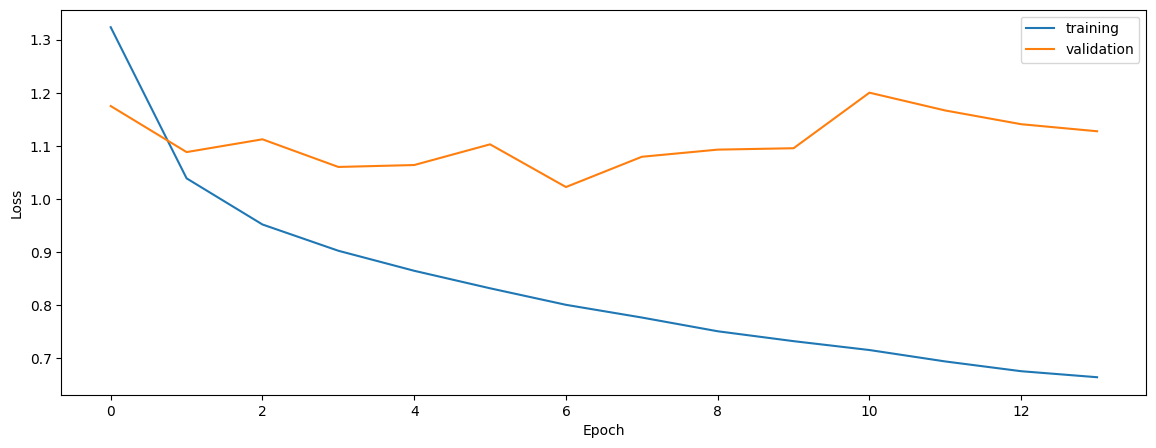

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['features'] = []
props['radiomics'] = []
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_coords_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 831)
(1068345, 1)
validation
(123115, 831)
(123115, 1)
test
(152076, 831)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 831)]             0         


 dense_5 (Dense)             (None, 1024)              851968    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

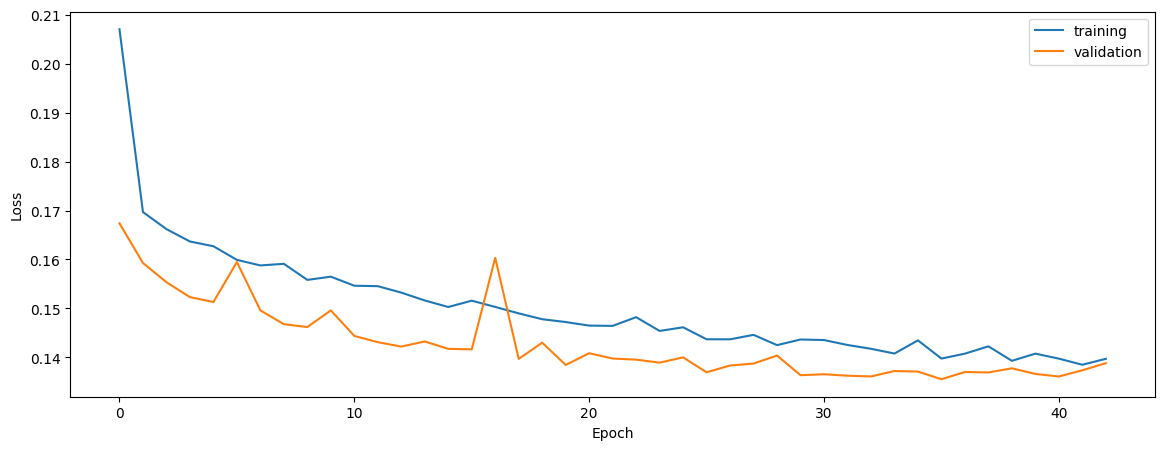

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6827241615331965
0.6808573580034424
0.6588063348021465


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6829280897134441
0.6779623720981406
0.6589918514307371


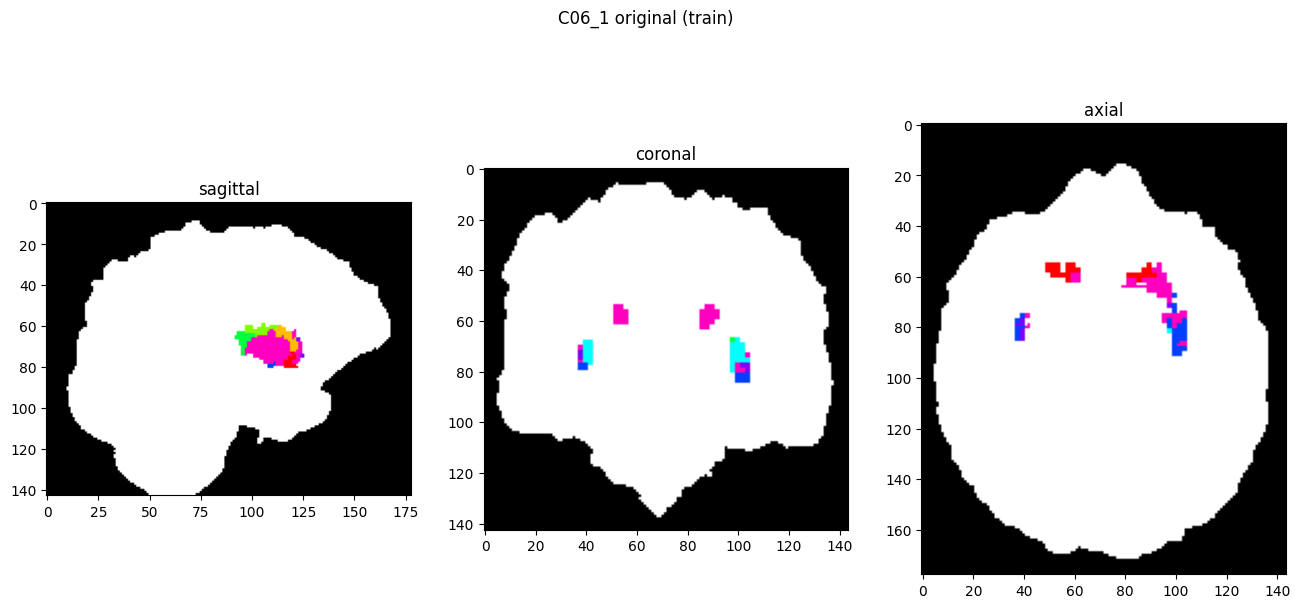

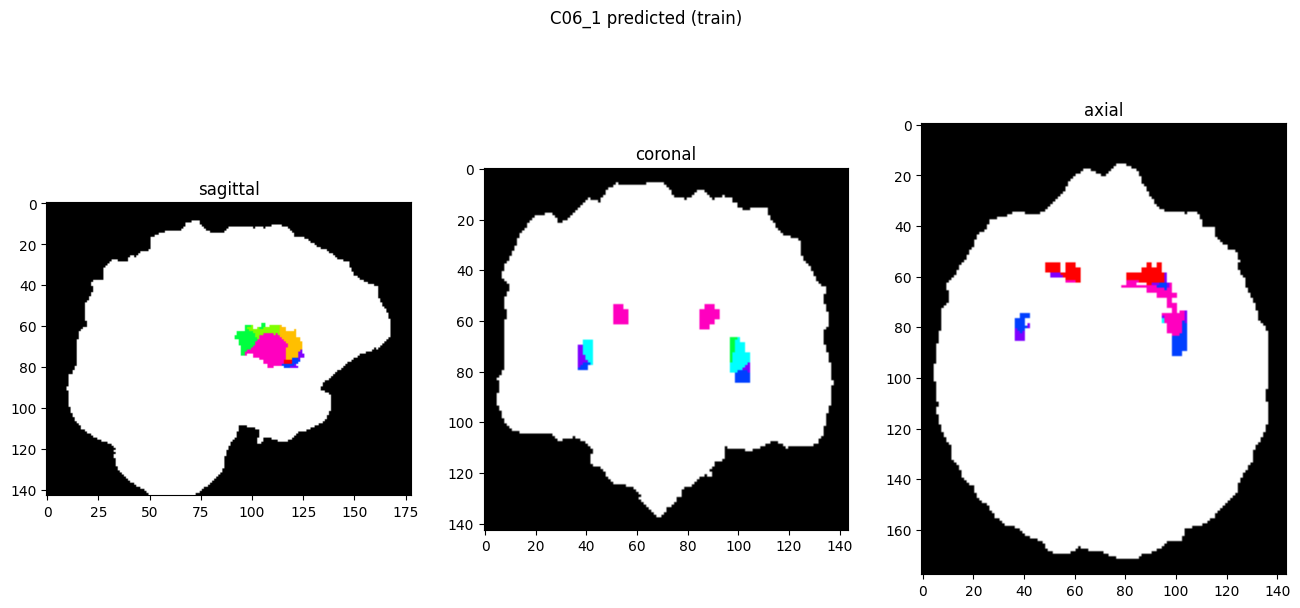

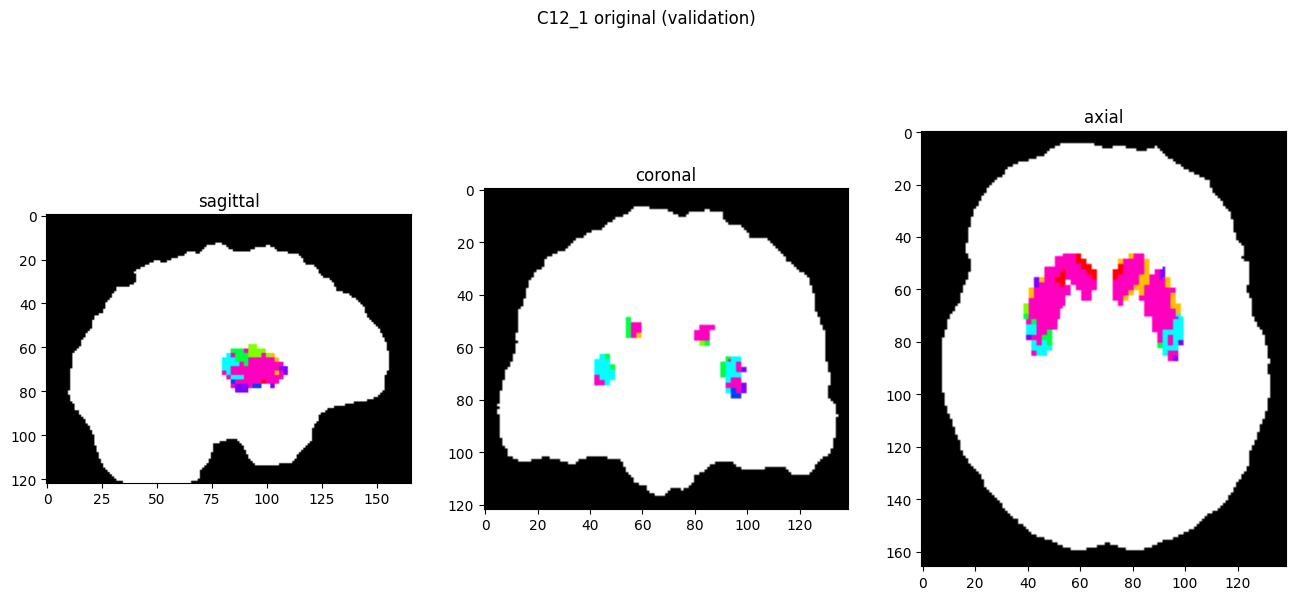

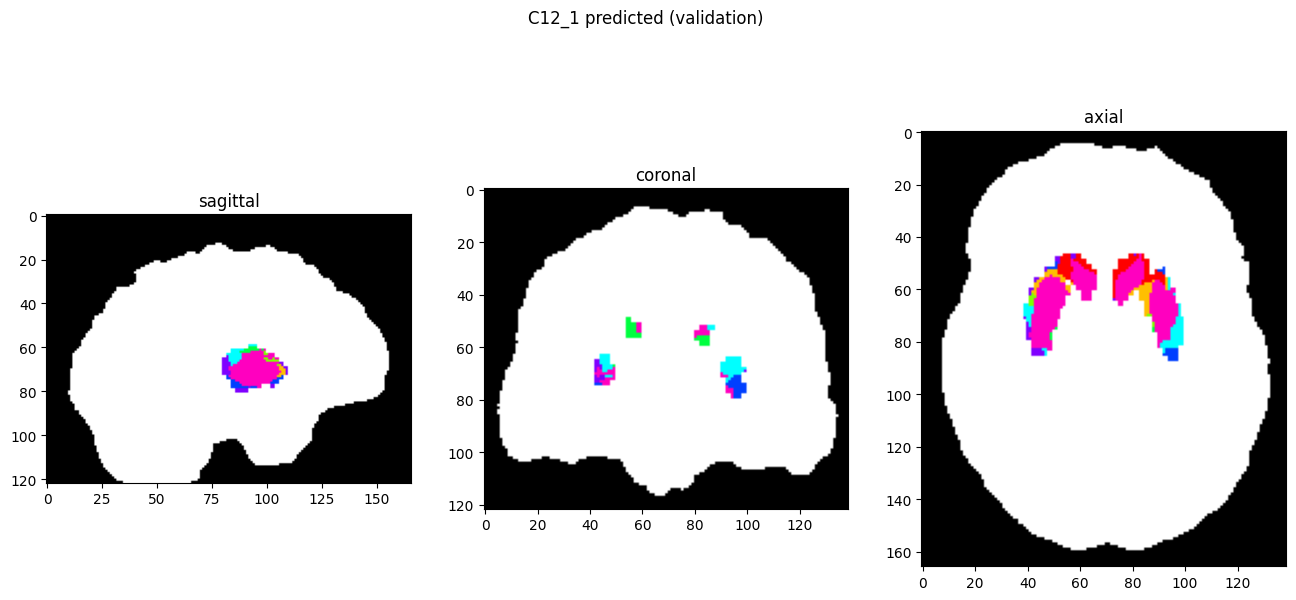

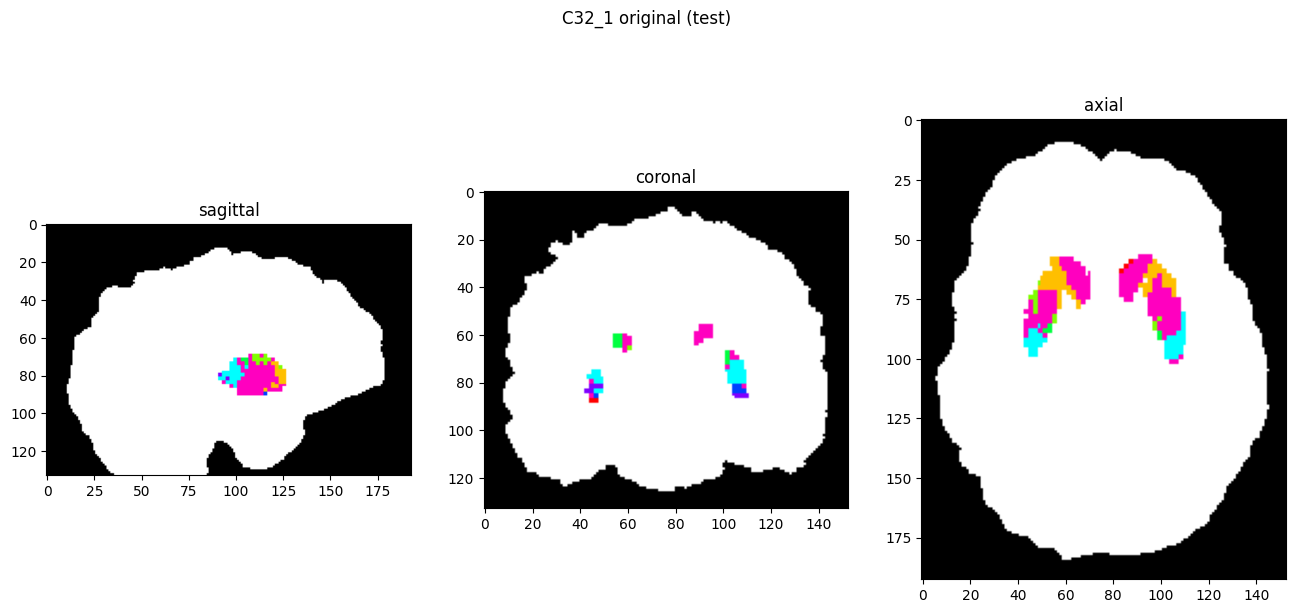

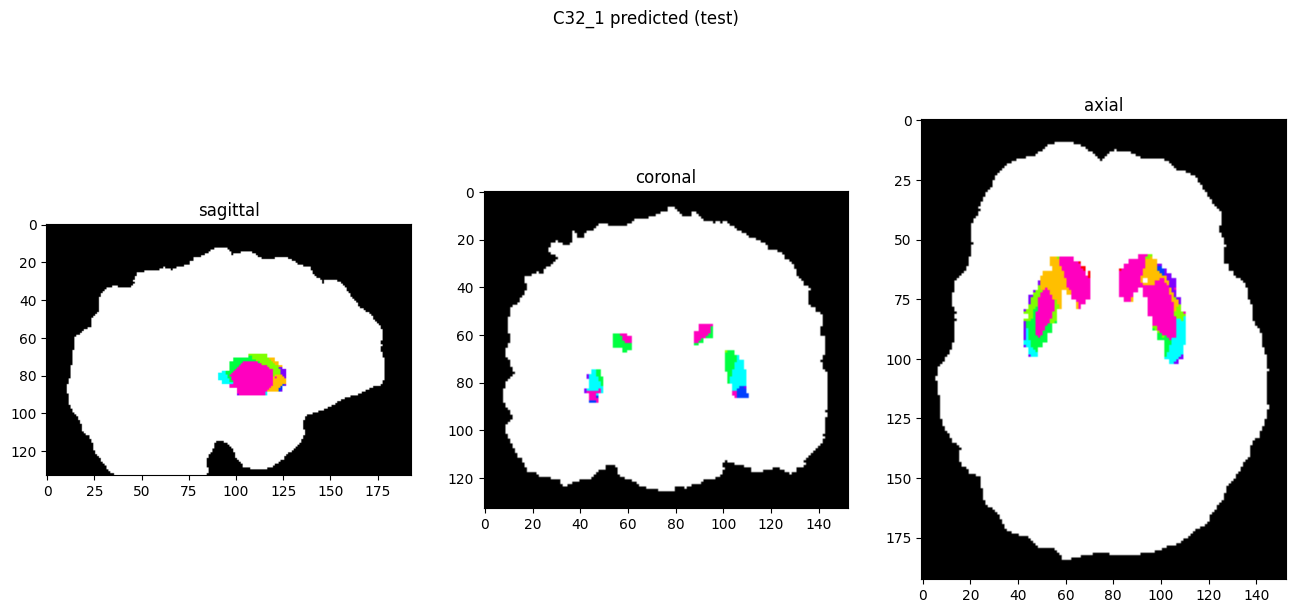

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)